<strong>
    <font color="#088A68">
        Author: lprtk
    </font>
</strong>

<br/>
<br/>


<Center>
    <h1 style="font-family: Arial">
        <font color="#084B8A">
            Time series & Deep Learning: forecast hourly interstate 94 traffic volume
        </font>
    </h1>
</Center>

<br/>

<h3 style="font-family: Arial"><font color="#088A68">Paris 1 Panthéon-Sorbonne, M2 MoSEF 2021-2022</font></h3>

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Introduction & context
        </font>
    </h2>
</div>

<p style="text-align: justify">
    This project focuses on modeling and forecasting hourly urban traffic volumes between two major U.S. cities in the state of Minnesota, Minneapolis and St. Paul, and evaluating the effects of different contextual characteristics such as days of the week, holidays, and weather conditions on traffic volumes. Through this study, we will try to adopt different approaches to analyze the data in order to find the most appropriate model to fit the data, estimate and predict future traffic volume observations over the next hour.<br>
    As you can see, the objective is to use innovative methods to predict the future volume of road traffic and to be able to manage it in advance in order to limit the appearance of traffic jams or to generate optimal routes (taking less time and energy). The results of the study are not limited to the reduction of traffic jams. One week after the release of the latest IPCC report, the stakes are high and these results can, and should, be used to develop strategies to reduce vehicle emissions in these large cities.
</p>

<p style="text-align: justify">
    Attempting to estimate the number of vehicles or people using a specific transportation facility in the future (roadways, public transit, etc.) is important for two types of organizations:
</p>
<ul>
    <li><p style="text-align: justify">
        National and local authorities: Many cities have adopted intelligent transportation systems (ITS) that support urban transportation network planning and traffic management. These systems use current traffic information and generated forecasts to improve transportation efficiency and safety by informing users of current road conditions and adjusting road infrastructure.
    </p></li>
    <li><p style="text-align: justify">
        Logistics companies: these companies (transportation, delivery, home service, etc.) need to accurately plan their operations and create the most efficient routes. Often, this is not only related to current trips, but also to future activities. Accurate forecasts of road and traffic conditions to avoid congestion are crucial to the planning and performance of these businesses.
    </p></li>
</ul>

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Librairies import
        </font>
    </h2>
</div>

In [1]:
import datetime as dt
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from random import choice, randint
import scipy.stats as scs
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, TimeDistributed, MaxPooling1D
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

my_palette = [
    "#A3C4F3",
    "#FFB3C1",
    "#CFBAF0",
    "#FFCFD2",
    "#52B788",
    "#b9fbc0",
    "#98F5E1",
    "#8EECF5",
    "#90DBF4",
    "#F1C0E8",
    "#FDE4CF",
    "#FBF8CC"
]

sns.set_palette(my_palette, 12)

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Data import
        </font>
    </h2>
</div>

<p style="text-align: justify">
    The dataset used lists the hourly volume of traffic on Interstate 94 westbound for Minnesota (MN) Department of Transportation (DoT) ATR 301 station, about halfway between Minneapolis and St. Paul. In addition to the urban traffic data referenced by the Minnesota State Department of Transportation, we have contextual and meteorological data collected and reported by the company OpenWeatherMap.<br>
Initially, the dataset contains 48,204 observations, spanning from 2 October 2012 at 9:00 to 30 September 2018 at 23:00, and 9 characteristics. Below, find a description of these different attributes:
</p>

- "holiday " : is an alpha-numeric variable (object) listing the national holidays in the United States but also the regional holidays in the state of Minnesota;
- "temp " : is a numeric variable indicating the average temperature in Kelvin;
- "rain_1h " : is a numeric variable indicating the amount of rain, measured in millimeters (mm), recorded in the hour;
- "snow_1h " : is a numeric variable indicating the amount of snow, measured in millimeters (mm), recorded in the hour;
- "cloud_all": is a numeric variable, expressed as a percentage, indicating the cloud cover observed in the sky;
- "weather_main" is an alpha-numeric variable that contains a short text description of the current weather;
- "weather_description" is an alpha-numeric variable that contains a more detailed textual description of the current weather;
- "date_time": is a time variable listing the date and time of the data collected in local CST;
- "traffic_volume" is a numeric variable measuring the hourly volume of westbound vehicle traffic reported by ATR 301 on Interstate 94 (our variable of interest).

In [2]:
data = pd.read_csv(filepath_or_buffer="interstate_traffic.csv", sep=",")

data.shape

(48204, 9)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
data.head(5)

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Data cleaning & feature engineering
        </font>
    </h2>
</div>

> « It’s all about the Data. Key to any successful algorithm is a good dataset » (source : National Aeronautics and Space Administration, You Can Help Train NASA’s Rovers to Better Explore Mars | NASA.com).

<p style="text-align: justify">
    Before moving on to the modeling stage, there is a whole pre-processing to be done: make sure that there are no missing values, no absurd values (outliers), no duplicates, no uninterpretable characteristics, no correlation between certain variables, make sure to re-encode certain characteristics, perform format conversions, create new variables or delete old characteristics. This cleaning is the first step, crucial to start the project well, and has a direct influence on the performance and predictions of the future modeling. More and more, the notion of data quality is evoked because poor quality, unprepared or uninterpretable variables will only amplify the black box effect of certain models.
</p>

<h3 style="font-family: Arial">
    <font color="#088A68">
        1) Rename columns
    </font>
</h3>

In [5]:
data.rename(
    columns={
        "rain_1h": "rain",
        "snow_1h": "snow",
        "clouds_all": "cloud",
        "weather_main": "weather",
        "traffic_volume": "traffic"
    },
    inplace=True
)

<h3 style="font-family: Arial">
    <font color="#088A68">
        2) Drop duplicates data
    </font>
</h3>

**Drop duplicates on the date:**
<p style="text-align: justify">
    Below, we can see that there are duplicates on the variable "date_time". That is to say that for the same day and the same time, the observation exists in several copies. Therefore, the first thing to do is to delete these duplicates in order not to pollute our data set.
</p>

In [6]:
dupicated = data[data.duplicated(keep=False)]
dupicated

holiday     temp  rain  snow  cloud       weather  \
18696    None  286.290   0.0   0.0      1         Clear   
18697    None  286.290   0.0   0.0      1         Clear   
23850    None  289.060   0.0   0.0     90        Clouds   
23851    None  289.060   0.0   0.0     90        Clouds   
26783    None  289.775   0.0   0.0     56        Clouds   
26784    None  289.775   0.0   0.0     56        Clouds   
26979    None  287.860   0.0   0.0      0         Clear   
26980    None  287.860   0.0   0.0      0         Clear   
27170    None  279.287   0.0   0.0     56        Clouds   
27171    None  279.287   0.0   0.0     56        Clouds   
28878    None  267.890   0.0   0.0     90          Snow   
28879    None  267.890   0.0   0.0     90          Snow   
29267    None  254.220   0.0   0.0      1         Clear   
29268    None  254.220   0.0   0.0      1         Clear   
34710    None  295.010   0.0   0.0     40        Clouds   
34711    None  295.010   0.0   0.0     40        Clouds   
34966    None  292.840   0.0   0.0      1         Clear   
34967    None  292.840   0.0   0.0      1         Clear   
34968    None  294.520   0.0   0.0      1         Clear   
34969    None  294.520   0.0   0.0      1         Clear   
34970    None  295.770   0.0   0.0     75        Clouds   
34971    None  295.770   0.0   0.0     75        Clouds   
34972    None  296.950   0.0   0.0      1  Thunderstorm   
34973    None  296.950   0.0   0.0      1  Thunderstorm   
37571    None  288.890   0.0   0.0      1         Clear   
37572    None  288.890   0.0   0.0      1         Clear   
38674    None  278.720   0.0   0.0     90       Drizzle   
38675    None  278.720   0.0   0.0     90          Mist   
38676    None  278.720   0.0   0.0     90       Drizzle   
38677    None  278.720   0.0   0.0     90          Mist   
39526    None  266.220   0.0   0.0      1         Clear   
39527    None  266.220   0.0   0.0      1         Clear   
48172    None  280.680   0.0   0.0     90        Clouds   
48173    None  280.680   0.0   0.0     90        Clouds   

           weather_description            date_time  traffic  
18696             sky is clear  2015-09-30 19:00:00     3679  
18697             sky is clear  2015-09-30 19:00:00     3679  
23850          overcast clouds  2016-06-01 10:00:00     4831  
23851          overcast clouds  2016-06-01 10:00:00     4831  
26783            broken clouds  2016-09-21 15:00:00     5365  
26784            broken clouds  2016-09-21 15:00:00     5365  
26979             Sky is Clear  2016-09-29 19:00:00     3435  
26980             Sky is Clear  2016-09-29 19:00:00     3435  
27170            broken clouds  2016-10-07 18:00:00     4642  
27171            broken clouds  2016-10-07 18:00:00     4642  
28878               light snow  2016-12-06 18:00:00     4520  
28879               light snow  2016-12-06 18:00:00     4520  
29267             sky is clear  2016-12-19 00:00:00      420  
29268             sky is clear  2016-12-19 00:00:00      420  
34710         scattered clouds  2017-06-21 11:00:00     4808  
34711         scattered clouds  2017-06-21 11:00:00     4808  
34966             sky is clear  2017-06-30 10:00:00     4638  
34967             sky is clear  2017-06-30 10:00:00     4638  
34968             sky is clear  2017-06-30 11:00:00     4725  
34969             sky is clear  2017-06-30 11:00:00     4725  
34970            broken clouds  2017-06-30 12:00:00     5229  
34971            broken clouds  2017-06-30 12:00:00     5229  
34972             thunderstorm  2017-06-30 13:00:00     5263  
34973             thunderstorm  2017-06-30 13:00:00     5263  
37571             sky is clear  2017-09-29 19:00:00     4498  
37572             sky is clear  2017-09-29 19:00:00     4498  
38674  light intensity drizzle  2017-11-05 01:00:00      629  
38675                     mist  2017-11-05 01:00:00      629  
38676  light intensity drizzle  2017-11-05 01:00:00      629  
38677                     mist  2017-11-05 01:00:0

In [7]:
data.drop_duplicates(subset="date_time", keep="first", inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(40575, 9)

<h3 style="font-family: Arial">
    <font color="#088A68">
        3) imputation of missing values
    </font>
</h3>

**Visualization and imputation of missing values:**
<p style="text-align: justify">
    First, we will use this variable "date_time" to parse it and create new characteristics: date, time, day, month, etc. Then, we will make a first visualization of the data in order to see the distribution of these temporal variables. From the graphs, below, we notice two important things:
</p>

<ol>
    <li><p style="text-align: justify">
        We clearly notice the presence of missing data within the dates. Indeed, the volume of observations is not similar for each hour, each day of the week, each month and each year. Thus, hourly data seem to be missing in our dataset and must be added to avoid any modeling bias due to temporal discontinuity.<br>
        In studying the pattern of these missing values, we assume that they follow the underlying MAR (Missing at Random) process, cf. Rubin's 1976 classification of missing data, because for a given observation, i.e. a day and time, values are missing for all observed features. In other words, the missing data are not completely random, but the propensity to miss depends on the observed data, not on the missing data.
The imputation technique chosen, for missing data following this process, is a method approximating the predictive mean matching algorithm (Paul Allison or Vink et al., 2014). What does it involve? The idea is to estimate a linear regression model using the variable to be imputed as the Y variable and only the observed values of the X and Y variables to estimate the model. De facto, for each case where Y is missing, we find the closest predicted values among the cases where Y is observed.
    </p></li>
    <li><p style="text-align: justify">
        Then, in addition to the missing hourly data, if we analyze the annual recorded traffic volume data more closely, we see a very clear temporal break within the data between the years 2014 and 2015. In other words, we do not have road traffic volume data for the year 2015. Therefore, for future modeling, we will focus on a study period between 2016 and 2018 that does not appear to contain any temporal discontinuity. The number of data over this period is 21,041 observations (before imputation), which is more than enough to make predictions either by simple linear models or by more sophisticated Machine and Deep Learning models.
    </p></li>
</ol>

In [8]:
# visualisation 
df1 = data.copy()

df1["date_time"] = pd.to_datetime(df1["date_time"])
df1["date"] = df1["date_time"].dt.date
df1["hour"] = df1["date_time"].dt.hour
df1["day"] = df1["date_time"].dt.day
df1["weekday"] = df1["date_time"].dt.weekday
df1["month"] = df1["date_time"].dt.month
df1["year"] = df1["date_time"].dt.year

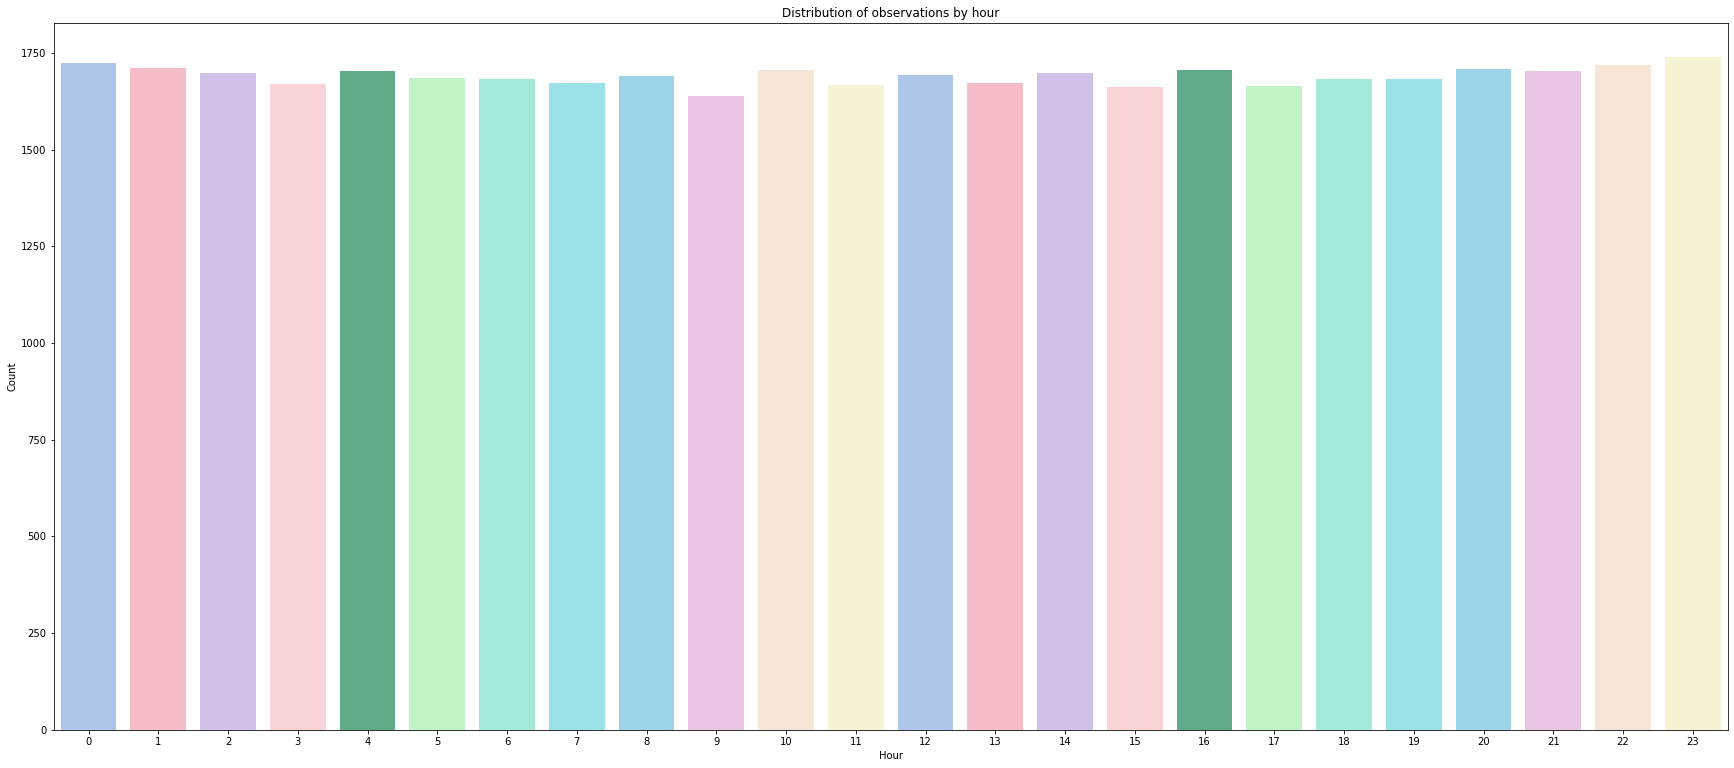

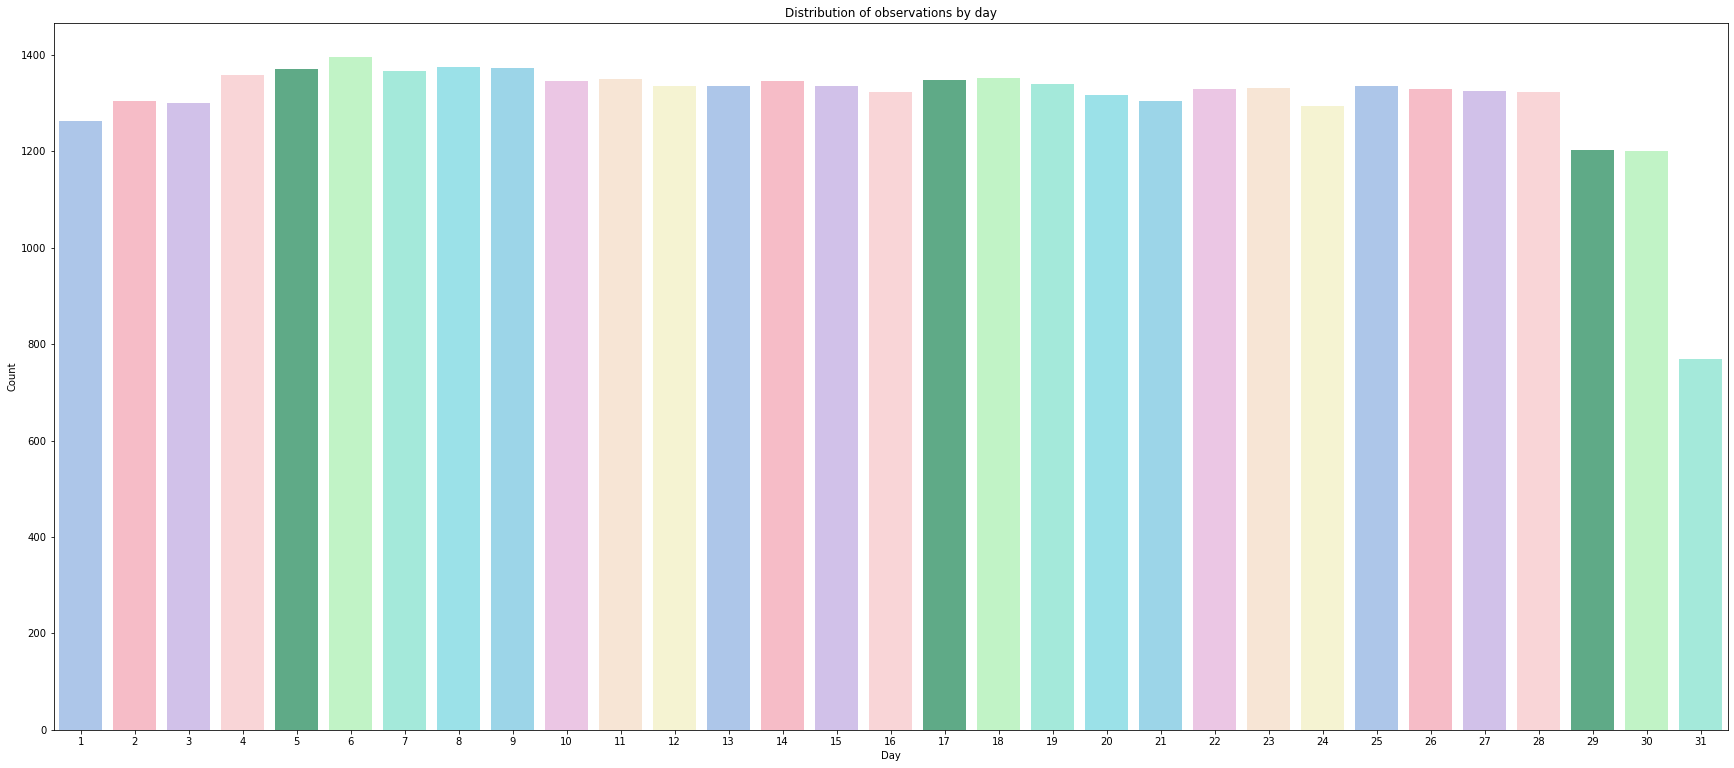

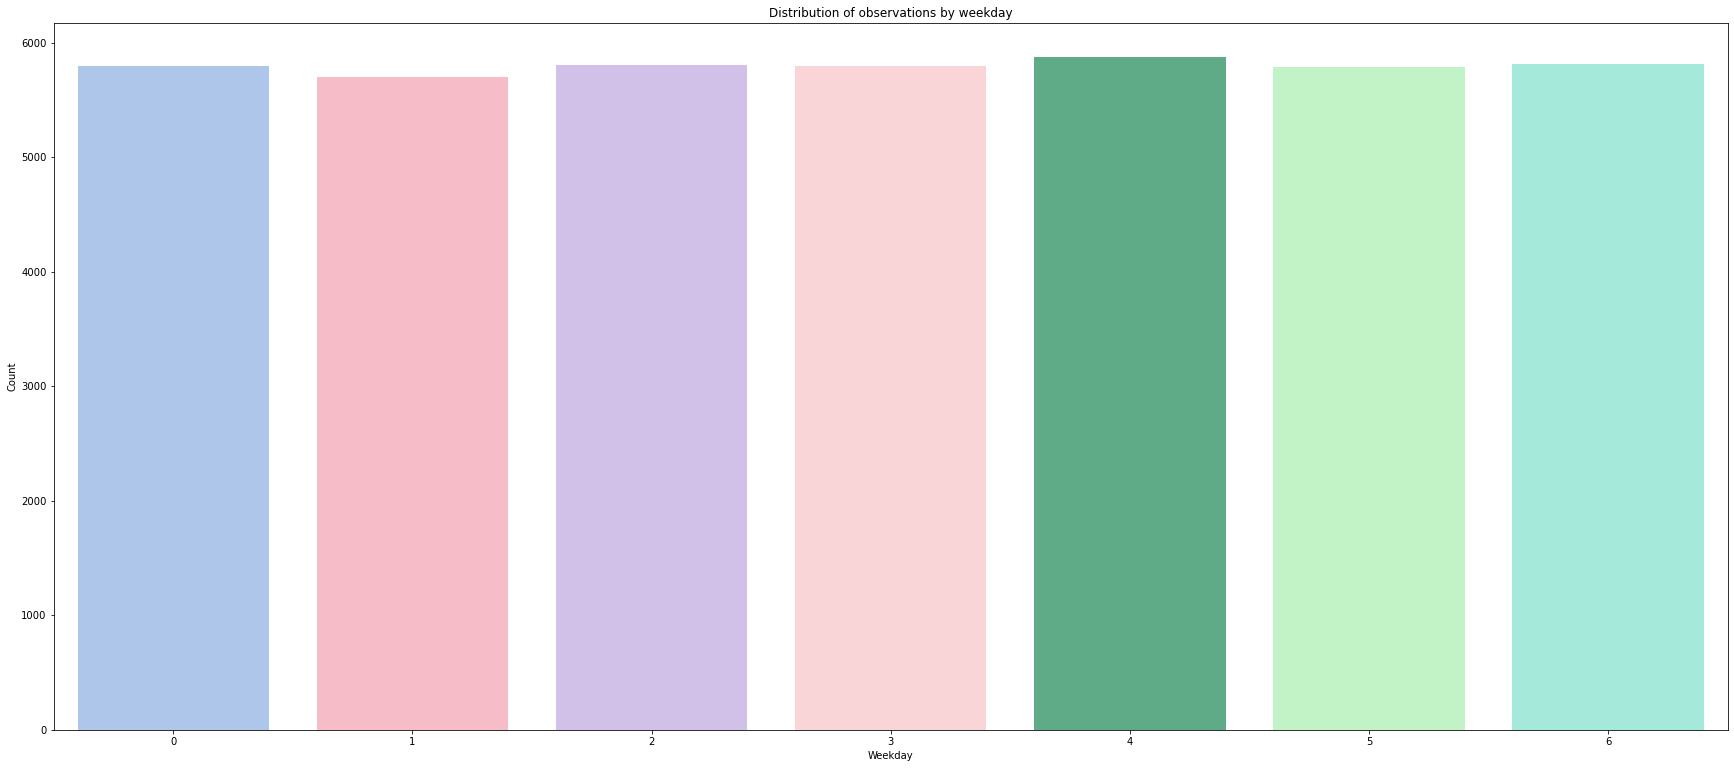

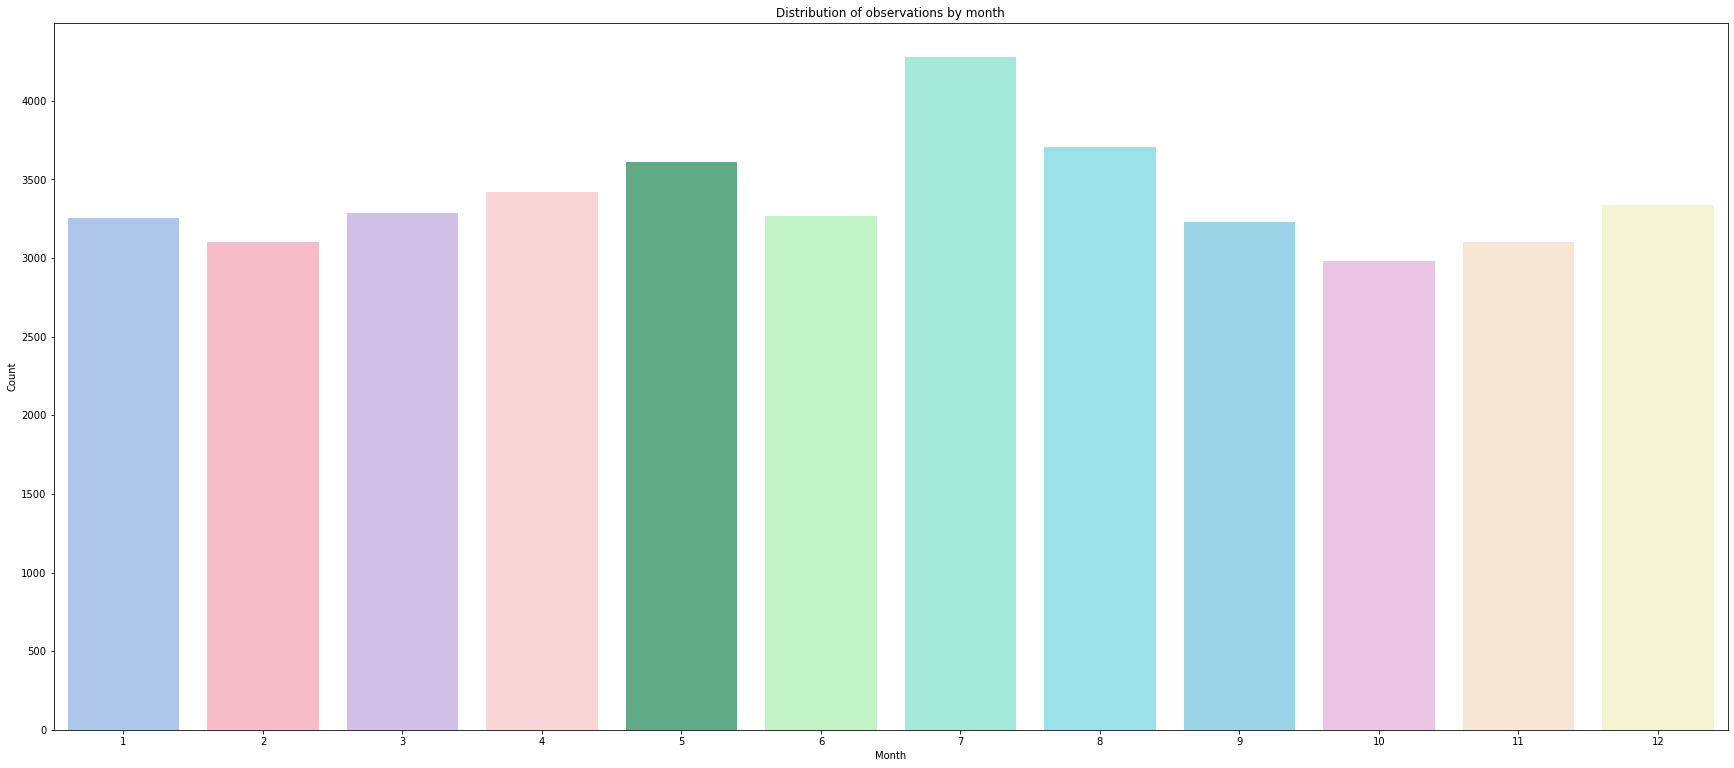

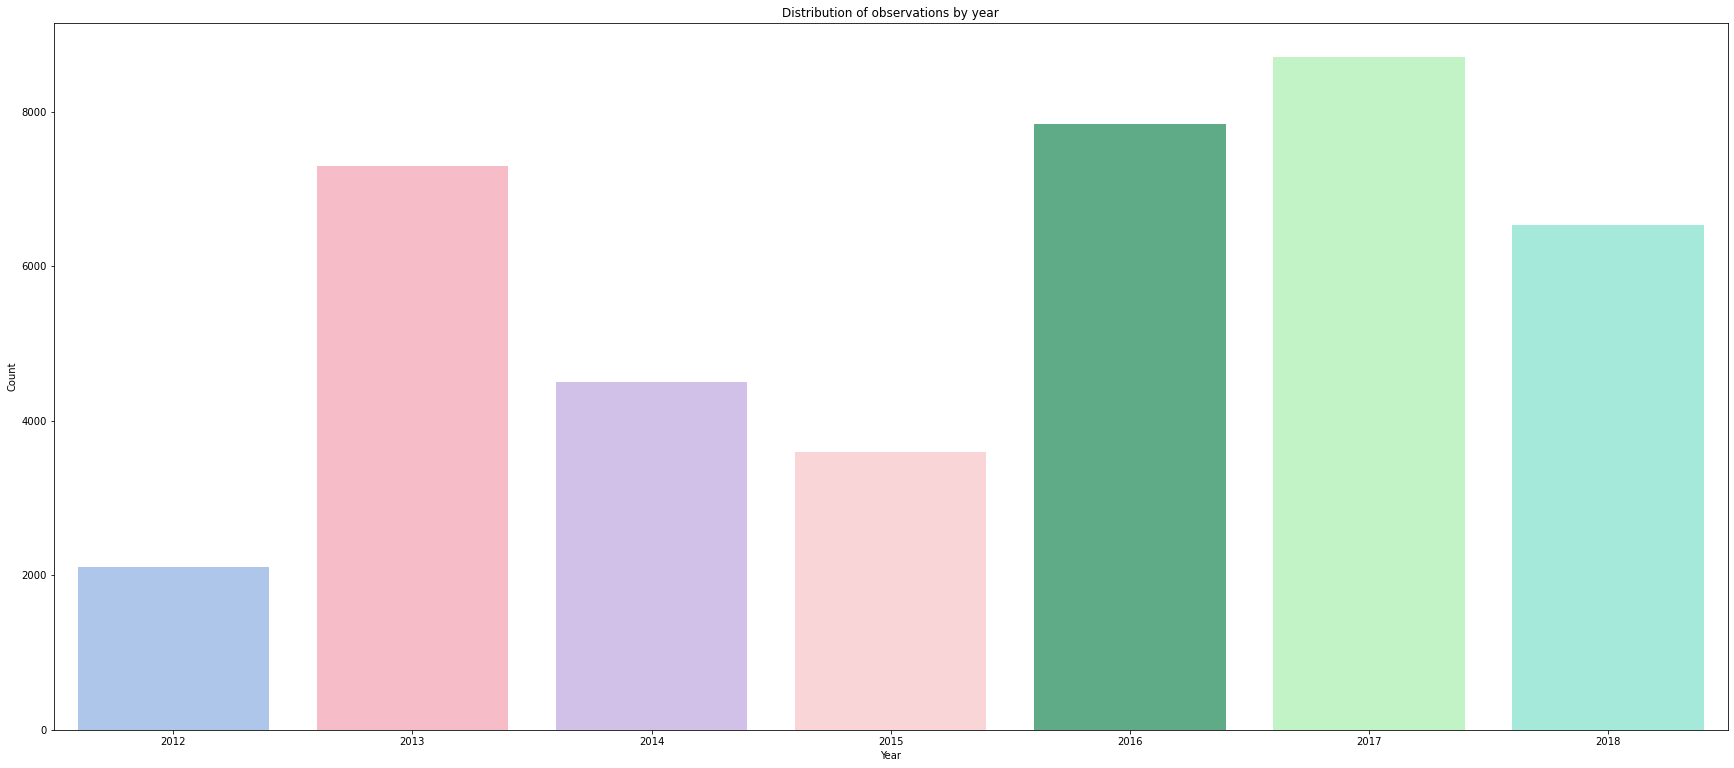

In [9]:
for column in ["hour", "day", "weekday", "month", "year"]:
    fig = plt.figure(figsize=(30, 13))
    plt.subplot(1, 1, 1)
    sns.countplot(x=column, data=df1, palette=my_palette)
    plt.title(f"Distribution of observations by {column}")
    plt.xlabel(f"{column.capitalize()}")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

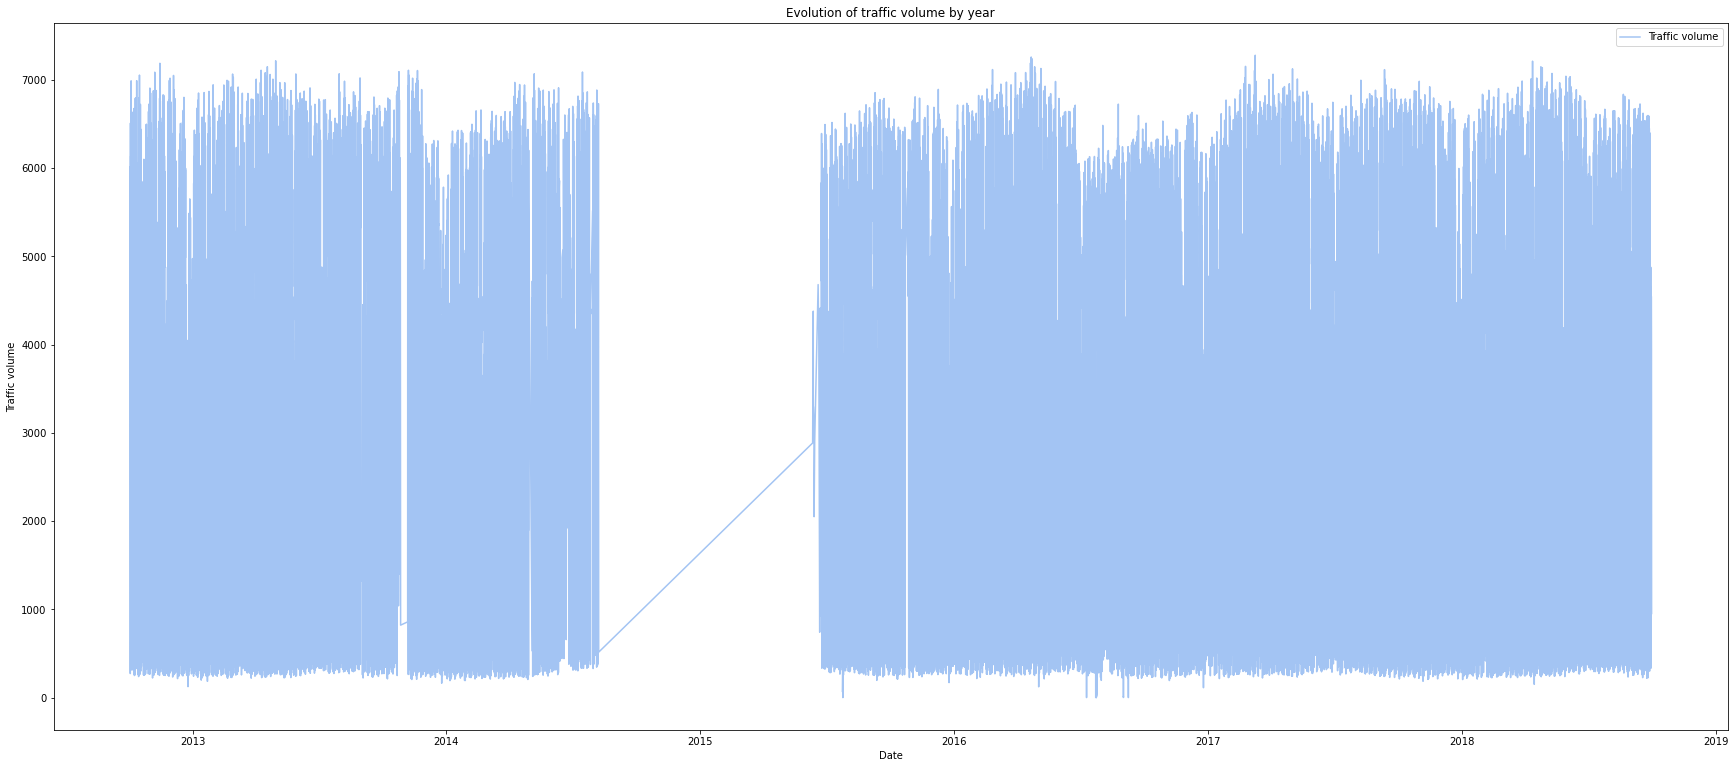

In [10]:
fig = plt.figure(figsize=(30, 13))
plt.subplot(1, 1, 1)
plt.plot(df1["date_time"], df1["traffic"], label="Traffic volume")
plt.title("Evolution of traffic volume by year")
plt.xlabel("Date")
plt.ylabel("Traffic volume")
plt.legend(loc="best")
plt.xticks(rotation=0)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [11]:
# filter on date_time
df2 = data[data["date_time"] >= "2016-05-01 00:00:00"]
df2.reset_index(drop=True, inplace=True)
df2.shape

(21041, 9)

In [12]:
# convert date_time to timestamp format
df2["date_time"] = pd.to_datetime(df2["date_time"])

In [13]:
# start of imputation
df3 = df2[["date_time","traffic"]]

In [14]:
# resample in order to add missing hours in date_time
df3 = df3.set_index("date_time").resample("H").asfreq(fill_value="NaN").reset_index()

In [15]:
# merge in order to rebuild the dataset
df3 = pd.merge(df3, df2, how="left")

In [16]:
# check about missing values
df3.isnull().sum().to_frame(name="Missing value").T

date_time  traffic  holiday  temp  rain  snow  cloud  weather  \
Missing value          0        0      151   151   151   151    151      151   

               weather_description  
Missing value                  151

In [17]:
# imputation of numerical missing values
reg = LinearRegression()

imputer = IterativeImputer(
    estimator=reg,
    missing_values=np.nan,
    max_iter=10,
    verbose=2,
    imputation_order="roman",
    random_state=0
)

imputation = imputer.fit_transform(
    df3[["traffic", "temp", "rain", "snow", "cloud"]]
)

feature_imputed = pd.DataFrame(
    imputation,
    columns=["traffic", "temp", "rain", "snow", "cloud"]
)
feature_imputed.shape

[IterativeImputer] Completing matrix with shape (21192, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.02
[IterativeImputer] Change: 1.2833756279917452e-10, scaled tolerance: 9.831299999999999 
[IterativeImputer] Early stopping criterion reached.


(21192, 5)

In [18]:
# concat numeric_imputed DataFrame with data_subset
data = feature_imputed.join(df3[["date_time", "holiday", "weather", "weather_description"]])
data.shape

(21192, 9)

In [19]:
# f-fill categorical missing values
data = data.ffill()

In [20]:
# check missing values
data.isnull().sum().to_frame(name="Missing value").T

traffic  temp  rain  snow  cloud  date_time  holiday  weather  \
Missing value        0     0     0     0      0          0        0        0   

               weather_description  
Missing value                    0

<h3 style="font-family: Arial">
    <font color="#088A68">
        4) Convert temperature (in Kelvin) to Celsius
    </font>
</h3>

**Conversion:**
<p style="text-align: justify">
    As the temperature is expressed in Kelvin, we prefer to convert it to Celsius degrees so that it is easier to understand.
</p>

In [21]:
data["temp"] = (data["temp"]-273.15)

<h3 style="font-family: Arial">
    <font color="#088A68">
        5) Extracting new features from timestamp
    </font>
</h3>

**Creation of new features:**
<p style="text-align: justify">
    As in the previous imputation, we will use the "date_time" variable to parse it and create new characteristics: date, time, day, month, season, etc. The objective is to create variables for data visualization but also, potentially, for our models. Indeed, we can think, a priori, that the fact of observing which day of the week we are or the current time, could have a positive or negative impact on the volume of traffic recorded.
</p>

In [22]:
data["date_time"] = pd.to_datetime(data["date_time"])
data["weekday"] = data["date_time"].dt.weekday
data["date"] = data["date_time"].dt.date
data["date"] = pd.to_datetime(data["date"])
data["hour"] = data["date_time"].dt.hour
data["month"] = data["date_time"].dt.month
data["year"] = data["date_time"].dt.year

In [23]:
# categorizing days
def weekday(data) -> str:
    """
    Function that discretizes the days of the week into textual variables.

    Parameters
    ----------
    data : pd.core.frame.DataFrame or pd.core.series.Series
        Data to be discretized.

    Returns
    -------
    str
        Day corresponding to the associated number.

    """
    if data == 0:
        return "monday"
    elif data == 1:
        return "tuesday"
    elif data == 2:
        return "wenesday"
    elif data == 3:
        return "thursday"
    elif data == 4:
        return "friday"
    elif data == 5:
        return "saturday"
    else:
        return "sunday"

data["weekday_categorical"] = data["weekday"].map(weekday)

In [24]:
# categorizing hours to different time periods like morning, afternoon etc
def hour(data) -> str:
    """
    Function that discretizes the hours of the days into textual variables.

    Parameters
    ----------
    data : pd.core.frame.DataFrame or pd.core.series.Series
        Data to be discretized.

    Returns
    -------
    str
        Moment corresponding to the associated hours.

    """
    if data in [4, 5, 6, 7]:
        return "early_morning"
    elif data in [8, 9, 10, 11]:
        return "morning"
    elif data in [12, 13, 14, 15]:
        return "afternoon"
    elif data in [16, 17, 18, 19]:
        return "evening"
    elif data in [20, 21, 22, 23]:
        return "night"
    else:
        return "late_night"

data["hour_categorical"] = data["hour"].map(hour)

In [25]:
# categorizing months to different seasons
def season(data) -> str:
    """
    Function that discretizes the months to seasons.

    Parameters
    ----------
    data : pd.core.frame.DataFrame or pd.core.series.Series
        Data to be discretized.

    Returns
    -------
    str
        Season corresponding to the associated months.

    """
    if data in [12, 1, 2]:
        return "winter"
    elif data in [3, 4, 5]:
        return "spring"
    elif data in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

data["season"] = data["month"].map(season)

<h3 style="font-family: Arial">
    <font color="#088A68">
        6) New categorical features for EDA
    </font>
</h3>

**Binarization:**
<p style="text-align: justify">
    For modeling purposes, we prefer to binarize the "holiday" variable, listing public holidays, because there are multiple holidays and because we have very little data on these holidays in the data set. Thus, we think that keeping the exhaustiveness of the holidays does not bring a real gain of information.<br>
Then, the variables "rain_1h" and "snow_1h", measuring respectively the amount of rain and snow, in mm, fallen in one hour, are also binarized but only for the visualization of the data that will come in the next section.
</p>

In [26]:
def to_categorical(data) -> int:
    """
    Function that allows to binarize.

    Parameters
    ----------
    data : pd.core.frame.DataFrame or pd.core.series.Series
        Data to be discretized.

    Returns
    -------
    int
        Binarize feature.

    """
    if data == "None":
        return 0
    else:
        return 1

data["holiday_categorical"] = data["holiday"].map(to_categorical)

In [27]:
def to_categorical(data) -> int:
    """
    Function that allows to binarize.

    Parameters
    ----------
    data : pd.core.frame.DataFrame or pd.core.series.Series
        Data to be discretized.

    Returns
    -------
    int
        Binarize feature.

    """
    if data > 0.0:
        return 1
    else:
        return 0

data["rain_categorical"] = data["rain"].map(to_categorical)
data["snow_categorical"] = data["snow"].map(to_categorical)

<h3 style="font-family: Arial">
    <font color="#088A68">
        7) Introduce lagged features
    </font>
</h3>

**Creation of delayed features:**
<p style="text-align: justify">
    The variables "temp", "rain_1h", "cloud_all" and "traffic_volume" are taken without delay but also with delays of 1, 2, 3 and 6 hours. We started from the observation that when it rains (or is very nice), is very cold (or very hot) or the sky is very dark (or very clear) in the hours before our trip, it can make us think about taking the car, the transport or the bike.
</p>

In [28]:
def create_lag(data: pd.core.frame.DataFrame, column: str, lags: list) -> pd.core.frame.DataFrame:
    """
    Function that allows to create lagged features.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
    
    column : str
        column to be transformed.
    
    lags : list
        Lag numbers.

    Returns
    -------
    pd.core.frame.DataFrame
        Lagged feature.

    """
    for lag in lags:
        data[column + "_lag_" + str(lag)] = data[column].shift(periods=lag).astype(np.float16)
    
    return data

data = create_lag(data=data, column="temp", lags=[1, 2, 3, 6])
data = create_lag(data=data, column="rain", lags=[1, 2, 3, 6])
data = create_lag(data=data, column="cloud", lags=[1, 2, 3, 6])
data = create_lag(data=data, column="traffic", lags=[1, 2, 3, 6])

In [29]:
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

<h3 style="font-family: Arial">
    <font color="#088A68">
        8) Introduce mean encoding features
    </font>
</h3>

**Creating features with mean target encoding:**

<p style="text-align: justify">
    The variables "temp", "rain_1h", and "cloud_all" are also transformed using mean target encoding, which allows us to represent the probability of our target variable conditional on each feature value. Using this technique both solves the encoding task and creates a feature that is more representative of the target variable, killing two birds with one stone.
</p>

In [30]:
data["temp_avg"] = data.groupby("temp")["traffic"].transform("mean").astype(np.float16)
data["rain_avg"] = data.groupby("rain")["traffic"].transform("mean").astype(np.float16)
data["cloud_avg"] = data.groupby("cloud")["traffic"].transform("mean").astype(np.float16)

<h3 style="font-family: Arial">
    <font color="#088A68">
        9) Introduce rolling window features
    </font>
</h3>

**Creating features with the average on rolling windows:**

<p style="text-align: justify">
    The variables "temp", "rain_1h" and "cloud_all" are also transformed using rolling windows of 3 and 6 hours. Very simply, we take a window of size $k$ at a given time and average over it. A window of size $k$ means $k$ consecutive values at a time.
</p>

In [31]:
def create_window(data: pd.core.frame.DataFrame, column: str, windows: list) -> pd.core.frame.DataFrame:
    """
    Function that allows to create rolling windows features.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
    
    column : str
        column to be transformed.
    
    windows : list
        Rolling window size.

    Returns
    -------
    pd.core.frame.DataFrame
        Rolling windows feature.

    """
    for window in windows:
        data[column + "_win_" + str(window)] = data[column].rolling(window=window).mean().astype(np.float16)
    
    return data

data = create_window(data=data, column="temp", windows=[3, 6])
data = create_window(data=data, column="rain", windows=[3, 6])
data = create_window(data=data, column="cloud", windows=[3, 6])

In [32]:
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

<h3 style="font-family: Arial">
    <font color="#088A68">
        10) Cyclical features encoding
    </font>
</h3>

**Encoding of temporal features: cyclical encoding**
<p style="text-align: justify">
    We perform a re-encoding of the hours and days of the week with the cyclic encoding using a cosine/sine transformation that encodes the variable on a circle (like the dial of a clock). The objective is that our models understand that 23h is close to 1h, just like Sunday (encoded by index 6) is close to Monday (encoded by index 0).
</p>

In [33]:
def cyclical_encoding(data: pd.core.frame.DataFrame, column: str) -> pd.core.frame.DataFrame:
    """
    Function that allows to encoding timestamp features.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
        
    column : str
        column to be transformed.

    Returns
    -------
    pd.core.frame.DataFrame
        Encoding feature.

    """
    data[column + "_norm"] = ((2*np.pi*data[column]) / np.max(data[column]))
    data[column + "_sin"] = np.sin(data[column + "_norm"])
    data[column + "_cos"] = np.cos(data[column + "_norm"])
    
    return data

data = cyclical_encoding(data=data, column="hour")
data = cyclical_encoding(data=data, column="weekday")

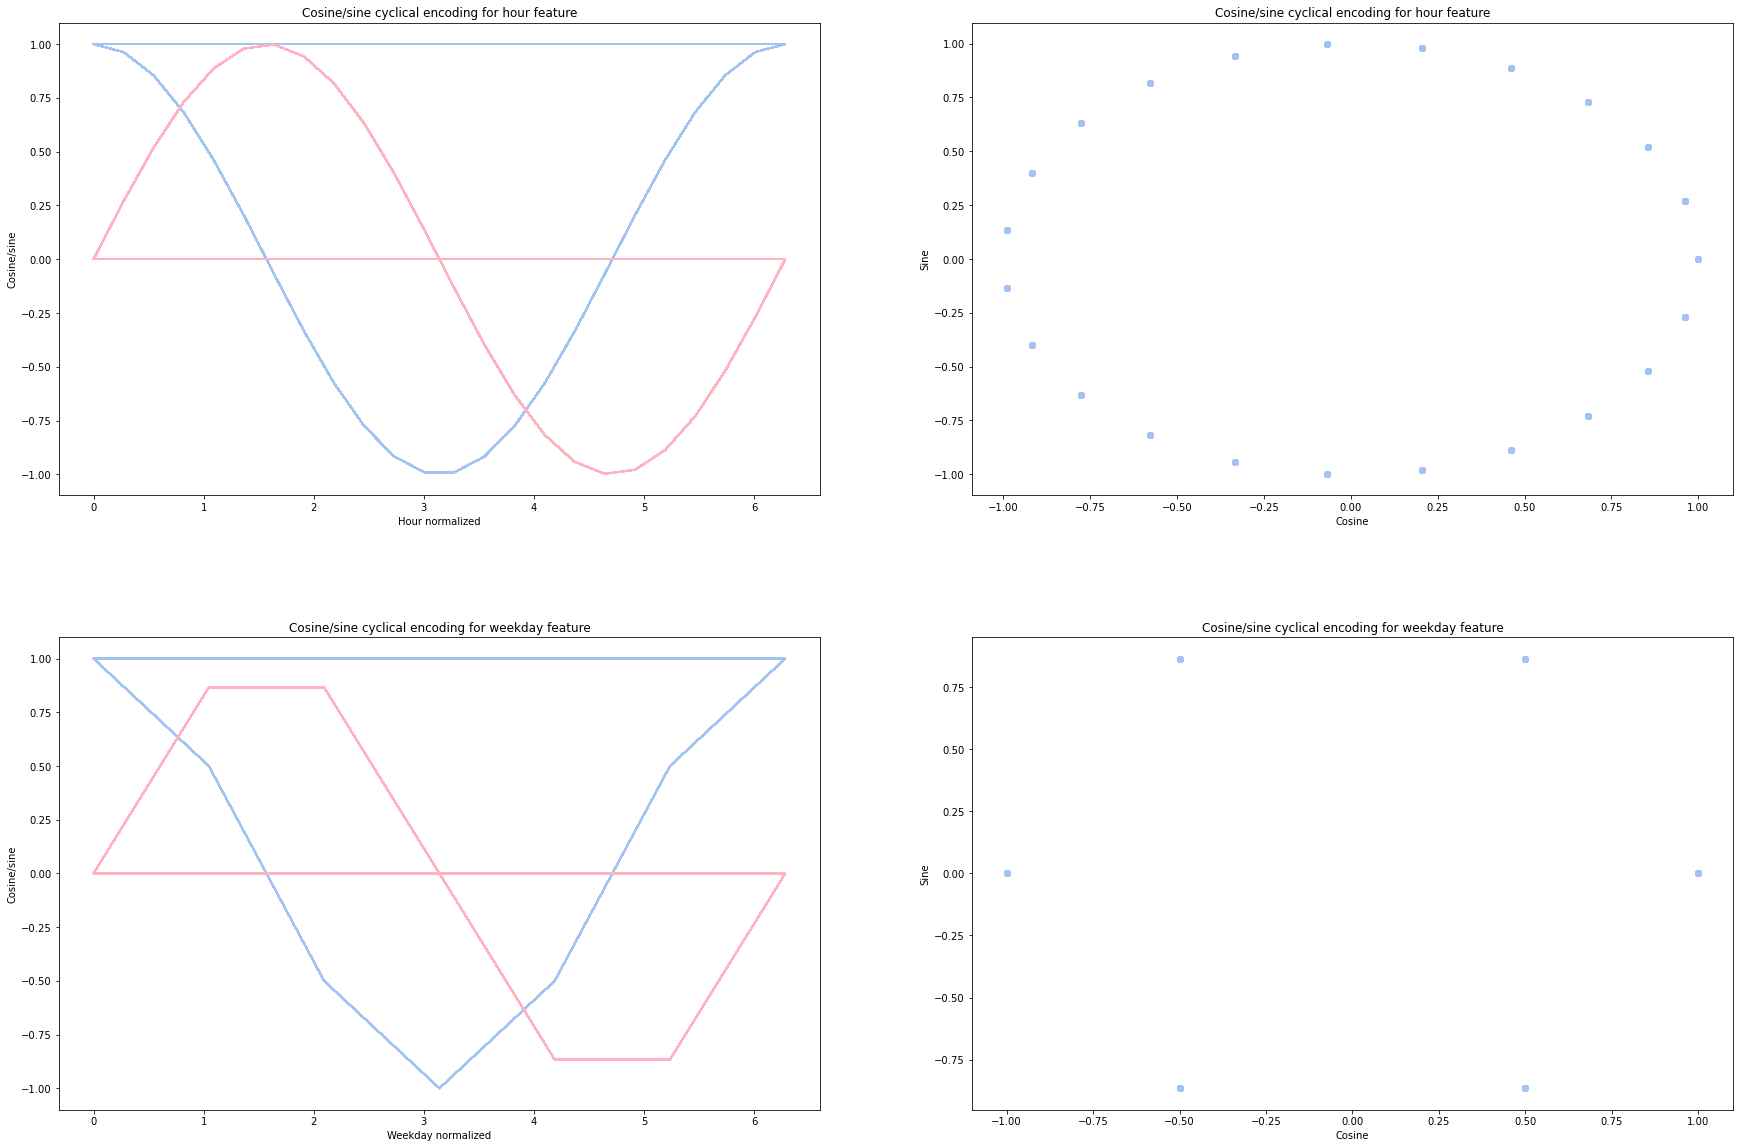

In [34]:
fig = plt.figure(figsize=(30, 20))

# line 1
plt.subplot(2, 2, 1)
plt.plot(data["hour_norm"], data["hour_cos"], label="cosinus")
plt.plot(data["hour_norm"], data["hour_sin"], label="sinus")
plt.title("Cosine/sine cyclical encoding for hour feature")
plt.xlabel("Hour normalized")
plt.ylabel("Cosine/sine")
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
plt.scatter(data=data, x="hour_cos", y="hour_sin")
plt.title("Cosine/sine cyclical encoding for hour feature")
plt.xlabel("Cosine")
plt.ylabel("Sine")
plt.xticks(rotation=0)

# line 2
plt.subplot(2, 2, 3)
plt.plot(data["weekday_norm"], data["weekday_cos"], label="cosinus")
plt.plot(data["weekday_norm"], data["weekday_sin"], label="sinus")
plt.title("Cosine/sine cyclical encoding for weekday feature")
plt.xlabel("Weekday normalized")
plt.ylabel("Cosine/sine")
plt.xticks(rotation=0)

plt.subplot(2, 2, 4)
plt.scatter(data=data, x="weekday_cos", y="weekday_sin")
plt.title("Cosine/sine cyclical encoding for weekday feature")
plt.xlabel("Cosine")
plt.ylabel("Sine")
plt.xticks(rotation=0)

plt.subplots_adjust(hspace=0.3)
plt.show()

<h3 style="font-family: Arial">
    <font color="#088A68">
        11) Optimizing RAM's storage
    </font>
</h3>

In [35]:
def downcast(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Function that allows to optimize RAM's storage.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data to be optimized.

    Returns
    -------
    pd.core.frame.DataFrame
        Optimized dataset.

    """
    columns = data.dtypes.index.tolist()
    types = data.dtypes.values.tolist()
    
    for i, t in enumerate(types):
        if "int" in str(t):
            
            if (data[columns[i]].min() > np.iinfo(np.int8).min) and (data[columns[i]].max() < np.iinfo(np.int8).max):
                data[columns[i]] = data[columns[i]].astype(np.int8)
            
            elif (data[columns[i]].min() > np.iinfo(np.int16).min) and (data[columns[i]].max() < np.iinfo(np.int16).max):
                data[columns[i]] = data[columns[i]].astype(np.int16)
                
            elif (data[columns[i]].min() > np.iinfo(np.int32).min) and (data[columns[i]].max() < np.iinfo(np.int32).max):
                data[columns[i]] = data[columns[i]].astype(np.int32)
            
            else:
                data[columns[i]] = data[columns[i]].astype(np.int64)
        
        elif "float" in str(t):
            
            if (data[columns[i]].min() > np.finfo(np.float16).min) and (data[columns[i]].max() < np.finfo(np.float16).max):
                data[columns[i]] = data[columns[i]].astype(np.float16)
            
            elif (data[columns[i]].min() > np.finfo(np.float32).min) and (data[columns[i]].max() < np.finfo(np.float32).max):
                data[columns[i]] = data[columns[i]].astype(np.float32)
            
            else:
                data[columns[i]] = data[columns[i]].astype(np.float64)
        
        elif t == np.object:
            if columns[i] == "date_time":
                data[columns[i]] = data[columns[i]].astype("object")
            else:
                data[columns[i]] = data[columns[i]].astype("category")
    
    return data  

data = downcast(data)

<h3 style="font-family: Arial">
    <font color="#088A68">
        12) Find outliers
    </font>
</h3>

**Outliers identification:**
<p style="text-align: justify">
    Generally, when doing a modeling project these observations are removed so as not to bias the model estimates. By definition, statistical methods assume a normal distribution of data points. Therefore, we can create rejection regions, i.e. values located in a low probability region are considered as outliers. Assuming a normal distribution, the range $\mu \pm 2 \sigma$, where $\mu$ is the mean of the considered data series and $\sigma$ is the standard deviation, contains 95% of the data. The values outside this range will be considered as outliers.
However, here we are working on meteorological data and it turns out that it is the variable indicating the temperature that displays the greatest number of absurd values. Note that we have relatively recent data and that in recent years we have observed, throughout the world, climate disruption leading to inexplicable weather phenomena (temperature variation at levels never seen before, floods, etc.). De facto, we can consider that some values are not really absurd and keep them, in the sense that these values would be unthinkable for the considered characteristic.
</p>

In [36]:
def find_outlier(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Function that counts all outliers for all numeric variables.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.

    Returns
    -------
    pd.core.frame.DataFrame
        Dataframe that contains the count for each numeric variable.

    """
    df = pd.DataFrame(columns=["Column", "Count outlier"])
    
    for column in list(data.columns):
        
        if data[column].dtypes in ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]:
            # statistics
            mean = (sum(data[column])/data[column].shape[0])
            std = (np.sqrt(sum((data[column]-mean)**2) / data[column].shape[0]))
            
            # fix threshold
            up_threshold = (mean + (2*std))
            down_threshold = (mean - (2*std))

            # filter the observations
            outliers = data[column][(data[column] > up_threshold) | (data[column] < down_threshold)]

            count = outliers.count()

            df = df.append(
                dict(
                    zip(
                        df.columns,
                        [
                            column,
                            count
                        ]
                    )
                ),
                ignore_index=True
            )
    
    return df

outliers = find_outlier(data=data)

In [37]:
outliers

Column Count outlier
0               traffic             0
1                  temp           880
2                  rain             0
3                  snow             0
4                 cloud             0
5               weekday             0
6                  hour             0
7                 month             0
8                  year             0
9   holiday_categorical            26
10     rain_categorical           847
11     snow_categorical             0
12           temp_lag_1           880
13           temp_lag_2           880
14           temp_lag_3           880
15           temp_lag_6           880
16           rain_lag_1             0
17           rain_lag_2             0
18           rain_lag_3             0
19           rain_lag_6             0
20          cloud_lag_1             0
21          cloud_lag_2             0
22          cloud_lag_3             0
23          cloud_lag_6             0
24        traffic_lag_1             0
25        traffic_lag_2             0
26        traffic_lag_3             0
27        traffic_lag_6             0
28             temp_avg             0
29             rain_avg             0
30            cloud_avg             0
31           temp_win_3           885
32           temp_win_6           907
33           rain_win_3             0
34           rain_win_6             0
35          cloud_win_3             0
36          cloud_win_6             0
37            hour_norm             0
38             hour_sin             0
39             hour_cos             0
40         weekday_norm             0
41          weekday_sin             0
42          weekday_cos             0

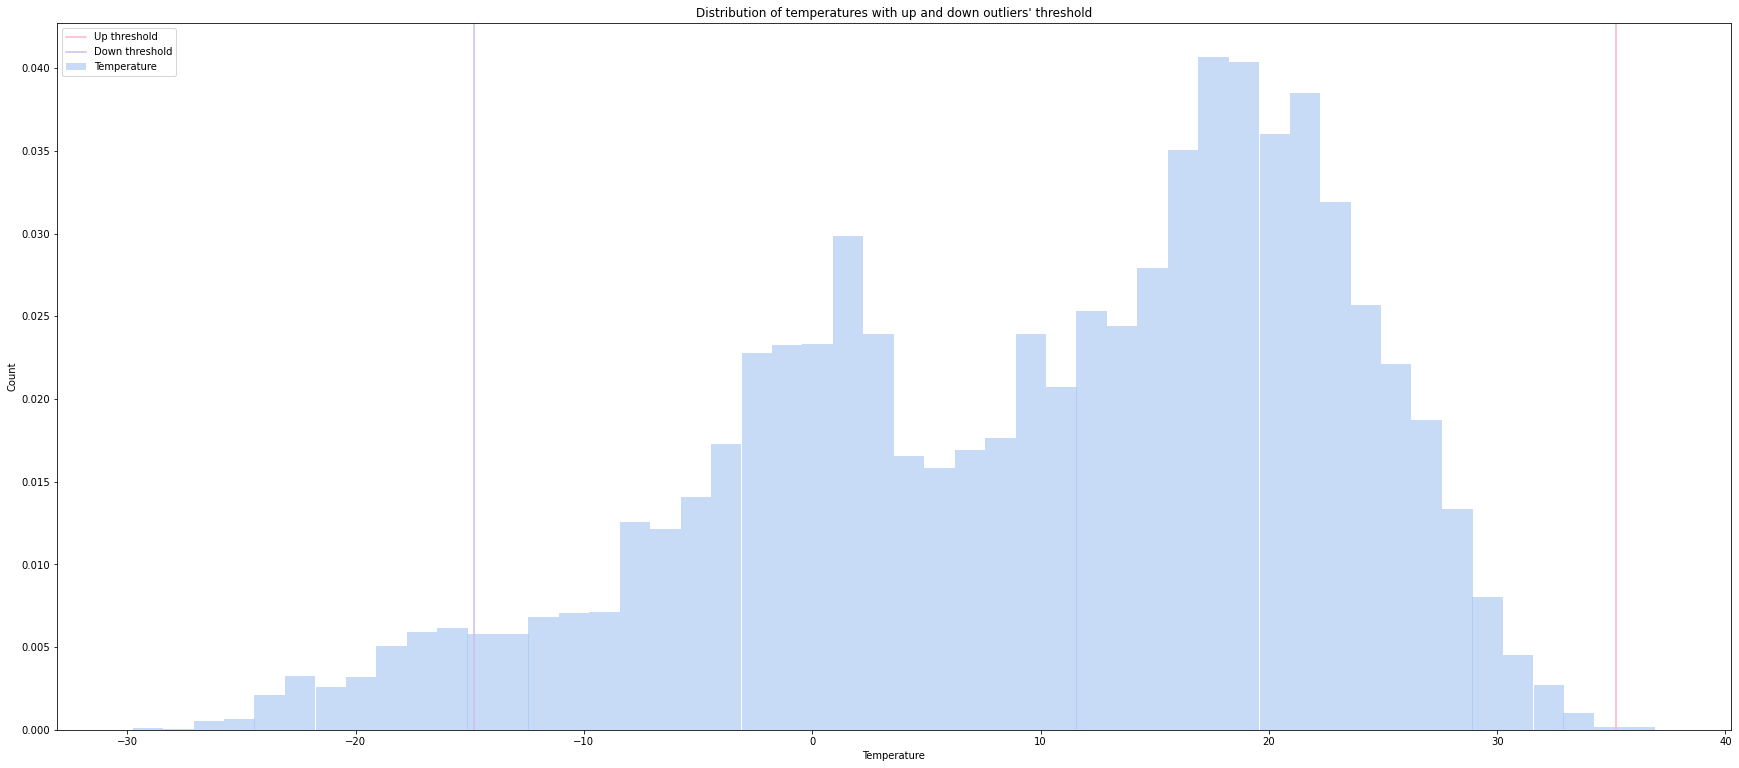

In [38]:
# statistics
mean = (sum(data["temp"])/data["temp"].shape[0])
std = (np.sqrt(sum((data["temp"]-mean)**2) / data["temp"].shape[0]))

# fix threshold
up_threshold = (mean + (2*std))
down_threshold = (mean - (2*std))

fig = plt.figure(figsize=(30, 13))
plt.subplot(1, 1, 1)
plt.hist(data["temp"], color="#A3C4F3", bins=50, density=True, alpha=0.6, label="Temperature")
plt.axvline(x=up_threshold, color="#FFB3C1", label="Up threshold")
plt.axvline(x=down_threshold, color="#CFBAF0", label="Down threshold")
plt.title("Distribution of temperatures with up and down outliers' threshold")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.legend(loc="best")
plt.subplots_adjust(hspace=0.3)
plt.show()

**Comment:**
<p style="text-align: justify">
    We find that the outliers identified by our method are mostly on the left side of the distribution. We have searched the internet and it turns out that Minneapolis / St. Paul is the coldest metropolitan area in the continental United States. The average winter temperature is about -12.2°. January and February are the coldest months, with temperatures around or below -20° being fairly common in these months. Thus, these outliers are not really absurd but are normal weather conditions for the geographical location.
</p>

<h3 style="font-family: Arial">
    <font color="#088A68">
        13) Check missing values
    </font>
</h3>

In [39]:
data.isnull().sum().to_frame(name="Missing value").T

traffic  temp  rain  snow  cloud  date_time  holiday  weather  \
Missing value        0     0     0     0      0          0        0        0   

               weather_description  weekday  ...  rain_win_3  rain_win_6  \
Missing value                    0        0  ...           0           0   

               cloud_win_3  cloud_win_6  hour_norm  hour_sin  hour_cos  \
Missing value            0            0          0         0         0   

               weekday_norm  weekday_sin  weekday_cos  
Missing value             0            0            0  

[1 rows x 51 columns]

<h3 style="font-family: Arial">
    <font color="#088A68">
        14) Reindexing on timestamp
    </font>
</h3>

In [40]:
data.set_index("date_time", inplace=True)

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Exploratory data analysis (EDA)
        </font>
    </h2>
</div>

<h3 style="font-family: Arial">
    <font color="#088A68">
        Univariate & Bivariate analysis
    </font>
</h3>

In [41]:
def plot_eda(data: pd.core.frame.DataFrame, column: str) -> None:
    """
    Method that allows to print subplots.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
        
    column : str
        Column to be plotted.

    Returns
    -------
    None.

    """
    fig = plt.figure(figsize=(30, 13))
    fig.suptitle(f"Data visualization for {column} feature")

    plt.subplot(1, 3, 1)
    sns.countplot(x=column, data=data, palette=my_palette)
    plt.title(f"Distribution of observations by {column}")
    plt.xlabel(f"{column.capitalize()}")
    plt.ylabel("Count")
    plt.xticks(rotation=0)

    plt.subplot(1, 3, 2)
    sns.boxplot(data=data, x=column, y="traffic", width=0.4, palette=my_palette, linewidth=2, showfliers=False)
    plt.title(f"Evolution of traffic volume by {column}")
    plt.xlabel(f"{column.capitalize()}")
    plt.ylabel("Traffic volume")
    plt.xticks(rotation=0)

    plt.subplot(1, 3, 3)
    sns.stripplot(data=data, x=column, y="traffic", color="crimson", linewidth=1, alpha=0.4)
    plt.title(f"Distribution of traffic volume observations by {column}")
    plt.xlabel(f"{column.capitalize()}")
    plt.ylabel("Traffic volume")
    plt.xticks(rotation=0)

    plt.subplots_adjust(hspace=0.3)
    plt.show()

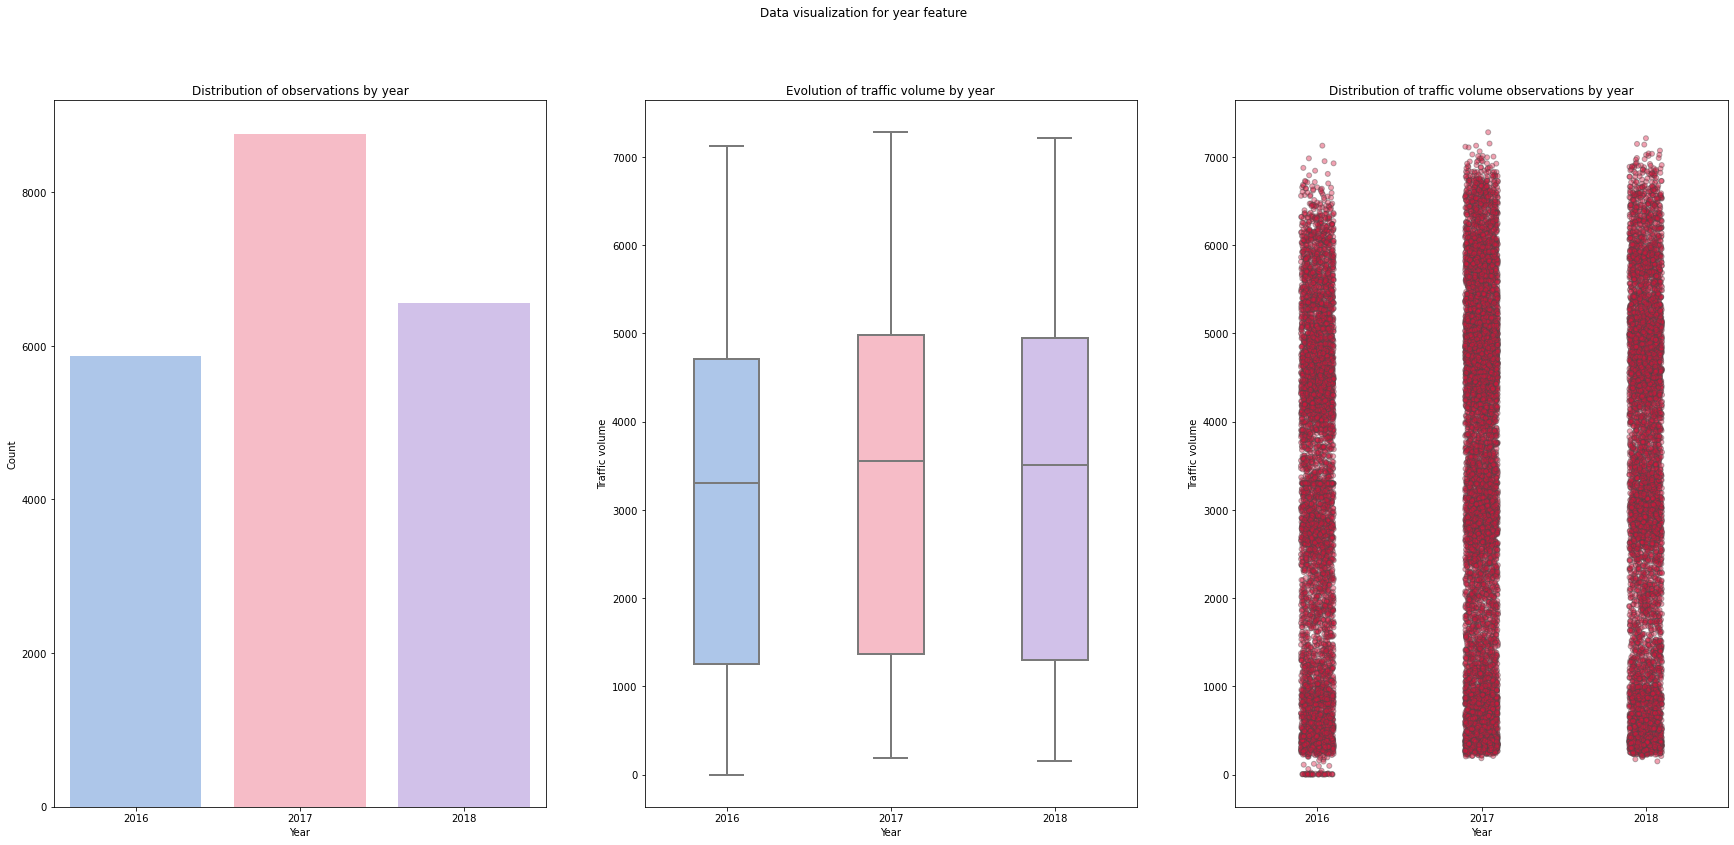

In [42]:
plot_eda(data=data, column="year")

**Comment:**
<p style="text-align: justify">
    We can see that we have much more data for the year 2017, which is normal because it is the only full year among the three observed. In addition, we notice that the volume of road traffic seems rather constant in median over the different years.
</p>

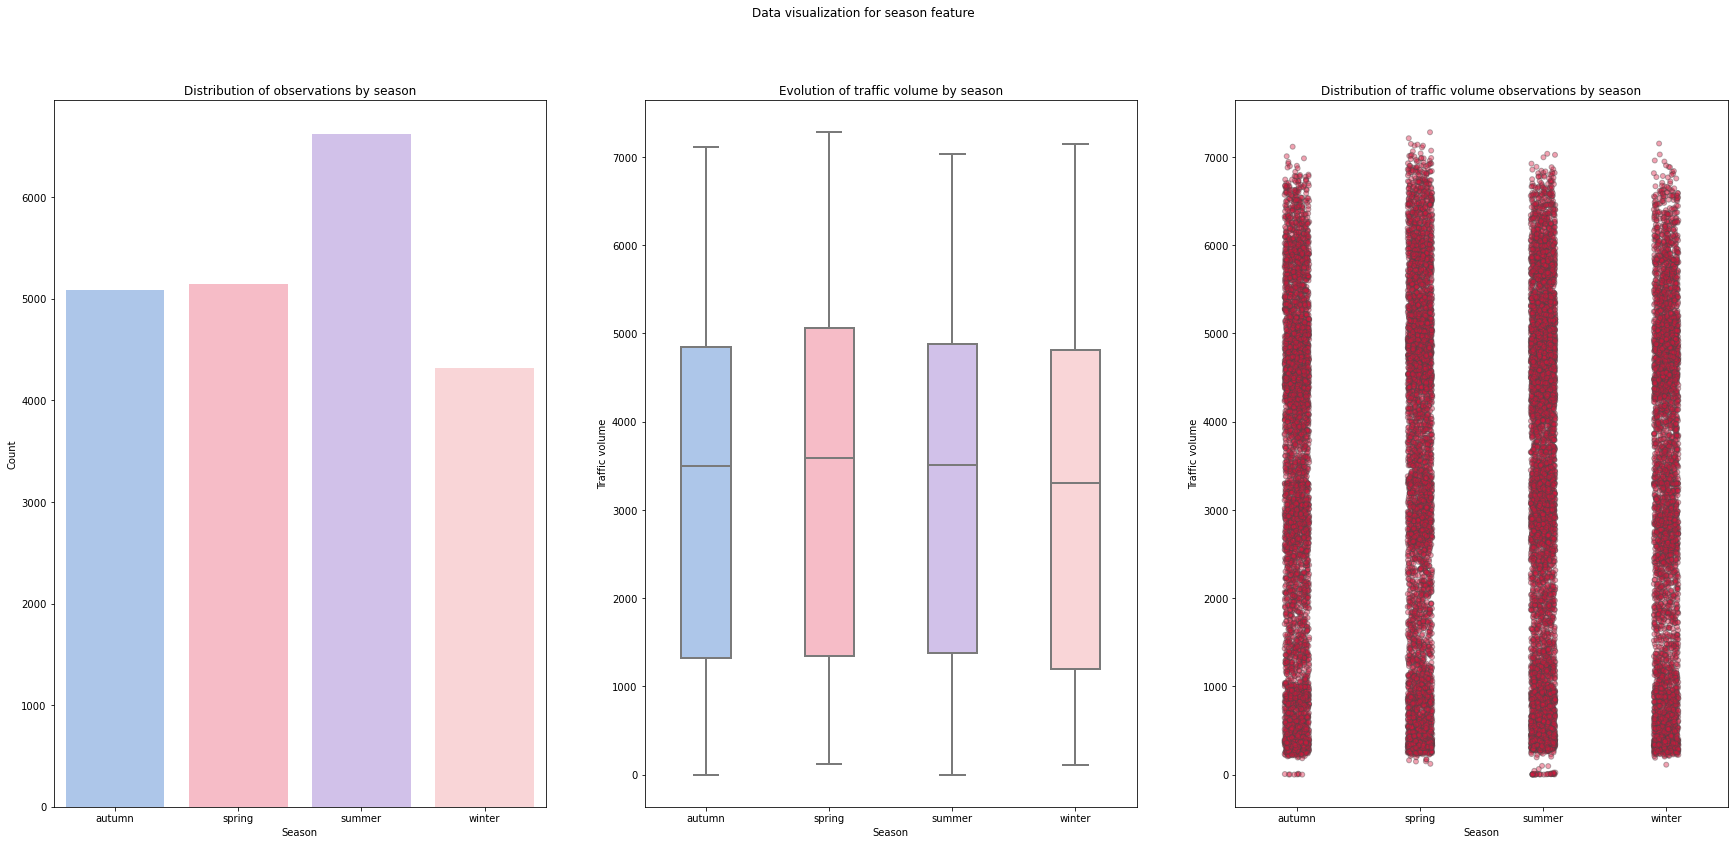

In [43]:
plot_eda(data=data, column="season")

**Comment:**
<p style="text-align: justify">
    On the face of it, we might have expected a different result. Indeed, we might have expected that the volume of road traffic in winter would be much higher than in other seasons. This may be counterbalanced by the fact that we have less data for winter than for the other seasons. In addition, as before, we observe that the volume of road traffic seems to be rather constant in the median over the different seasons.
</p>

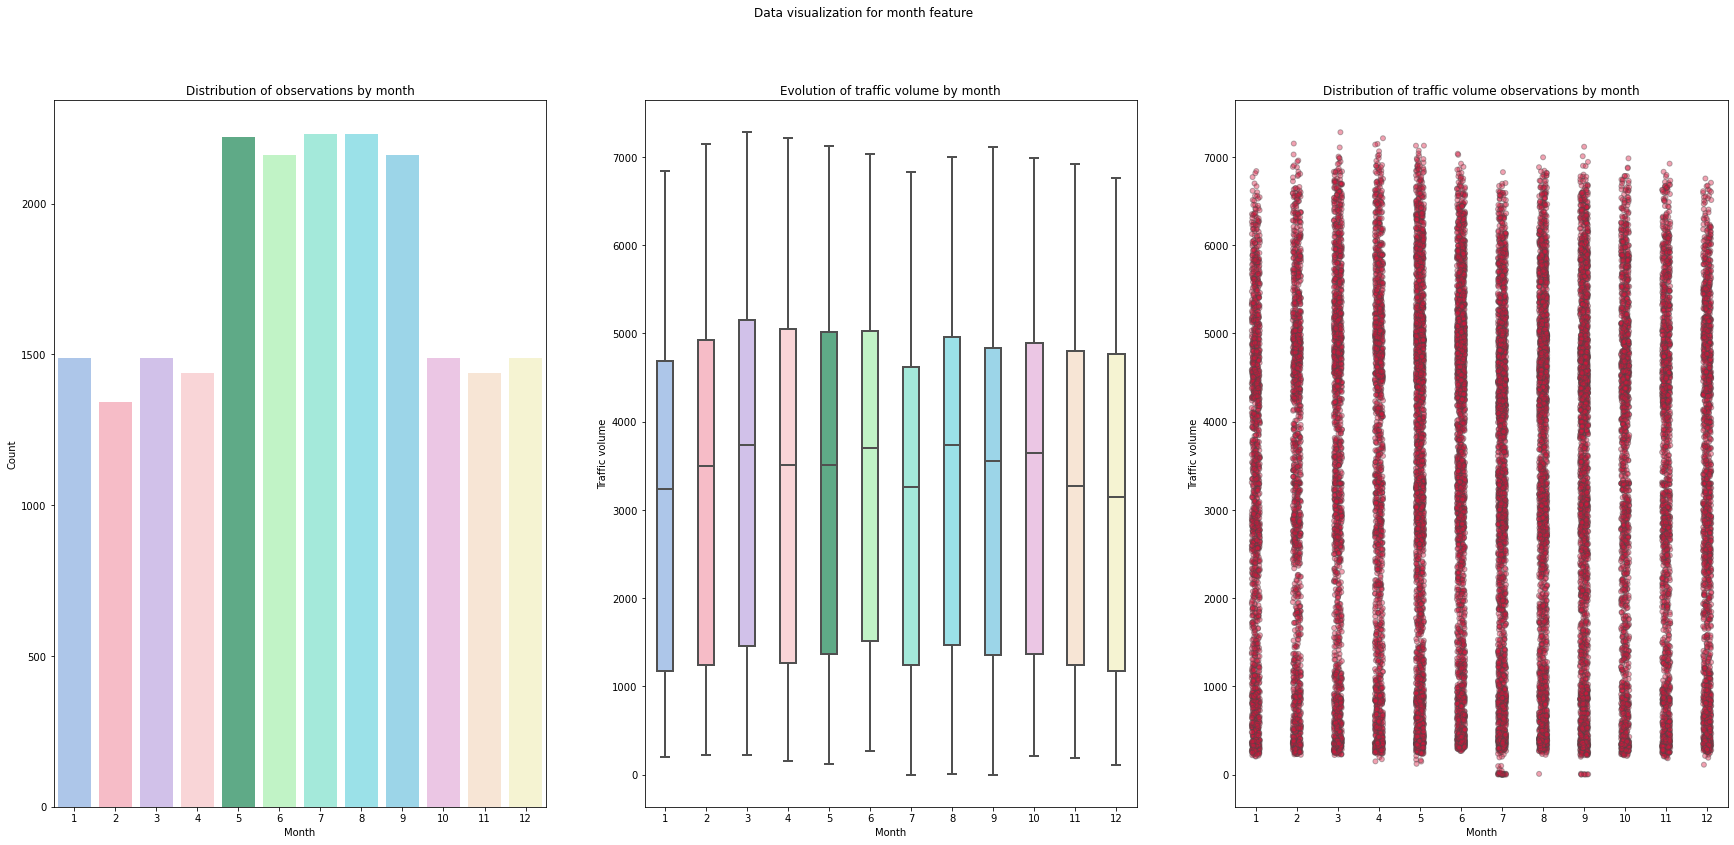

In [44]:
plot_eda(data=data, column="month")

**Comment:**
<p style="text-align: justify">
    We can see that some months have more observations than others since our data set is not composed of three full years. On the other hand, we always observe a certain consistency, on average, of the traffic volume over the months. We can see that in winter (December and January), traffic volume decreases, perhaps because of weather conditions that make travel difficult (snow, ice, etc.). Indeed, Minneapolis / St. Paul is the coldest metropolitan area in the continental United States. Moreover, we notice that in March the volume increases, perhaps because it is the end of winter and therefore the end of complications to move quietly. There is also a clear drop in traffic volume in July, perhaps because it is the summer vacations for the Americans.
</p>

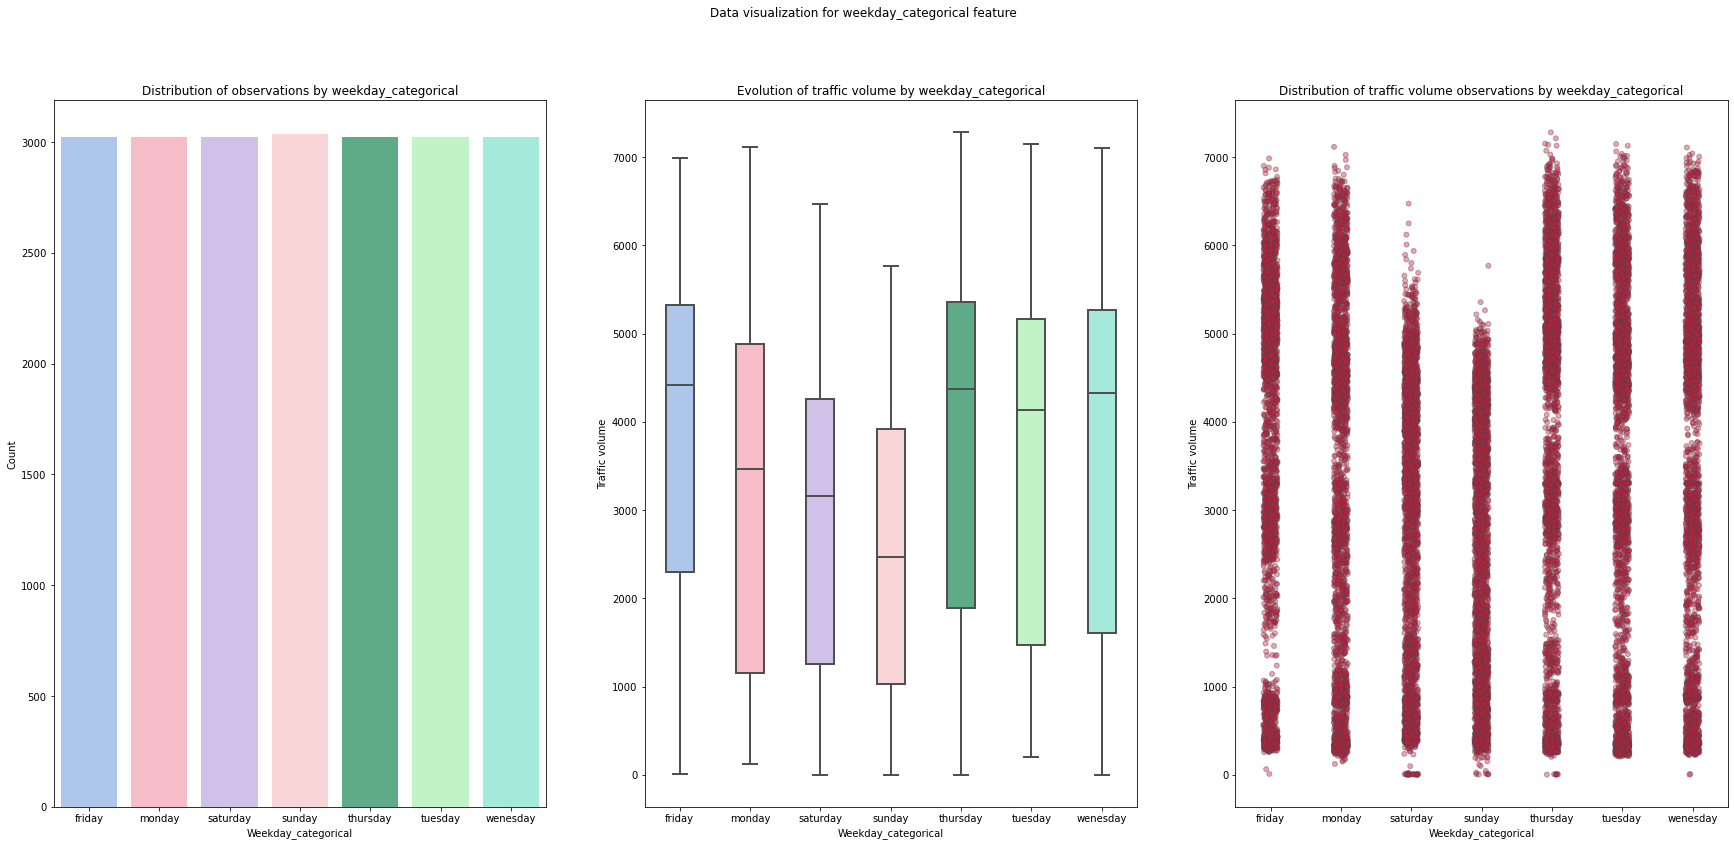

In [45]:
plot_eda(data=data, column="weekday_categorical")

**Comment:**
<p style="text-align: justify">
    Here, it is very clear that on weekends, Saturday and Sunday, we observe a very, very sharp decline in traffic volume. This informs us that these are potentially home/work trips because they take place during the week. Indirectly, this also shows us a certain periodicity that repeats itself each week: increase in volume at the beginning of the week, then decrease at the end of the week, then increase at the beginning of the week, etc.
</p>

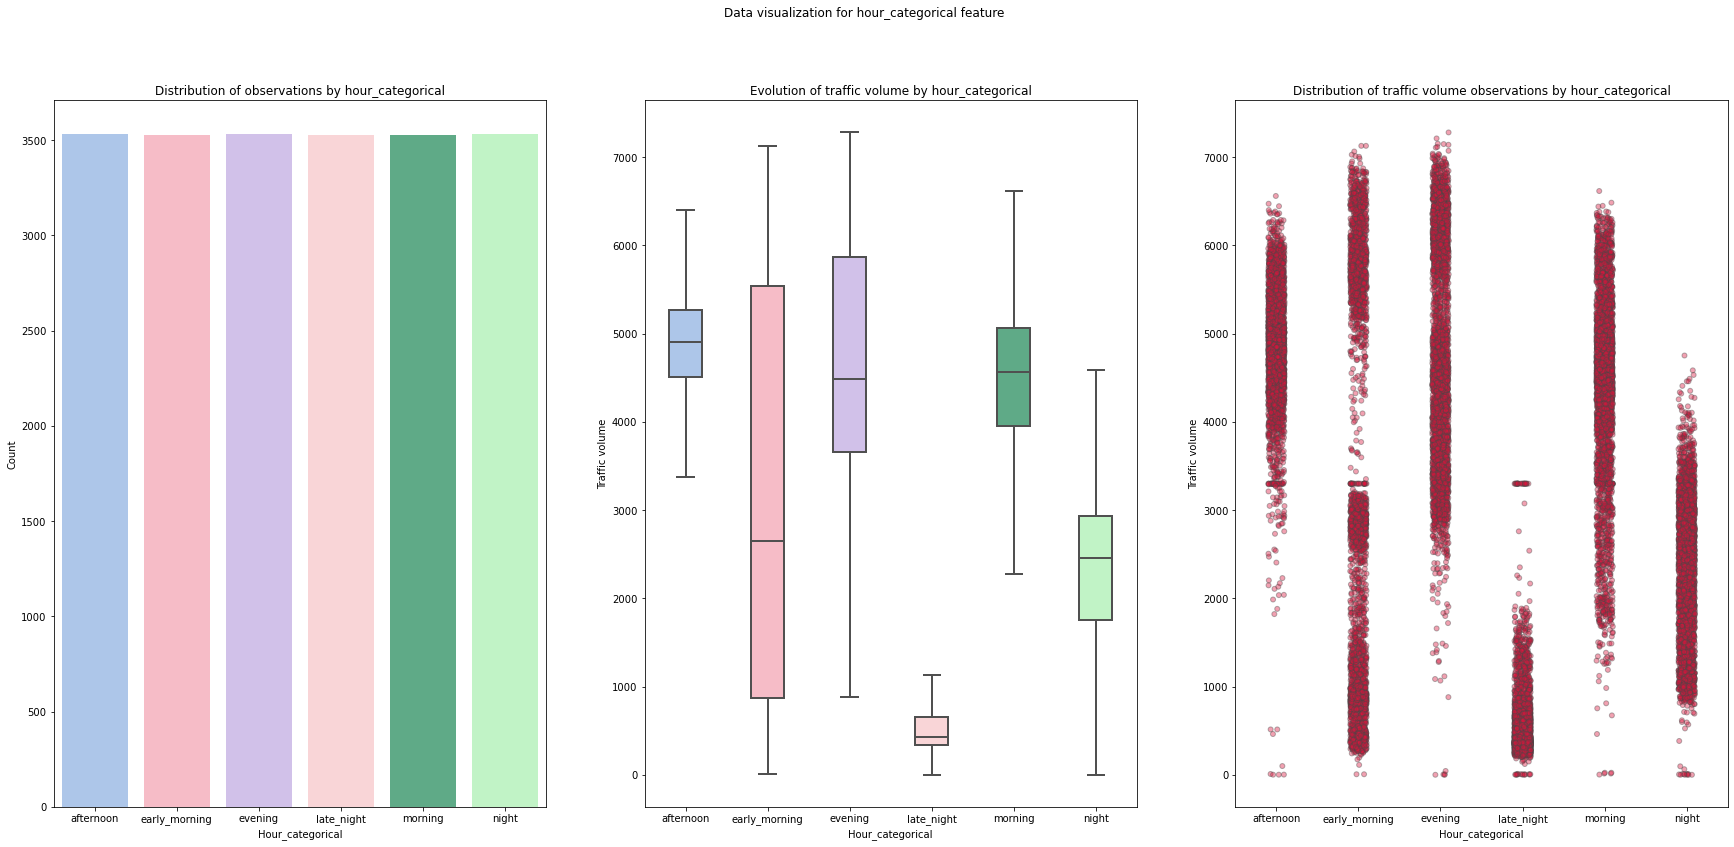

In [46]:
plot_eda(data=data, column="hour_categorical")

**Comment:**
<p style="text-align: justify">
    Overall, the vast majority of trips occur in the morning fairly early, between 4, 5, 6, 7 and 8 o'clock, and in the late afternoon and early evening, between 3, 4, 5, 6 and 7 o'clock. This may confirm our hypothesis of home/work trips. Note, however, that the median traffic volume is relatively high in the mid-afternoon. In contrast, it is very low late at night.
</p>

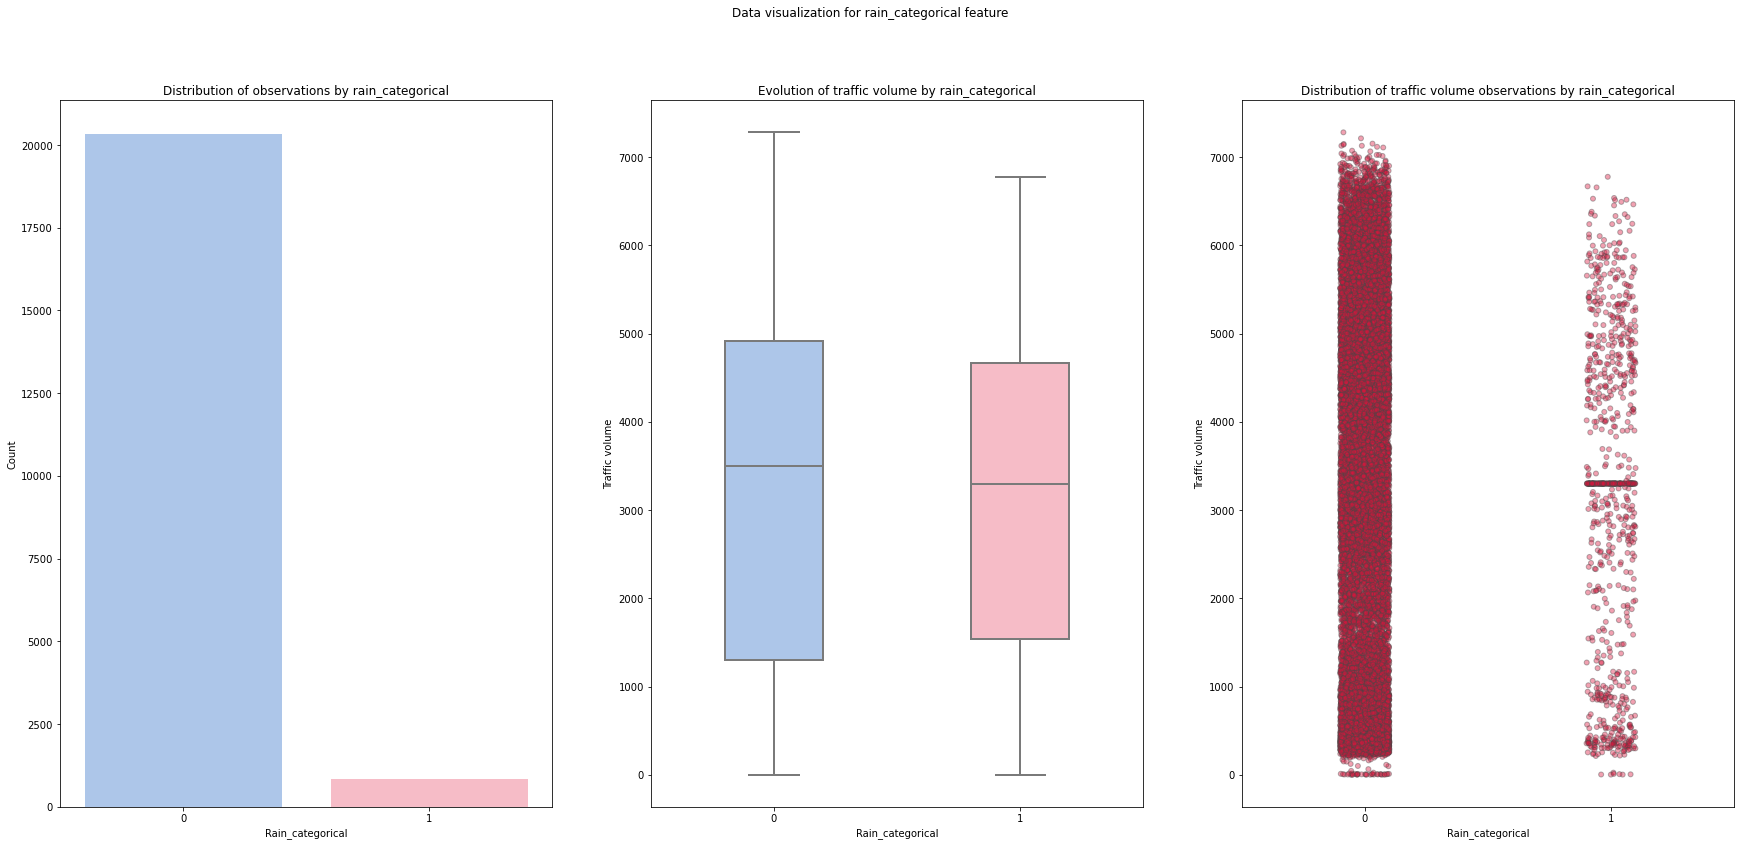

In [47]:
plot_eda(data=data, column="rain_categorical")

**Comment:**
<p style="text-align: justify">
    We can see that for the majority of the days observed, it rarely rained. Thus, the comparison of traffic volume between days with and without rain should be taken with caution.
</p>

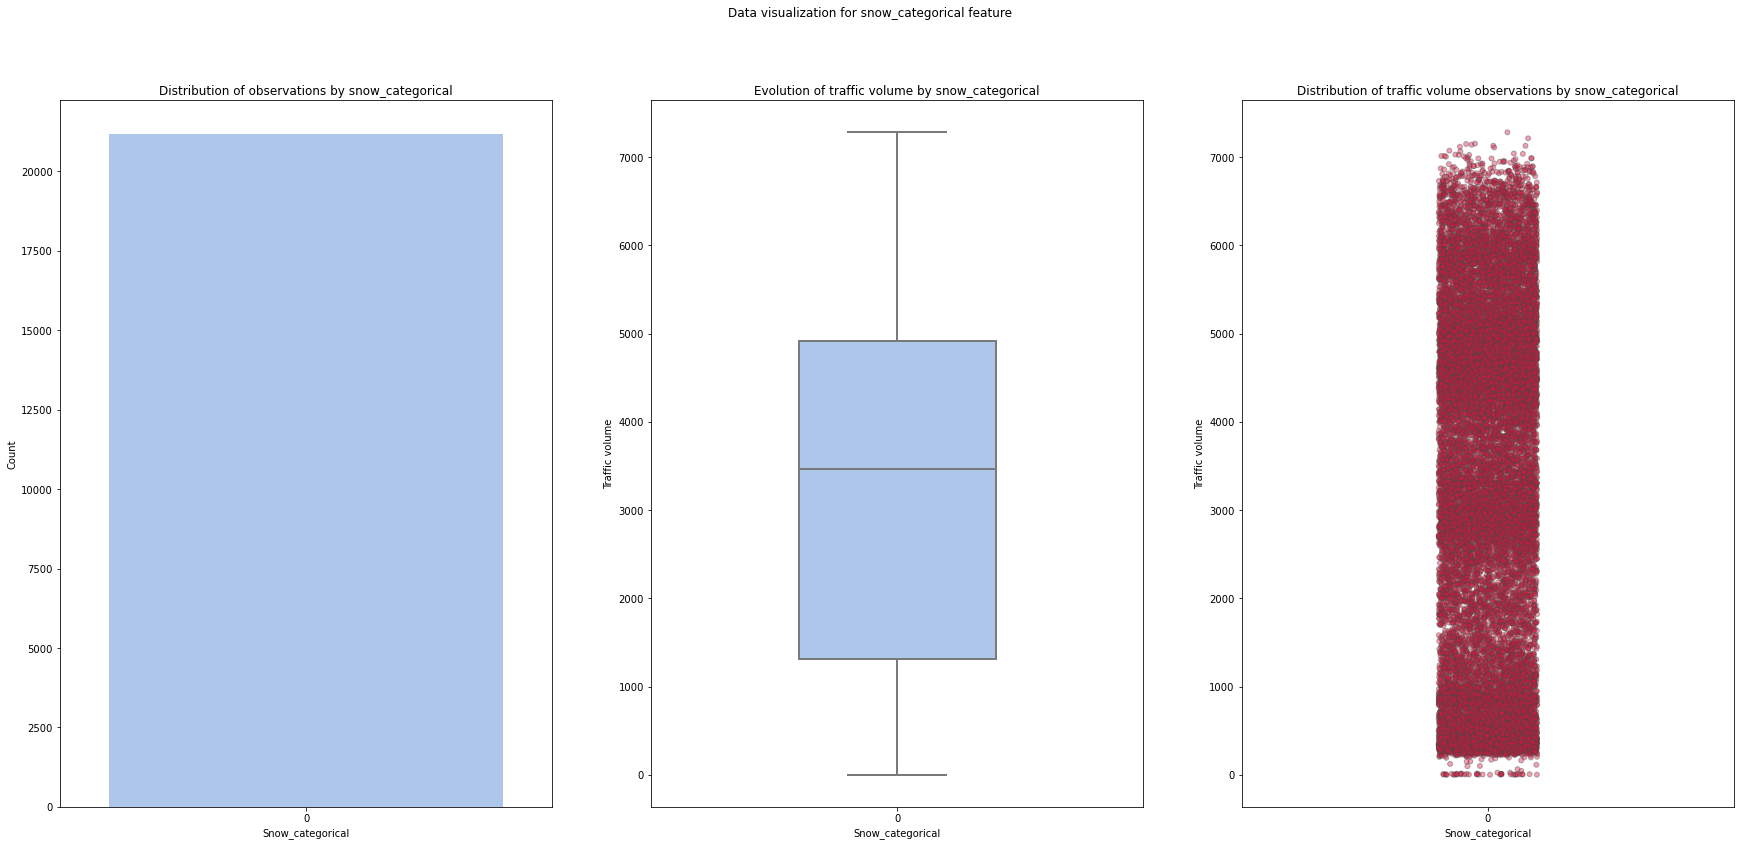

In [48]:
plot_eda(data=data, column="snow_categorical")

**Comment:**
<p style="text-align: justify">
    Since we have shortened the database, we do not have any days for which it snowed in our data set.
</p>

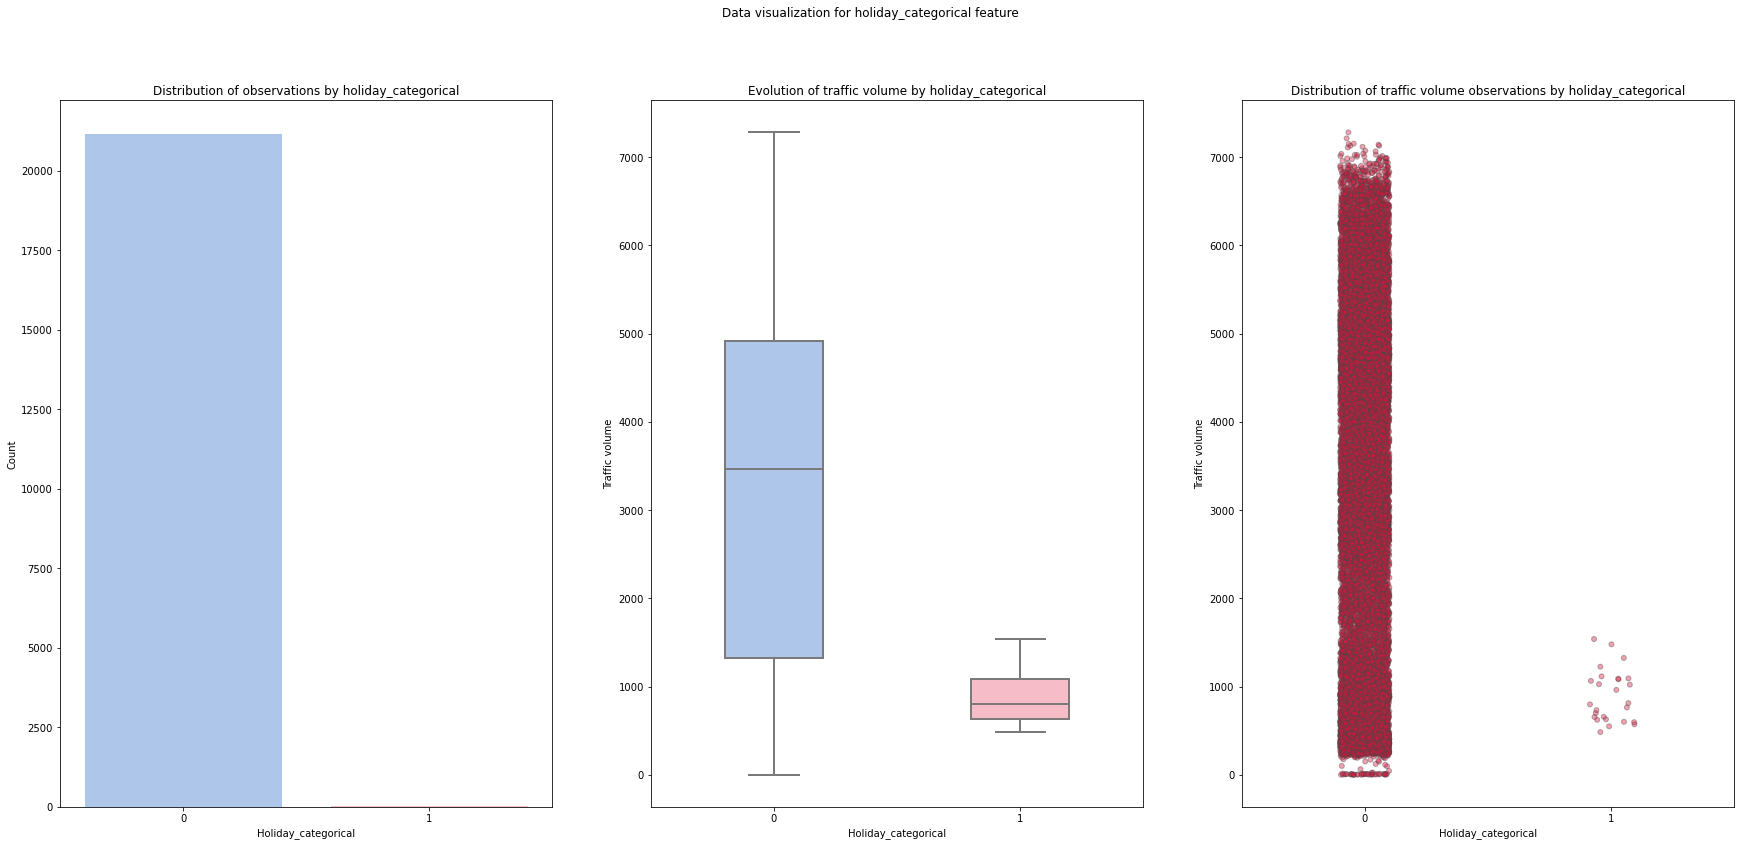

In [49]:
plot_eda(data=data, column="holiday_categorical")

**Comment:**
<p style="text-align: justify">
    As mentioned earlier, we have very few holidays in our dataset. Thus, this variable is not really representative of its explanatory power on the volume of road traffic. The fact that we have very few holiday observations justifies the fact that we have binarized this variable rather than keeping the multiple modalities.
</p>

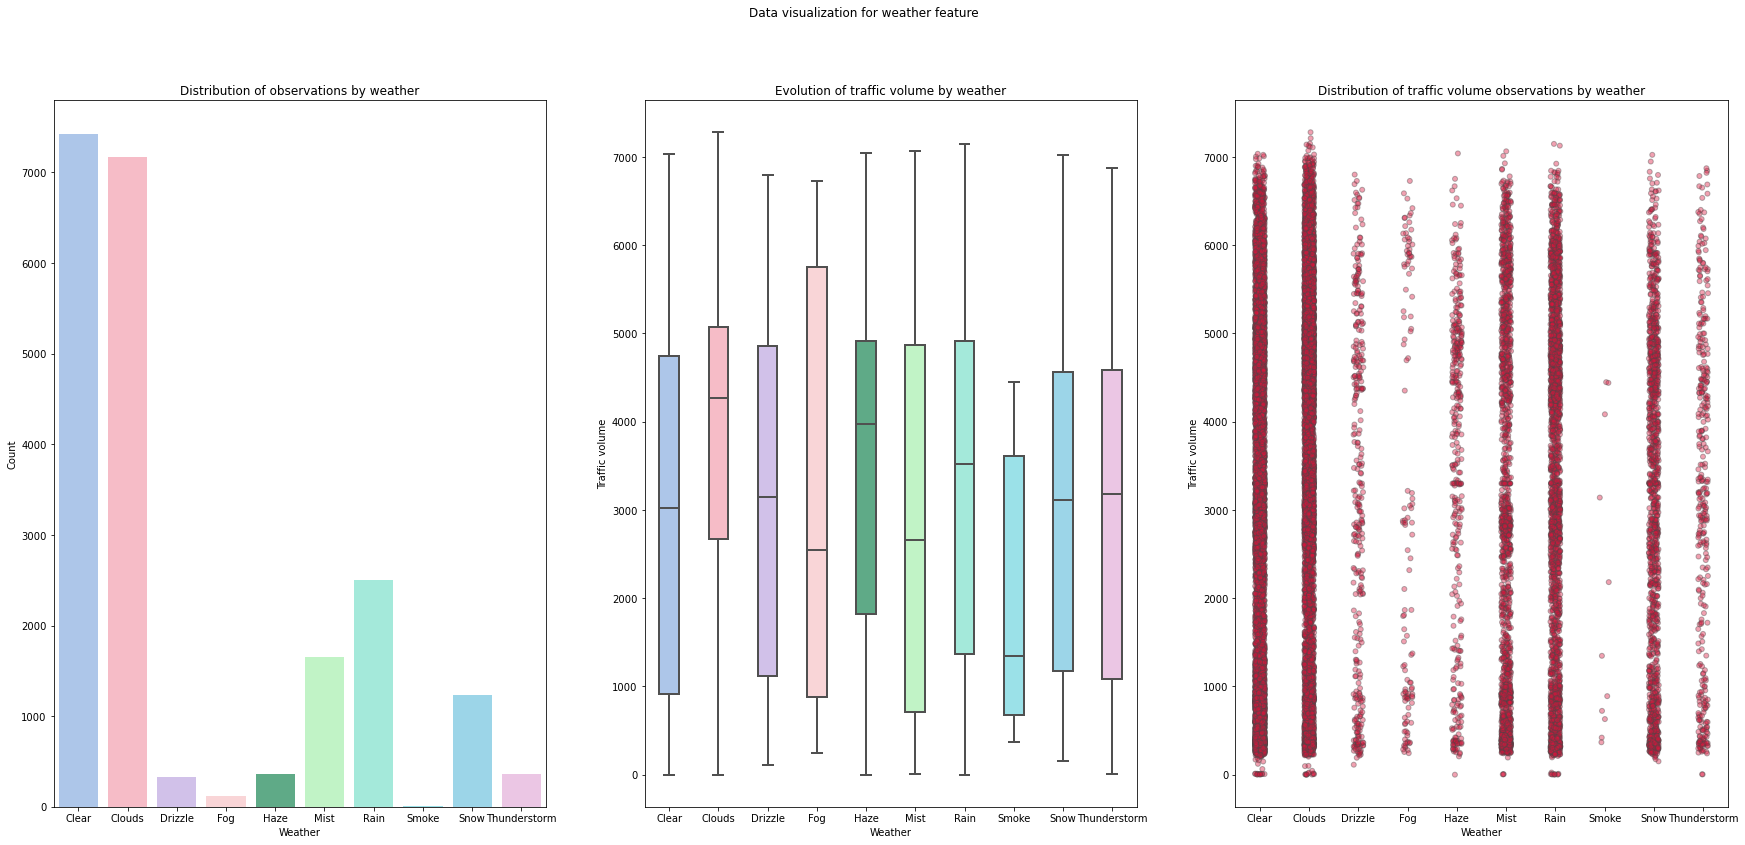

In [50]:
plot_eda(data=data, column="weather")

**Comment:**
<p style="text-align: justify">
    Similarly, our interpretations here should be taken with caution given the difference in observations for each modality. On the other hand, we can see that the median road traffic volume is very low on fog/fog days. On the other hand, for days with good weather, we can see that the median volume is similar to that of other weather conditions. This is quite normal since we have many days / hours when the weather is good which is not the case for example when there are thunderstorms.
</p>

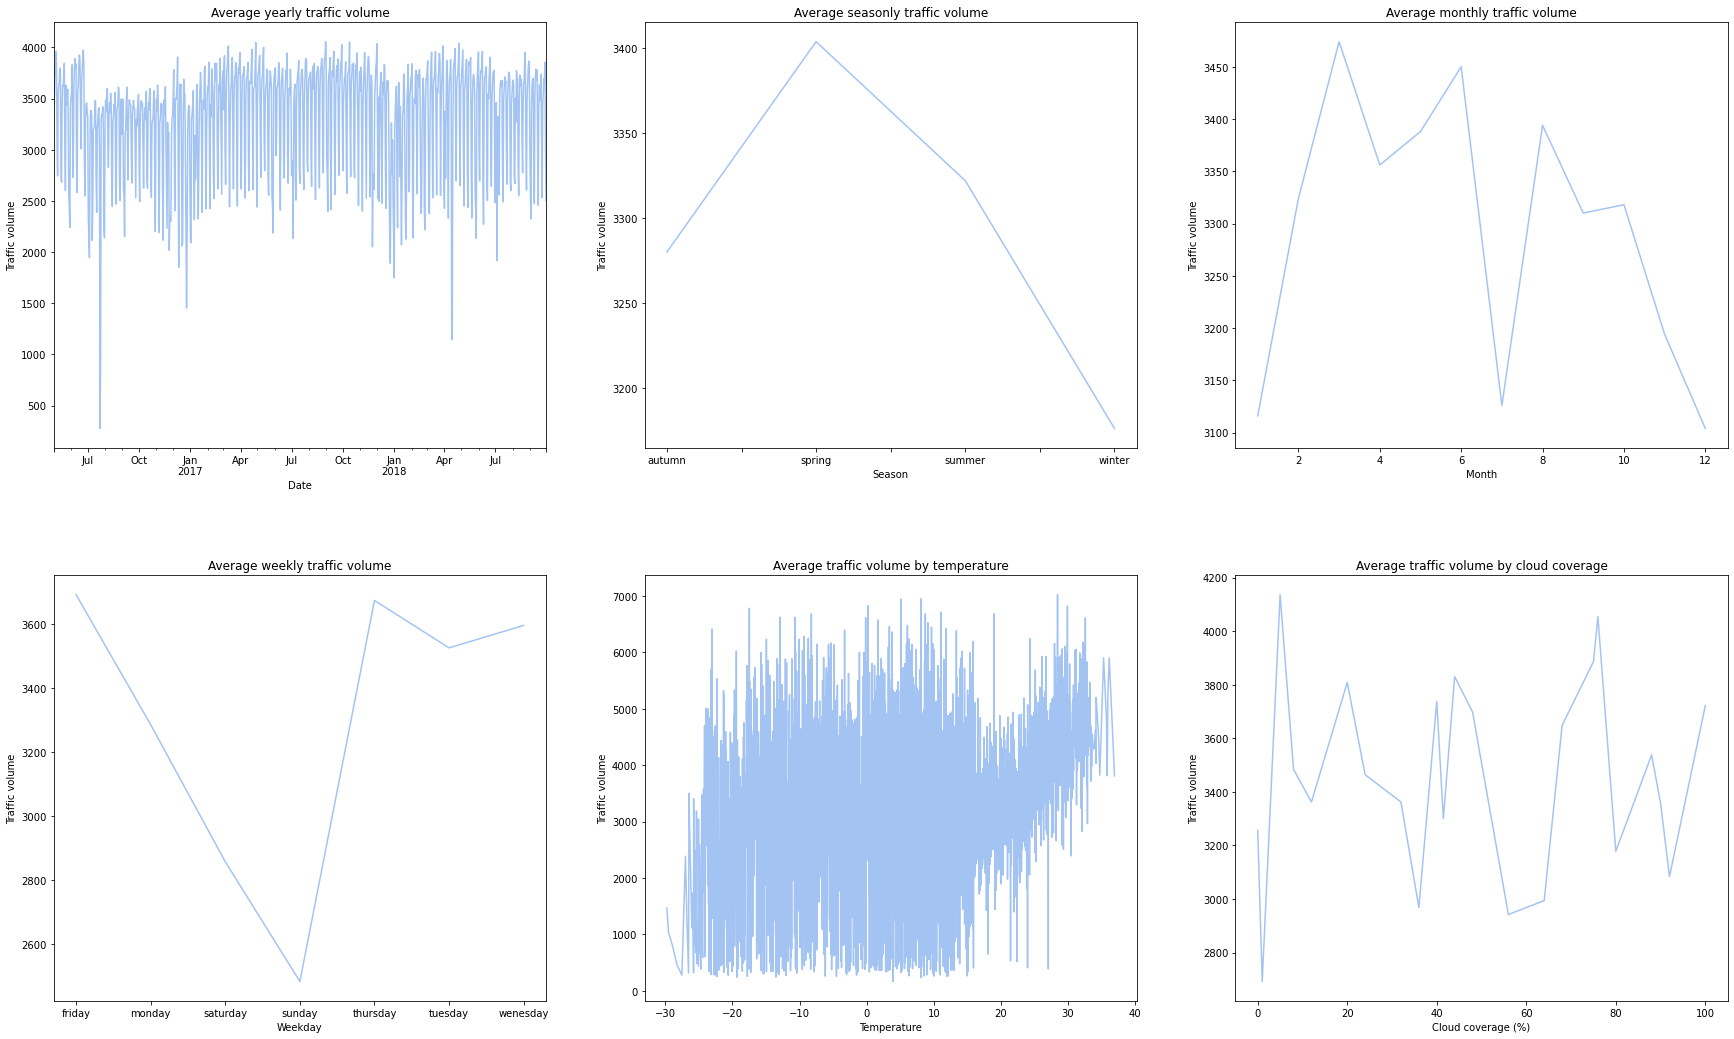

In [51]:
fig = plt.figure(figsize=(30, 18))

# line 1
plt.subplot(2, 3, 1)
data.groupby("date").mean()["traffic"].to_frame(name="traffic")["traffic"].plot(label="traffic")
plt.title("Average yearly traffic volume")
plt.xlabel("Date")
plt.ylabel("Traffic volume")
plt.xticks(rotation=0)

plt.subplot(2, 3, 2)
data.groupby("season").mean()["traffic"].to_frame(name="traffic")["traffic"].plot(label="traffic")
plt.title("Average seasonly traffic volume")
plt.xlabel("Season")
plt.ylabel("Traffic volume")
plt.xticks(rotation=0)

# line 2
plt.subplot(2, 3, 3)
data.groupby("month").mean()["traffic"].to_frame(name="traffic")["traffic"].plot(label="traffic")
plt.title("Average monthly traffic volume")
plt.xlabel("Month")
plt.ylabel("Traffic volume")
plt.xticks(rotation=0)

plt.subplot(2, 3, 4)
data.groupby("weekday_categorical").mean()["traffic"].to_frame(name="traffic")["traffic"].plot(label="traffic")
plt.title("Average weekly traffic volume")
plt.xlabel("Weekday")
plt.ylabel("Traffic volume")
plt.xticks(rotation=0)

# line 3
plt.subplot(2, 3, 5)
data.groupby("temp").mean()["traffic"].to_frame(name="traffic")["traffic"].plot(label="traffic")
plt.title("Average traffic volume by temperature")
plt.xlabel("Temperature")
plt.ylabel("Traffic volume")
plt.xticks(rotation=0)

plt.subplot(2, 3, 6)
data.groupby("cloud").mean()["traffic"].to_frame(name="traffic")["traffic"].plot(label="traffic")
plt.title("Average traffic volume by cloud coverage")
plt.xlabel("Cloud coverage (%)")
plt.ylabel("Traffic volume")
plt.xticks(rotation=0)

plt.subplots_adjust(hspace=0.3)
plt.show()

**Comment:**
<p style="text-align: justify">
    First, we do not observe any pro-cyclicality or trend in the volume of traffic recorded. Secondly, as mentioned above, we observe a decrease in traffic volume in July, in winter, and on weekends. Finally, we observe a strong peak in traffic volume when cloud cover is very low. However, as the percentage of cloud cover increases, we do not observe a decrease in volume.
</p>

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Stationarity analysis
        </font>
    </h2>
</div>

**ADF stationarity test:**
<p style="text-align: justify">
    To ensure the stationarity of our series, not useful for Deep Learning but important for the econometric model, we used the Augmented Dickey-Fuller (ADF) statistical test of stationarity. The latter is an extension of the standard Dickey-Fuller test and allows to detect the presence of a unit root for AR(p) processes. In the latter, the lagged test variable is introduced into the regression in order to whiten the residuals (i.e. remove the temporal auto-correlation of the residuals, homoscedasticity). For the variables "temp", "rain_1h", "cloud_all" and "traffic_volume", after checking the Data Generating Process that they follow, the ADF test tells us that they are stationary at only 5%.
</p>

In [52]:
def adf_test(data: pd.core.frame.DataFrame, column: str, maxlag=None, regression: str="c", autolag: str="AIC") -> dict:
    """
    Augmented Dickey-Fuller (ADF) unit root test.
    Function that allows to calculate the statistic and the p-value of the ADF test. As a reminder, 
    the ADF test allows to test the presence of a unit root within the series (e.g. to know if the 
    series is stationary or not).

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
        
    column : str
        Column to be analyzed.
    
    maxlag : {None, int}, optional, default=None
        Maximum lag which is included in test. Maxlag value of 12*(nobs/100)^{1/4} is used when None.
    
    regression : str, {"c", "ct", "ctt", "nc"}, optional, default="c"
        Constant and trend order to include in regression (data generating process).
    
    autolag : str, {"AIC", "BIC", "t-stat", None}, optional, default="AIC"
        Method to use when automatically determining the lag length among the values 0, 1, …, maxlag.

    Returns
    -------
    dict
        ADF test results.
    
    """
    adf = adfuller(data[column], maxlag=maxlag, regression=regression, autolag=autolag, store=False, regresults=False)
    
    return {
            "Statistic": round(adf[0], 4),
            "P-value": round(adf[1], 4),
            "Decision": "H0 accepted (non-stationarity)" if adf[1] > 0.05 else "H0 rejected (stationarity)"
        }

In [53]:
adf_test(data=data, column="traffic", maxlag=None, regression="ct", autolag="AIC")

{'Statistic': -18.5713,
 'P-value': 0.0,
 'Decision': 'H0 rejected (stationarity)'}

In [54]:
adf_test(data=data, column="temp", maxlag=None, regression="c", autolag="AIC")

{'Statistic': -3.7344,
 'P-value': 0.0037,
 'Decision': 'H0 rejected (stationarity)'}

In [55]:
adf_test(data=data, column="rain", maxlag=None, regression="nc", autolag="AIC")

{'Statistic': -145.526,
 'P-value': 0.0,
 'Decision': 'H0 rejected (stationarity)'}

In [56]:
adf_test(data=data, column="cloud", maxlag=None, regression="c", autolag="AIC")

{'Statistic': -15.5185,
 'P-value': 0.0,
 'Decision': 'H0 rejected (stationarity)'}

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Save the cleaned dataset
        </font>
    </h2>
</div>

In [57]:
keep_columns = [
    "year", "date", "traffic", "holiday_categorical", "temp", "rain", "cloud",
    "temp_lag_1", "temp_lag_2", "temp_lag_3", "temp_lag_6", 
    "rain_lag_1", "rain_lag_2", "rain_lag_3", "rain_lag_6", 
    "cloud_lag_1", "cloud_lag_2", "cloud_lag_3", "cloud_lag_6", 
    "traffic_lag_1", "traffic_lag_2", "traffic_lag_3", "traffic_lag_6",
    "temp_avg", "rain_avg", "cloud_avg",
    "temp_win_3", "temp_win_6",
    "rain_win_3", "rain_win_6", 
    "cloud_win_3", "cloud_win_6",
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos"
]

In [58]:
data = data[keep_columns]

data.shape

(21181, 36)

In [59]:
data.to_pickle("interstate_traffic.pkl")

In [60]:
del data

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Tools box
        </font>
    </h2>
</div>

**Implementation of the different metrics:**
<p style="text-align: justify">
    In order to better control and measure the performance of our models, we implement different metrics. These metrics will serve us throughout our project, especially the RMSE on which we rely as an evaluation metric. That is to say that it is against this metric that we select the variables in order to find the best model and that we will determine and conclude which final model will be the most adequate to our data set and the most accurate in its estimates. Why choose the RMSE? The RMSE is an easily interpretable evaluation metric, comparable to the target and less biased. It is possible to criticize our choice since the RMSE gives more importance to the highest errors, which can be the case when we have a lot of outliers in our data set. Hence the need to properly calibrate our models.
</p>

In [61]:
class Metrics:
    def __init__(self, y_true, y_pred) -> None:
        """
        Class allows to implement all several metrics use to measure the predictive
        capabilities of a regression model in and out-of-sample.

        Parameters
        ----------
        y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Ground truth (correct) target values.
            
        y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Estimated target values.

        Raises
        ------
        TypeError
            - y_true parameter must be a ndarray or series to use the functions
            associated with the Metrics class.
            
            - y_pred parameter must be a ndarray or series to use the functions
            associated with the Metrics class.
            
        ValueError
            y_true and y_pred must have the same shape to use the functions associated
            with the Metrics class.

        Returns
        -------
        None.

        """
        if y_true.shape[0] == y_pred.shape[0]:
            
            if isinstance(y_true, pd.core.series.Series) or isinstance(y_true, np.ndarray)\
            or isinstance(y_true, pd.core.frame.DataFrame):
                    
                self.y_true = y_true
            else:
                raise TypeError(
                    f"'y_true' parameter must be a ndarray or series: got {type(y_true)}"
                )

            if isinstance(y_pred, pd.core.series.Series) or isinstance(y_pred, np.ndarray)\
            or isinstance(y_pred, pd.core.frame.DataFrame):
                self.y_pred = y_pred
            else:
                raise TypeError(
                    f"'y_pred' parameter must be a ndarray or series: got {type(y_pred)}"
                )
                
        
        else:
            raise ValueError(
                "'y_true' and 'y_pred' parameters must have the same shape"
                )
    
    
    def mse(self) -> float:
        """
        Function to compute the Mean Squared Error (MSE) regression loss.

        Returns
        -------
        float
            A non-negative floating point value (the best value is 0.0) which corresponds
            to the loss value of the MSE.

        """
        mse = ((1/self.y_pred.shape[0]) * np.sum((np.array(self.y_true)\
                                               -np.array(self.y_pred))**2))
        
        return float(mse)
    
    
    def rmse(self) -> float:
        """
        Function to compute the Root Mean Squared Error (RMSE) regression loss.

        Returns
        -------
        float
            A non-negative floating point value (the best value is 0.0) which corresponds
            to the loss value of the RMSE.

        """
        rmse = np.sqrt((1/self.y_pred.shape[0]) * np.sum((np.array(self.y_true)\
                                                       -np.array(self.y_pred))**2))
        
        return float(rmse)
    
    
    def mae(self) -> float:
        """
        Function to compute the Mean Absolute Error (MAE) regression loss.

        Returns
        -------
        float
            A non-negative floating point value (the best value is 0.0) which corresponds
            to the loss value of the MAE.

        """
        mae = ((1/self.y_pred.shape[0]) * np.sum(np.abs(self.y_true-self.y_pred)))
        
        return float(mae)
    
    
    def mape(self) -> float:
        """
        Function to compute the Mean Absolute Percentage Error (MAPE) regression loss.

        Returns
        -------
        float
            A non-negative floating point value (the best value is 0.0) which corresponds
            to the loss value of the MAPE.

        """
        mape = ((100/self.y_pred.shape[0]) * np.sum(np.abs((self.y_true-self.y_pred)/self.y_true)))
        
        return float(mape)

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Features selection
        </font>
    </h2>
</div>

<p style="text-align: justify">
    Our goal is to design a model that is adapted and robust. To do so, we cannot provide it with just any input. This is the purpose of this selection step: to perform a dimension reduction in order to select the variables of our dataset. We will break down our selection into two complementary phases. Note that the variables are all standardized so that they have the same scale within the selection phases but also within the trained models.
</p>

In [62]:
data = pd.read_pickle(filepath_or_buffer="interstate_traffic.pkl")

data.shape

(21181, 36)

In [63]:
# cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [64]:
# different scaler for input and output
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

<h3 style="font-family: Arial">
    <font color="#088A68">
        1) Train test split
    </font>
</h3>

In [65]:
# split train valid test split
train = data.iloc[:round(data.shape[0]*0.7)]
valid = data.iloc[round(data.shape[0]*0.7):round(data.shape[0]*0.8)]
test = data.iloc[round(data.shape[0]*0.8):]

train.shape, valid.shape, test.shape

((14827, 36), (2118, 36), (4236, 36))

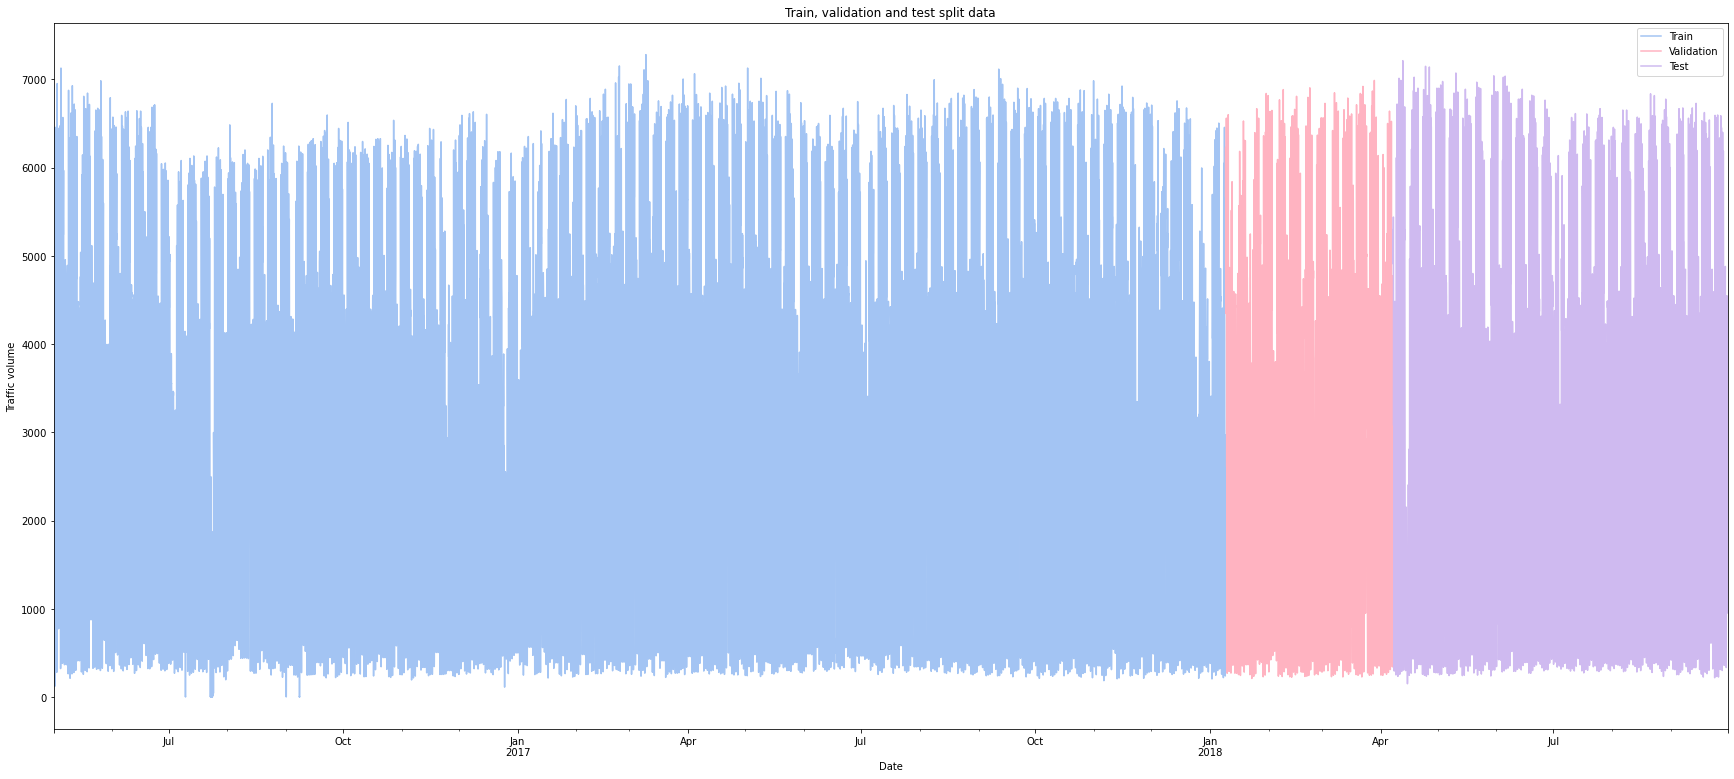

In [66]:
fig = plt.figure(figsize=(30, 13))
plt.subplot(1, 1, 1)
train["traffic"].plot(label="Train")
valid["traffic"].plot(label="Validation")
test["traffic"].plot(label="Test")
plt.title("Train, validation and test split data")
plt.xlabel("Date")
plt.ylabel("Traffic volume")
plt.legend(loc="best")
plt.xticks(rotation=0)
plt.subplots_adjust(hspace=0.3)
plt.show()

<h3 style="font-family: Arial">
    <font color="#088A68">
        2) Features can improve model's accuracy ? (with baseline model)
    </font>
</h3>

**First selection of variables:**
<p style="text-align: justify">
    The first selection step aims to build groups of features: initial variables without transformation, delayed variables, variables transformed by mean target encoding, variables transformed in mean rolling window and variables transformed with cyclical encoding. The idea is very simple, to estimate several combinations of groups of variables in order to see if the addition or deletion of a group increases or decreases, in a significant way, the predictive quality of a simple linear regression.
</p>

In [67]:
# initial features
initial_features = list(data.columns[3:7])

# lagged features
lagged_features = list(data.columns[7:23])

# average features
average_features = list(data.columns[23:26])

# rolling mean feature
rollmean_features = list(data.columns[26:32])

# cyclical encoding timestamp
timestamp_features = list(data.columns[32:36])

# dictionnary with different steps
dict_features = {
    "STEP_1": initial_features,
    "STEP_2": initial_features+lagged_features,
    "STEP_3": initial_features+average_features,
    "STEP_4": initial_features+timestamp_features,
    "STEP_5": initial_features+rollmean_features,
    "STEP_6": initial_features+lagged_features+average_features,
    "STEP_7": initial_features+lagged_features+timestamp_features,
    "STEP_8": initial_features+lagged_features+rollmean_features,
    "STEP_9": initial_features+average_features+timestamp_features,
    "STEP_10": initial_features+average_features+rollmean_features,
    "STEP_11": initial_features+rollmean_features+timestamp_features,
    "STEP_12": initial_features+lagged_features+average_features+rollmean_features,
    "STEP_13": initial_features+lagged_features+average_features+timestamp_features,
    "STEP_14": initial_features+lagged_features+average_features+rollmean_features+timestamp_features
}

list_steps = [
    "STEP_1",
    "STEP_2",
    "STEP_3",
    "STEP_4",
    "STEP_5",
    "STEP_6",
    "STEP_7",
    "STEP_8",
    "STEP_9",
    "STEP_10",
    "STEP_11",
    "STEP_12",
    "STEP_13",
    "STEP_14"
]

list_steps_name = [
    "Initial",
    "Initial + Lagged",
    "Initial + Average",
    "Initial + Cyclical",
    "Initial + Rolling",
    "Initial + Lagged + Average",
    "Initial + Lagged + Cyclical",
    "Initial + Lagged + Rolling",
    "Initial + Average + Cyclical",
    "Initial + Average + Rolling",
    "Initial + Rolling + Cyclical",
    "Initial + Lagged + Average + Rolling",
    "Initial + Lagged + Average + Cyclical",
    "Initial + Lagged + Average + Rolling + Cyclical"
]

dict_stepsnames = dict(zip(list_steps, list_steps_name))

In [68]:
# dataframe with informations of each step
df = pd.DataFrame(columns=["Step", "Features", "RMSE", "MAPE"])

# loop with the steps
for step in list_steps:
    
    # split train valid test sets
    X_train, y_train = train[dict_features[step]], train[["traffic"]]
    X_valid, y_valid = valid[dict_features[step]], valid[["traffic"]]
    X_test, y_test = test[dict_features[step]], test[["traffic"]]
    
    # fit the scaler using available training data
    input_scaler = scaler_x.fit(X_train)
    output_scaler = scaler_y.fit(y_train)

    # apply the scaler to training data
    y_train = pd.DataFrame(output_scaler.transform(y_train), index=y_train.index, columns=y_train.columns)
    X_train = pd.DataFrame(input_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

    # apply the scaler to training data
    y_valid = pd.DataFrame(output_scaler.transform(y_valid), index=y_valid.index, columns=y_valid.columns)
    X_valid = pd.DataFrame(input_scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

    # apply the scaler to test data
    y_test = pd.DataFrame(output_scaler.transform(y_test), index=y_test.index, columns=y_test.columns)
    X_test = pd.DataFrame(input_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    # model
    linear_reg = LinearRegression(
        fit_intercept=True,
        normalize="deprecated",
        copy_X=True,
        n_jobs=-1,
        positive=False
    )

    linear_reg.fit(X_train, y_train)
    
    rmse = Metrics(
        y_true=pd.DataFrame(
            scaler_y.inverse_transform(y_test),
            columns=["traffic"]
        ),
        y_pred=pd.DataFrame(
            scaler_y.inverse_transform(linear_reg.predict(X_test).reshape(-1, 1)),
            columns=["traffic"]
        )
    ).rmse()
    
    mape = Metrics(
        y_true=pd.DataFrame(
            scaler_y.inverse_transform(y_test),
            columns=["traffic"]
        ),
        y_pred=pd.DataFrame(
            scaler_y.inverse_transform(linear_reg.predict(X_test).reshape(-1, 1)),
            columns=["traffic"]
        )
    ).mape()
    
    # save informations
    df = df.append(
        dict(
            zip(
                df.columns,
                [
                    step,
                    dict_features[step],
                    rmse,
                    mape
                ]
            )
        ),
        ignore_index=True
    )
    
    print(f"---- {step}")
    print(f"Features: {dict_stepsnames[step]}")
    print(f"RMSE: {round(rmse, 4)}")
    print(f"MAPE: {round(mape, 4)}")
    
    del linear_reg, X_train, y_train, X_test, y_test, X_valid, y_valid, rmse, input_scaler, output_scaler

---- STEP_1
Features: Initial
RMSE: 1919.0158
MAPE: 162.7593
---- STEP_2
Features: Initial + Lagged
RMSE: 550.545
MAPE: 23.5546
---- STEP_3
Features: Initial + Average
RMSE: 1643.0593
MAPE: 122.6338
---- STEP_4
Features: Initial + Cyclical
RMSE: 1140.7925
MAPE: 62.7208
---- STEP_5
Features: Initial + Rolling
RMSE: 1582.4946
MAPE: 118.548
---- STEP_6
Features: Initial + Lagged + Average
RMSE: 547.1427
MAPE: 24.0559
---- STEP_7
Features: Initial + Lagged + Cyclical
RMSE: 515.9542
MAPE: 23.4761
---- STEP_8
Features: Initial + Lagged + Rolling
RMSE: 550.6842
MAPE: 23.4539
---- STEP_9
Features: Initial + Average + Cyclical
RMSE: 1101.0375
MAPE: 60.0066
---- STEP_10
Features: Initial + Average + Rolling
RMSE: 1451.9448
MAPE: 100.3598
---- STEP_11
Features: Initial + Rolling + Cyclical
RMSE: 1127.0566
MAPE: 62.5927
---- STEP_12
Features: Initial + Lagged + Average + Rolling
RMSE: 547.0942
MAPE: 23.9965
---- STEP_13
Features: Initial + Lagged + Average + Cyclical
RMSE: 514.129
MAPE: 23.8513
--

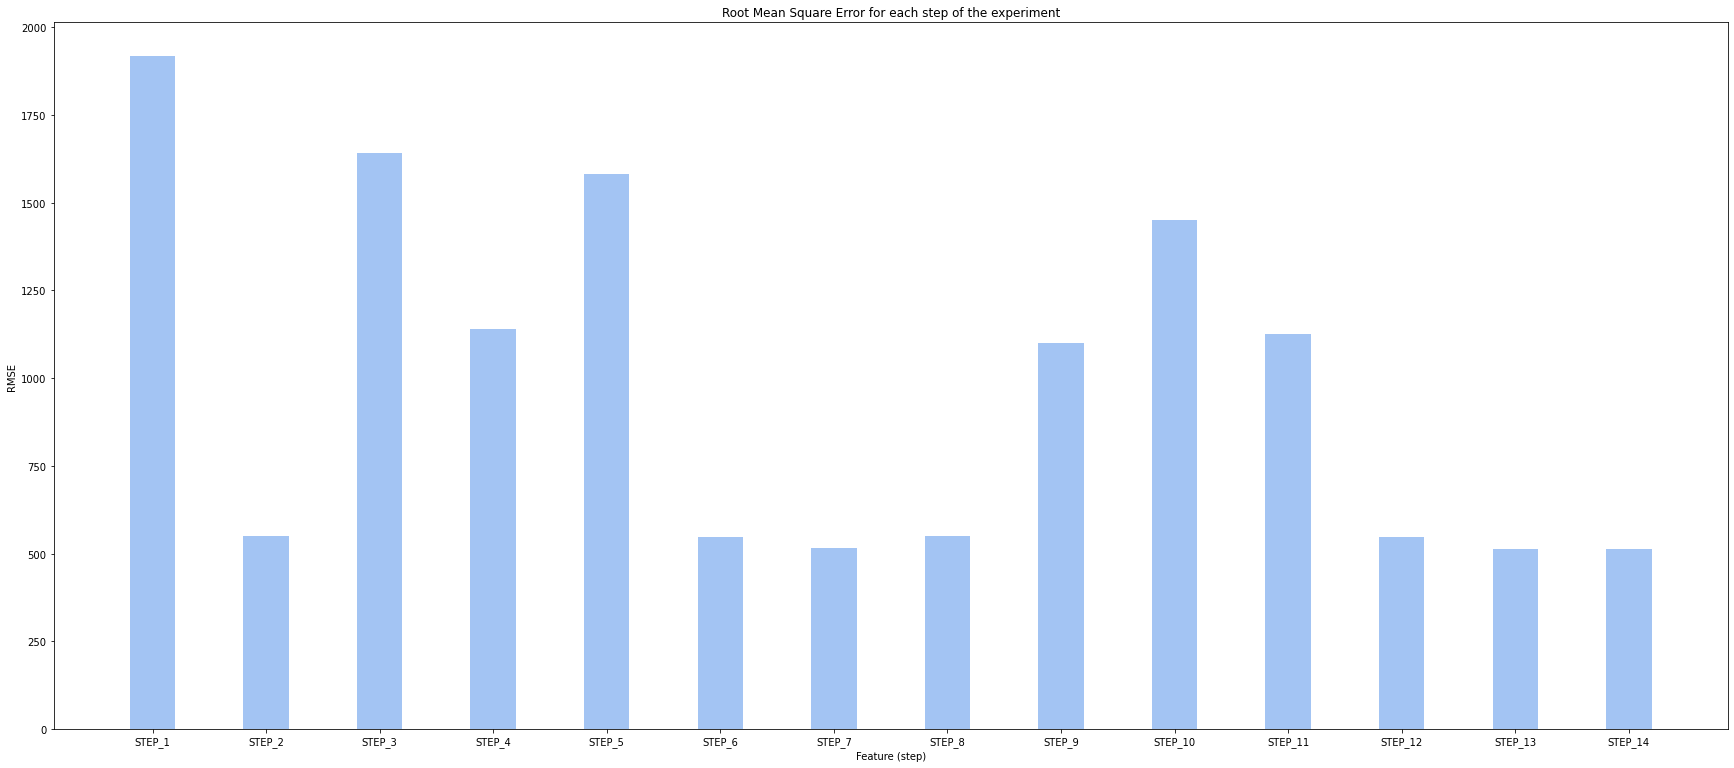

In [69]:
fig = plt.figure(figsize=(30, 13))
plt.subplot(1, 1, 1)
plt.bar(df["Step"], df["RMSE"], width=0.4)
plt.title("Root Mean Square Error for each step of the experiment")
plt.xlabel("Feature (step)")
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.subplots_adjust(hspace=0.3)
plt.show()

<h3 style="font-family: Arial">
    <font color="#088A68">
        3) Improve features selection
    </font>
</h3> 

**Second selection of variables:**
<p style="text-align: justify">
    After finding which groups of variables provide the most information for estimating traffic volume, we enter the second selection step. Indeed, selecting blocks allows us to make a first dimension reduction but we have to make a second one in order to remove some variables, present in the selected blocks, with little explanatory power. To do so, we have been inspired by classical variable selection methods, such as backward, forward, stepwise selection or Bayesian moving averaging, in order to implement, in Python, a technique allowing to build $n$ random combinations of variables (coming from the selected blocks), then to estimate them successively in order to find the best combination of variables, i.e. the one with the best predictive quality, with respect to a given criterion: MAE, MSE, RMSE, MAPE.
</p>

In [70]:
# features from step 7
list_features = initial_features+lagged_features+timestamp_features

In [71]:
# split train data to X and y
X_train, y_train = train[list_features], train[["traffic"]]

# split valid data to X and y
X_valid, y_valid = valid[list_features], valid[["traffic"]]

# split test data to X and y
X_test, y_test = test[list_features], test[["traffic"]]

In [72]:
# fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

In [73]:
# apply the scaler to training data
y_train = pd.DataFrame(output_scaler.transform(y_train), index=y_train.index, columns=y_train.columns)
X_train = pd.DataFrame(input_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

# apply the scaler to training data
y_valid = pd.DataFrame(output_scaler.transform(y_valid), index=y_valid.index, columns=y_valid.columns)
X_valid = pd.DataFrame(input_scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

# apply the scaler to test data
y_test = pd.DataFrame(output_scaler.transform(y_test), index=y_test.index, columns=y_test.columns)
X_test = pd.DataFrame(input_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [74]:
class FeatureSelection:
    def __init__(self, X_train, X_valid, X_test, y_train, y_valid, y_test, scaler, scoring: str="RMSE",
                 n_iter: int=100, min_features=None, y_lag_select=None, random_state: int=42) -> None:
        """
        Class allows to implement a features selection based on several metrics 
        (MAE, MSE, RMSE, MAPE). This selection technique estimates combinations of
        sub-models (like backward, forward, stepwise selection or bayesian moving
        averaging) in order to find the combination of variables (e.g. the model)
        that minimizes a given criterion. In other words, this allows to find the
        model (e.g. the features) that minimizes the estimation errors on the in
        and out-of-sample points, thus the best predictive capacities and the best
        quality of fit.

        Parameters
        ----------
        X_train : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Matrix design values ont the train set (in-sample predictions).
        
        X_valid : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Matrix design values ont the valid set (in-sample predictions).
            
        X_test : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Matrix design values ont the test set (out-of-sample predictions).
            
        y_train : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Target values on the train set (in-sample predictions).
        
        y_valid : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Target values on the valid set (in-sample predictions).
            
        y_test : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Target values on the test set (out-of-sample predictions).
            
        scoring : {"MAE", "MSE", "RMSE", "MAPE"}, str, optional, default="RMSE"
            Metric to minimize or maximize in order to find the best model.
            Default is "RMSE".
            
        n_iter : int, optional, default=100
            Number of iterations corresponding to the number of estimated sub-models.
            Default is 100.
            
        min_features : None or int, optional, default=None
            If random_select=True, this specifies the minimum number of variables 
            in each sub-model. Default is None. If random_select=False,
            then min_features must be None.
            
        y_lag_select : None or list, optional, default=None
            If there are lagged endogenous features in the matrix design, the
            list contains the lag's names of the feature to be explained that
            must be in the model. Default is None.
            Example of use: y_lag_select=["y_lag1", "y_lga2"]
            
        random_state : int, optional, default=42
            Controls the randomness of estimations. Default is 42.

        Raises
        ------
        TypeError
            - X_train parameter must be a ndarray or dataframe to use the
            functions associated with the FeatureSelection class.
            
            - X_valid parameter must be a ndarray or dataframe to use the
            functions associated with the FeatureSelection class.
            
            - X_test parameter must be a ndarray or dataframe to use the
            functions associated with the FeatureSelection class.
            
            - y_train parameter must be a ndarray or series to use the
            functions associated with the FeatureSelection class.
            
            - y_valid parameter must be a ndarray or series to use the
            functions associated with the FeatureSelection class.
            
            - y_test parameter must be a ndarray or series to use the
            functions associated with the FeatureSelection class.
            
            - scoring parameter must be a str to use the functions associated
            with the FeatureSelection class.
            
            - n_iter parameter must be an int to use the functions associated
            with the FeatureSelection class.
            
            - min_features parameter must be an int or None to use the functions
            associated with  the FeatureSelection class.
            
            - y_lag_select parameter must be a list or None to use the functions
            associated with the FeatureSelection class.
            
            - random_state parameter must be an int to use the functions associated
            with the FeatureSelection class.
            
        ValueError
            X_train, X_test, y_train and y_test must have the same shape to use the 
            functions associated with the FeatureSelection class.

        Returns
        -------
        None.

        """
        if (X_train.shape[0] == y_train.shape[0]) and (X_valid.shape[0] == y_valid.shape[0])\
        and (X_test.shape[0] == y_test.shape[0]):
            
            if isinstance(X_train, np.ndarray) or isinstance(X_train, pd.core.frame.DataFrame):
                self.X_train = X_train
            else:
                raise TypeError(
                    f"'X_train' parameter must be a ndarray or dataframe: got {type(X_train)}"
                    )
            
            if isinstance(X_valid, np.ndarray) or isinstance(X_valid, pd.core.frame.DataFrame):
                self.X_valid = X_valid
            else:
                raise TypeError(
                    f"'X_valid' parameter must be a ndarray or dataframe: got {type(X_valid)}"
                    )

            if isinstance(X_test, np.ndarray) or isinstance(X_test, pd.core.frame.DataFrame):
                self.X_test = X_test
            else:
                raise TypeError(
                    f"'X_test' parameter must be a ndarray or dataframe: got {type(X_test)}"
                    )
            
            if isinstance(y_train, pd.core.series.Series) or isinstance(y_train, np.ndarray)\
            or isinstance(y_train, pd.core.frame.DataFrame):
                self.y_train = y_train
            else:
                raise TypeError(
                    f"'y_train' parameter must be a ndarray or series: got {type(y_train)}"
                    )
            
            if isinstance(y_valid, pd.core.series.Series) or isinstance(y_valid, np.ndarray)\
            or isinstance(y_valid, pd.core.frame.DataFrame):
                self.y_valid = y_valid
            else:
                raise TypeError(
                    f"'y_valid' parameter must be a ndarray or series: got {type(y_valid)}"
                    )
            
            if isinstance(y_test, pd.core.series.Series) or isinstance(y_test, np.ndarray)\
            or isinstance(y_test, pd.core.frame.DataFrame):
                self.y_test = y_test
            else:
                raise TypeError(
                    f"'y_test' parameter must be a ndarray or series: got {type(y_test)}"
                    )
        
        else:
            raise ValueError(
                "'X_train', 'X_valid', 'X_test', 'y_train', 'y_valid' and 'y_test,' parameters must have the same \
                shape"
                )

        if isinstance(scoring, str):
            self.scoring = scoring
        else:
            raise TypeError(
                f"'scoring' parameter must be a str: got {type(scoring)}"
                )
        
        if isinstance(n_iter, int):
            self.n_iter = n_iter
        else:
            raise TypeError(
                f"'n_iter' parameter must be an int: got {type(n_iter)}"
                )
        
        if min_features is None or isinstance(min_features, int):
            self.min_features = min_features
        else:
            raise TypeError(
                f"'min_features' parameter must be an int or None: got {type(min_features)}"
                )
        
        if y_lag_select is None or isinstance(y_lag_select, list):
            self.y_lag_select = y_lag_select
        else:
            raise TypeError(
                f"'y_lag_select' parameter must be a list or None: got {type(y_lag_select)}"
                )
        
        if isinstance(random_state, int):
            self.random_state = random_state
        else:
            raise TypeError(
                f"'random_state' parameter must be an int: got {type(random_state)}"
                )
            
        self.scaler = scaler
    
        self.df_metrics = pd.DataFrame(
            columns=[
                "Feature",
                "MAE",
                "MSE",
                "RMSE",
                "MAPE"
            ]
        )
        
        # model initialization
        self.linear_reg = LinearRegression(
            fit_intercept=True,
            normalize="deprecated",
            copy_X=True,
            n_jobs=-1,
            positive=False
        )
    
    
    def fit(self):
        """
        Function to fit all sub-models in and out-of-sample.

        Raises
        ------
        ValueError
            if y_lag_select parameter is specified, the list must not be empty.

        Returns
        -------
        sklearn object
            Instance of fitted estimator.

        """
        np.random.seed(self.random_state)
        
        for i in range(self.n_iter):
            list_features_picked = []
            
            if self.y_lag_select is None:
                if self.min_features is None:
                    while len(list_features_picked) <= randint(1, self.X_train.shape[1]):
                        list_features_picked.append(choice(list(self.X_train.columns)))
                else:
                    while len(list_features_picked) <= randint(self.min_features, self.X_train.shape[1]):
                        list_features_picked.append(choice(list(self.X_train.columns)))
            else:
                if len(self.y_lag_select) == 0:
                    raise ValueError(
                        "'y_lag_select' parameter is specified but the list is empty"
                    )
                else:
                    for i in range(0, len(self.y_lag_select)):
                        list_features_picked.append(self.y_lag_select[i])
                
                if self.min_features is None:
                    while len(list_features_picked) <= randint(1, self.X_train.shape[1]):
                        list_features_picked.append(choice(list(self.X_train.columns)))
                else:
                    while len(list_features_picked) <= randint(self.min_features, self.X_train.shape[1]):
                        list_features_picked.append(choice(list(self.X_train.columns)))
            
            list_features_picked = set(list_features_picked)
            list_features_picked = list(list_features_picked)
            
            X_train = self.X_train[list_features_picked]
            X_valid = self.X_valid[list_features_picked]
            X_test = self.X_test[list_features_picked]

            # model
            self.linear_reg.fit(X_train, y_train)
            
            y_test = pd.DataFrame(
                self.scaler.inverse_transform(self.y_test),
                columns=["traffic"]
            )
            y_pred = pd.DataFrame(
                self.scaler.inverse_transform(self.linear_reg.predict(X_test).reshape(-1, 1)),
                columns=["traffic"]
            )
            
            self.df_metrics = self.df_metrics.append(
                dict(
                    zip(
                        self.df_metrics.columns,
                        [
                            ", ".join(list_features_picked),
                            round(Metrics(y_true=y_test, y_pred=y_pred).mae(), 4),
                            round(Metrics(y_true=y_test, y_pred=y_pred).mse(), 4),
                            round(Metrics(y_true=y_test, y_pred=y_pred).rmse(), 4),
                            round(Metrics(y_true=y_test, y_pred=y_pred).mape(), 4)
                        ]
                    )
                ),
                ignore_index=True
            )
            
        return self.linear_reg
    
    
    def get_params(self) -> dict:
        """
        Function to get sub-model with the best quality of fit (according to a given criterion).

        Returns
        -------
        dict
            Best feature combination.

        """
        check_is_fitted(
            estimator=self.linear_reg,
            msg="Estimator's instance is not fitted yet. Call '.fit()' before using this function"
        )
        
        self.df_metrics.sort_values(by=self.scoring, ascending=True, inplace=True)
        self.df_metrics.reset_index(drop=True, inplace=True)
        self.metrics = {
            "Feature": self.df_metrics["Feature"][0],
            "MAE": self.df_metrics["MAE"][0],
            "MSE": self.df_metrics["MSE"][0],
            "RMSE": self.df_metrics["RMSE"][0],
            "MAPE": self.df_metrics["MAPE"][0]
        }
        
        return self.metrics
    
    
    def get_scores(self) -> pd.core.frame.DataFrame:
        """
        Function to get all estimated sub-models and their associated performance metrics.

        Returns
        -------
        pd.core.frame.DataFrame
            Dataframe with all estimated sub-models and their associated metrics.

        """
        check_is_fitted(
            estimator=self.linear_reg,
            msg="Estimator's instance is not fitted yet. Call '.fit()' before using this function"
        )
        
        self.df_metrics.sort_values(by=self.scoring, ascending=True, inplace=True)
        self.df_metrics.reset_index(drop=True, inplace=True)
        
        return self.df_metrics
    
    
    def get_plot(self, title: str="Estimations in and out-of-sample",
                 xlabel: str="Date", ylabel: str="Value") -> None:
        """
        Function to display a plot with the true values of the variable of interest and the estimated values 
        on the in and out-of-samples.

        Parameters
        ----------
            
        title : str, optional, default="Estimations in and out-of-sample"
            Plot's title. Default is "Estimations in and out-of-sample".
            
        xlabel : str, optional, default="Date"
            X-axis title. Default is "Date".
            
        ylabel : str, optional, default="Value"
            Y-axis title. Default is "Value".

        Raises
        ------
        TypeError
            
            - title parameter must be a str to use get_plot function.
            
            - xlabel parameter must be a str to use get_plot function.
            
            - ylabel parameter must be a str to use get_plot function.

        Returns
        -------
        None.

        """
        if isinstance(title, str):
            pass
        else:
            raise TypeError(
                f"'title' parameter must be a str: got {type(title)}"
                )
        
        if isinstance(xlabel, str):
            pass
        else:
            raise TypeError(
                f"'xlabel' parameter must be a str: got {type(xlabel)}"
                )
        
        if isinstance(ylabel, str):
            pass
        else:
            raise TypeError(
                f"'ylabel' parameter must be a str: got {type(ylabel)}"
                )
        
        list_features_picked = list(self.metrics["Feature"].split(", "))
        
        X_train = self.X_train[list_features_picked]
        X_valid = self.X_valid[list_features_picked]
        X_test = self.X_test[list_features_picked]
        
        linear_reg = LinearRegression(
            fit_intercept=True,
            normalize="deprecated",
            copy_X=True,
            n_jobs=-1,
            positive=False
        )

        linear_reg.fit(X_train, y_train)
        
        y_true_values = pd.concat(
            [
                pd.DataFrame(
                    self.scaler.inverse_transform(self.y_train),
                    index=self.y_train.index,
                    columns=["True"]
                ),
                pd.DataFrame(
                    self.scaler.inverse_transform(self.y_valid),
                    index=self.y_valid.index,
                    columns=["True"]
                )
            ],
            axis=0
        )
        y_true_values = pd.concat(
            [
                y_true_values,
                pd.DataFrame(
                    self.scaler.inverse_transform(self.y_test),
                    index=self.y_test.index,
                    columns=["True"]
                )
            ],
            axis=0
        )
        
        y_pred_in_sample = pd.DataFrame(
            self.scaler.inverse_transform(linear_reg.predict(X_train).reshape(-1, 1)),
            index=X_train.index,
            columns=["Train"]
        )
        y_pred_in_out_sample = pd.DataFrame(
            self.scaler.inverse_transform(linear_reg.predict(X_valid).reshape(-1, 1)),
            index=X_valid.index,
            columns=["Valid"]
        )
        y_pred_out_sample = pd.DataFrame(
            self.scaler.inverse_transform(linear_reg.predict(X_test).reshape(-1, 1)),
            index=X_test.index,
            columns=["Test"]
        )
        
        fig = plt.figure(figsize=(30, 13))
        plt.subplot(1, 1, 1)
        y_true_values["True"].plot(label="True")
        y_pred_in_sample["Train"].plot(label="Train")
        y_pred_in_out_sample["Valid"].plot(label="Valid")
        y_pred_out_sample["Test"].plot(label="Test")
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc="best")
        plt.subplots_adjust(hspace=0.3)
        plt.show()

In [75]:
# initializing features selection
model = FeatureSelection(
    X_train=X_train,
    X_valid=X_valid,
    X_test=X_test,
    y_train=y_train,
    y_valid=y_valid,
    y_test=y_test,
    scaler=scaler_y,
    scoring="RMSE",
    n_iter=100,
    min_features=None,
    y_lag_select=None,
    random_state=42
)

In [76]:
# fit the model
model.fit()

LinearRegression(n_jobs=-1, normalize='deprecated')

In [77]:
# get the best model
model.get_params()

{'Feature': 'temp, cloud_lag_2, traffic_lag_1, cloud, traffic_lag_2, traffic_lag_3, rain_lag_6, hour_cos',
 'MAE': 374.8404,
 'MSE': 278279.4636,
 'RMSE': 527.522,
 'MAPE': 23.6756}

In [78]:
# get all estimated models and associated scores
model.get_scores()

Feature        MAE  \
0   temp, cloud_lag_2, traffic_lag_1, cloud, traff...   374.8404   
1   weekday_cos, temp_lag_6, cloud, temp_lag_2, cl...   409.0834   
2   weekday_cos, cloud_lag_6, traffic_lag_1, cloud...   439.9521   
3   temp_lag_3, traffic_lag_1, cloud, traffic_lag_...   443.7045   
4   temp_lag_6, cloud_lag_6, temp_lag_1, rain, tra...   431.3330   
..                                                ...        ...   
95  temp_lag_2, rain_lag_1, rain_lag_3, rain_lag_6...  1722.4785   
96                          traffic_lag_6, rain_lag_6  1724.8605   
97                          traffic_lag_6, rain_lag_2  1724.8618   
98              rain_lag_1, traffic_lag_6, rain_lag_2  1724.8635   
99                                traffic_lag_6, rain  1724.8700   

             MSE       RMSE      MAPE  
0   2.782795e+05   527.5220   23.6756  
1   3.220617e+05   567.5048   24.4969  
2   3.484794e+05   590.3214   27.1177  
3   3.548271e+05   595.6737   26.8972  
4   3.644444e+05   603.6923   25.0465  
..           ...        ...       ...  
95  3.896238e+06  1973.8889  165.9987  
96  3.909801e+06  1977.3218  163.1025  
97  3.909818e+06  1977.3260  163.0979  
98  3.909822e+06  1977.3271  163.0961  
99  3.909837e+06  1977.3308  163.0903  

[100 rows x 5 columns]

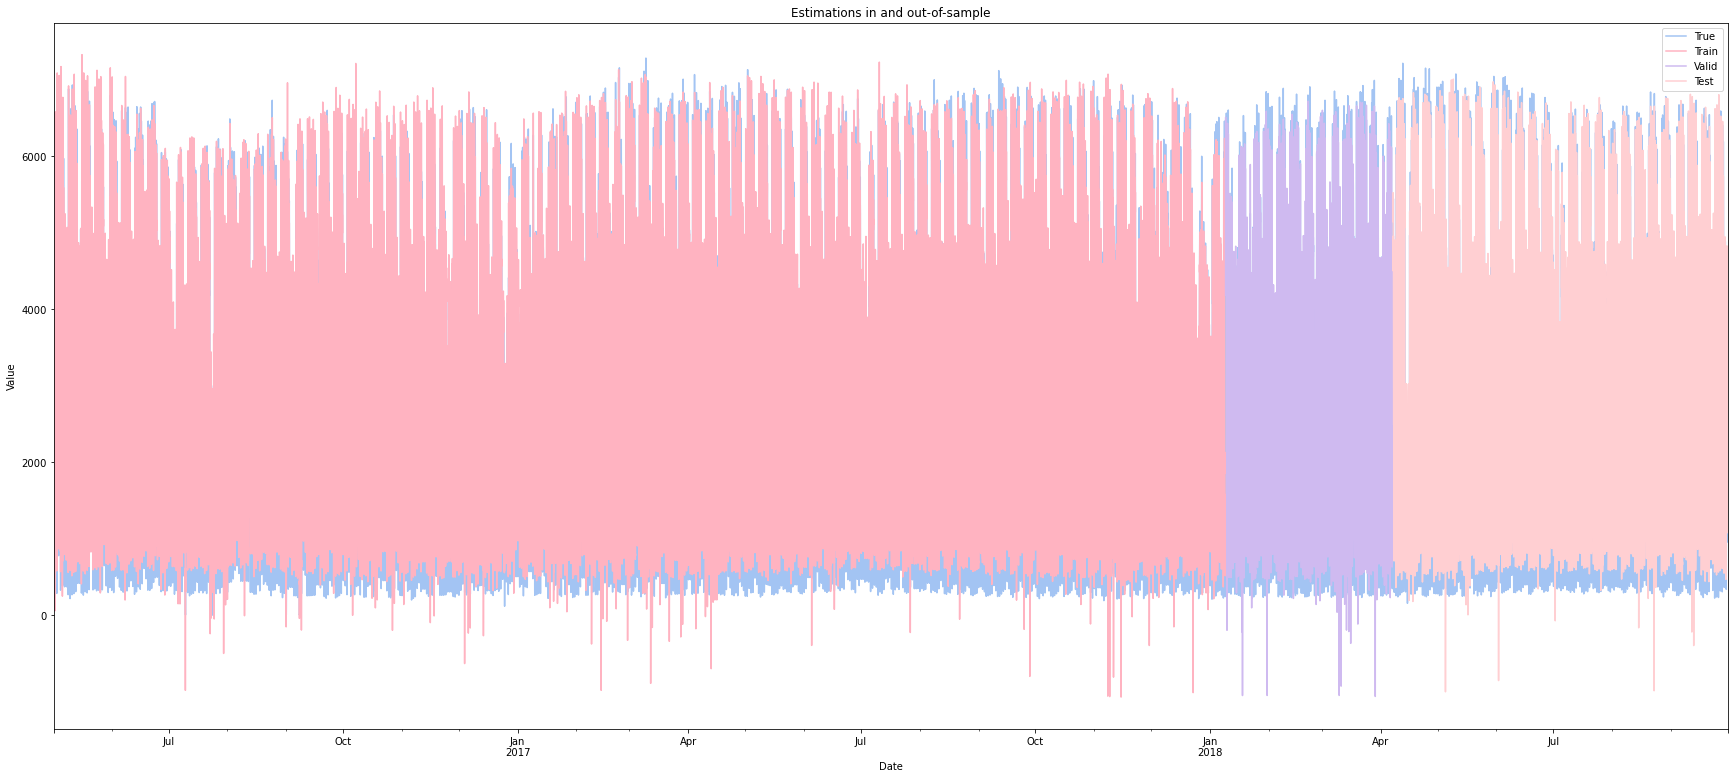

In [79]:
# plot the estimated values of the best model
model.get_plot(title="Estimations in and out-of-sample", xlabel="Date", ylabel="Value")

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Tools box
        </font>
    </h2>
</div>

<p style="text-align: justify">
    We define several functions because the pattern is the same for each model: 1) training on the training set; 2) calibration on the validation set; 3) predictions on the test set; 4) plotting of losses (training and validation) and predictions and 5) display of metrics.
</p>

In [80]:
def plot_loss(history, title: str="Model loss curves by epoch") -> None:
    """
    Method that allows to plot on the same graph the training and validation losses of a neural network
    in order to control its training process and overfitting.

    Parameters
    ----------
    history : keras object
        Training history of a keras neural network.
    
    title : str
        Plot's title.

    Returns
    -------
    None.

    """
    if isinstance(title, str):
        pass
    else:
        raise TypeError(
            f"'title' parameter must be a str: got {type(title)}"
            )
    
    fig, ax = plt.subplots(figsize = (30, 13))
    plt.subplot(1, 1, 1)
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend(loc="best")
    plt.xticks(rotation=0)
    plt.subplots_adjust(hspace=0.6)
    plt.show()

def make_prediction(model, X_test, normalized: bool=False, scaler=None) -> np.ndarray:
    """
    Function that allows to plot on the same graph the training and validation losses of a neural network
    in order to control its training process and overfitting.

    Parameters
    ----------
    model : keras object
        Compiled keras model.
    
    X_test : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Matrix design values ont the test set (out-of-sample predictions).
    
    normalized : bool, optional, default=False
        True if the data has been normalized, else False. Default is False
    
    scaler : sklearn object, optional, default=None
        If normalized paramter is True, you must provide the scaler object to inverse transform predictions. 
        Default is None

    Returns
    -------
    np.ndarray
        Prediction on test set.

    """
    if isinstance(X_test, np.ndarray) or isinstance(X_test, pd.core.frame.DataFrame):
        pass
    else:
        raise TypeError(
            f"'X_test' parameter must be a ndarray or dataframe: got {type(X_test)}"
            )
    
    if isinstance(normalized, bool):
        pass
    else:
        raise TypeError(
            f"'normalized' parameter must be a bool: got {type(normalized)}"
            )
    
    predictions = model.predict(X_test)
    
    if (normalized == True and scaler is not None):
        predictions = pd.DataFrame(
            scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)),
            columns=["traffic"]
        )
    else:
        pass
    
    return predictions

def plot_prediction(y_true, y_pred, model: str) -> None:
    """
    Method to display a plot with the true values of the variable of interest and the estimated values
    on the in and out-of-samples.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
            
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    
    model : str
        Model's name.

    Returns
    -------
    None.

    """
    if y_true.shape[0] == y_pred.shape[0]:

        if isinstance(y_true, pd.core.series.Series) or isinstance(y_true, np.ndarray)\
        or isinstance(y_true, pd.core.frame.DataFrame):
            pass
        else:
            raise TypeError(
                f"'y_true' parameter must be a ndarray series or dataframe: got {type(y_true)}"
                )

        if isinstance(y_pred, pd.core.series.Series) or isinstance(y_pred, np.ndarray)\
        or isinstance(y_pred, pd.core.frame.DataFrame):
            pass
        else:
            raise TypeError(
                f"'y_pred' parameter must be a ndarray series or dataframe: got {type(y_pred)}"
                )

    else:
        raise ValueError(
            "'y_true' and 'y_pred,' parameters must have the same shape"
            )
    
    if isinstance(model, str):
        pass
    else:
        raise TypeError(
            f"'model' parameter must be a str: got {type(model)}"
            )
    
    fig, ax = plt.subplots(figsize = (30, 13))
    plt.subplot(1, 1, 1)
    plt.plot(np.arange(y_true.shape[0]), np.array(y_true), label="True values")
    plt.plot(np.arange(y_pred.shape[0]), np.array(y_pred), label="Prediction values")
    plt.xlabel("Date")
    plt.ylabel("Traffic")
    plt.title(f"Estimations in and out-of-sample for {model} model")
    plt.legend(loc="best")
    plt.xticks(rotation=0)
    plt.subplots_adjust(hspace=0.6)
    plt.show()

def evaluate_prediction(y_true, y_pred, model: str) -> dict:
    """
    Function that allows to evaluate predictions made by the model with MAE, MSE, RMSE and MAPE.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
            
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    
    model : str
        Model's name.

    Returns
    -------
    dict
        Computed metrics.

    """
    if y_true.shape[0] == y_pred.shape[0]:

        if isinstance(y_true, pd.core.series.Series) or isinstance(y_true, np.ndarray)\
        or isinstance(y_true, pd.core.frame.DataFrame):
            pass
        else:
            raise TypeError(
                f"'y_true' parameter must be a ndarray series or dataframe: got {type(y_true)}"
                )

        if isinstance(y_pred, pd.core.series.Series) or isinstance(y_pred, np.ndarray)\
        or isinstance(y_pred, pd.core.frame.DataFrame):
            pass
        else:
            raise TypeError(
                f"'y_pred' parameter must be a ndarray series or dataframe: got {type(y_pred)}"
                )

    else:
        raise ValueError(
            "'y_true' and 'y_pred,' parameters must have the same shape"
            )
    
    if isinstance(model, str):
        pass
    else:
        raise TypeError(
            f"'model' parameter must be a str: got {type(model)}"
            )
    
    return {
        "Model": model,
        "MAE": round(Metrics(y_true=y_true, y_pred=y_pred).mae(), 4),
        "MSE": round(Metrics(y_true=y_true, y_pred=y_pred).mse(), 4),
        "RMSE": round(Metrics(y_true=y_true, y_pred=y_pred).rmse(), 4),
        "MAPE": round(Metrics(y_true=y_true, y_pred=y_pred).mape(), 4)
    }

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Machine Learning
        </font>
    </h2>
</div>

<p style="text-align: justify">
    We will start with simple models and work up to more complex ones.
</p>

<h3 style="font-family: Arial">
    <font color="#088A68">
        1) Train test split data
    </font>
</h3>

In [81]:
# split train valid test split
train = data.iloc[:round(data.shape[0]*0.7)]
valid = data.iloc[round(data.shape[0]*0.7):round(data.shape[0]*0.8)]
test = data.iloc[round(data.shape[0]*0.8):]

train.shape, valid.shape, test.shape

((14827, 36), (2118, 36), (4236, 36))

In [82]:
# features selected from features selection
list_features = [
    "traffic_lag_1",
    "hour_sin",
    "weekday_cos",
    "rain_lag_3",
    "traffic_lag_6",
    "traffic_lag_2",
    "hour_cos",
    "cloud"
]

In [83]:
# split train valid test sets
X_train, y_train = train[list_features], train[["traffic"]]
X_valid, y_valid = valid[list_features], valid[["traffic"]]
X_test, y_test = test[list_features], test[["traffic"]]

In [84]:
# different scaler for input and output
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

In [85]:
# fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

In [86]:
# apply the scaler to training data
y_train = pd.DataFrame(output_scaler.transform(y_train), index=y_train.index, columns=y_train.columns)
X_train = pd.DataFrame(input_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

# apply the scaler to training data
y_valid = pd.DataFrame(output_scaler.transform(y_valid), index=y_valid.index, columns=y_valid.columns)
X_valid = pd.DataFrame(input_scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

# apply the scaler to test data
y_test = pd.DataFrame(output_scaler.transform(y_test), index=y_test.index, columns=y_test.columns)
X_test = pd.DataFrame(input_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

<h3 style="font-family: Arial">
    <font color="#088A68">
        2) Linear regression
    </font>
</h3>

In [87]:
linear_reg = LinearRegression(
    fit_intercept=True,
    normalize="deprecated",
    copy_X=True,
    n_jobs=-1,
    positive=False
)

linear_reg.fit(X_train, y_train)

LinearRegression(n_jobs=-1, normalize='deprecated')

In [88]:
# r-squarred
linear_reg.score(X_valid, y_valid)

0.908256302391256

In [89]:
y_pred_linear_reg = make_prediction(model=linear_reg, X_test=X_test, normalized=True, scaler=scaler_y)

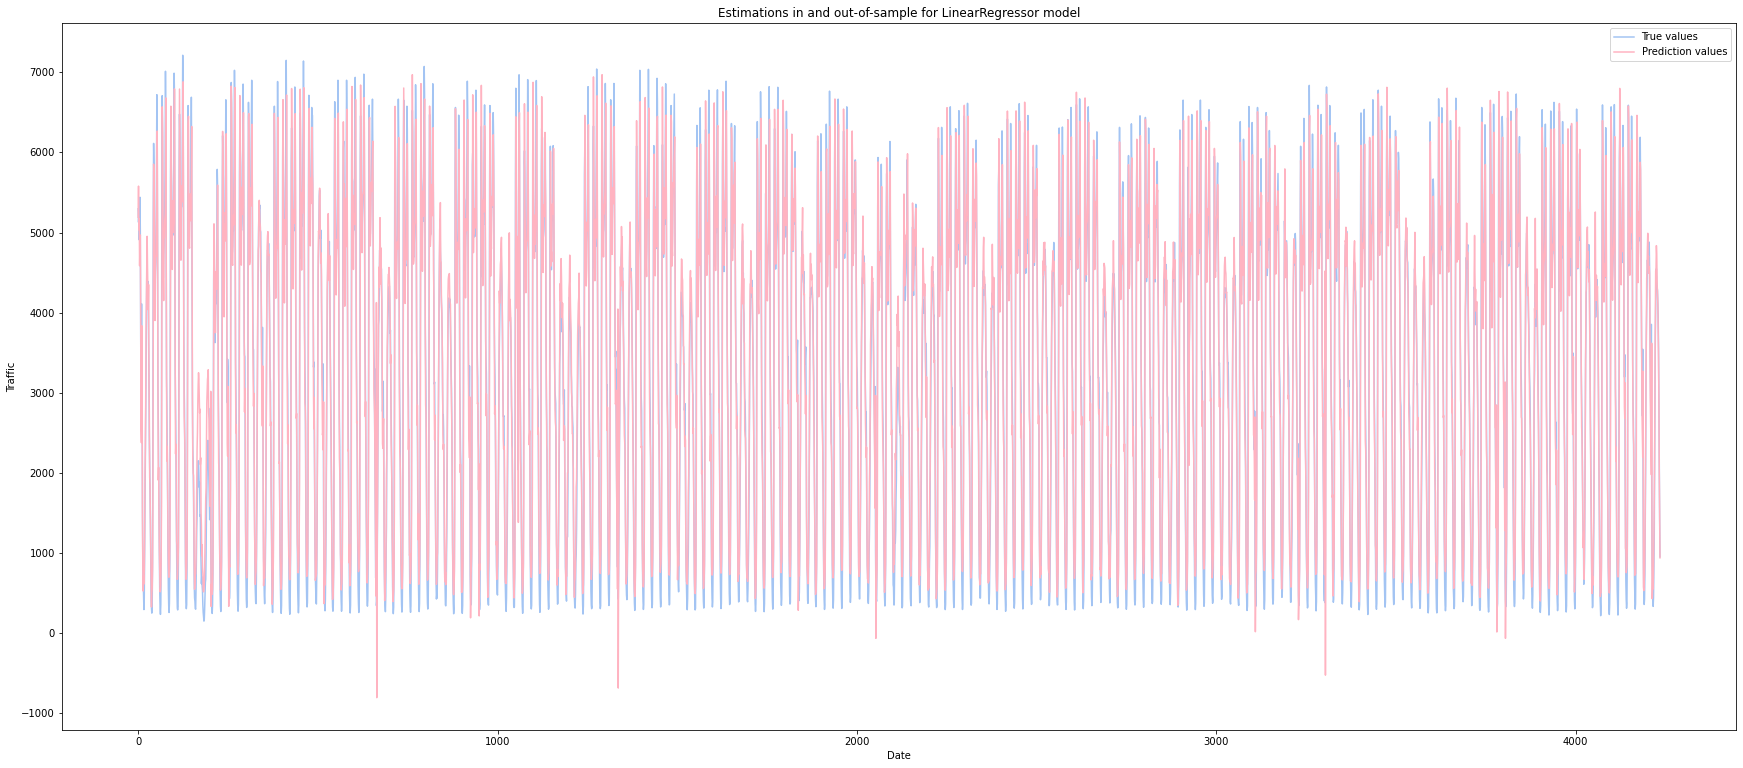

In [90]:
plot_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_linear_reg,
    model="LinearRegressor"
)

In [91]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_linear_reg,
    model="LinearRegressor"
)

{'Model': 'LinearRegressor',
 'MAE': 369.6256,
 'MSE': 273683.9131,
 'RMSE': 523.1481,
 'MAPE': 23.2483}

<h3 style="font-family: Arial">
    <font color="#088A68">
        3) Light GBM
    </font>
</h3>

In [92]:
# gridsearch
pipe = Pipeline(
    [
        (
            "lgbm",
            LGBMRegressor()
        )
    ]
)

param_grid = {
    "lgbm__n_estimators": [100, 300, 500, 1000],
    "lgbm__learning_rate": [0.01, 0.1, 0.3, 0.5, 0.8],
    "lgbm__subsample": [0.7],
    "lgbm__colsample_bytree": [0.7],
    "lgbm__max_depth": [5, 6, 7],
    "lgbm__num_leaves": [50],
    "lgbm__min_child_weight": [300]
}

In [93]:
lgbm_grid = GridSearchCV(
    pipe,
    param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=0
)

lgbm_grid.fit(X_train, np.ravel(y_train))

grid_params = lgbm_grid.best_params_

In [94]:
# model
lgbm = LGBMRegressor(
    n_estimators=grid_params["lgbm__n_estimators"],
    learning_rate=grid_params["lgbm__learning_rate"],
    subsample=grid_params["lgbm__subsample"],
    colsample_bytree=grid_params["lgbm__colsample_bytree"],
    max_depth=grid_params["lgbm__max_depth"],
    num_leaves=grid_params["lgbm__num_leaves"],
    min_child_weight=grid_params["lgbm__min_child_weight"]
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric="rmse",
    verbose=0,
    early_stopping_rounds=20
)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.3, max_depth=5,
              min_child_weight=300, n_estimators=1000, num_leaves=50,
              subsample=0.7)

In [95]:
y_pred_lgbm = make_prediction(model=lgbm, X_test=X_test, normalized=True, scaler=scaler_y)

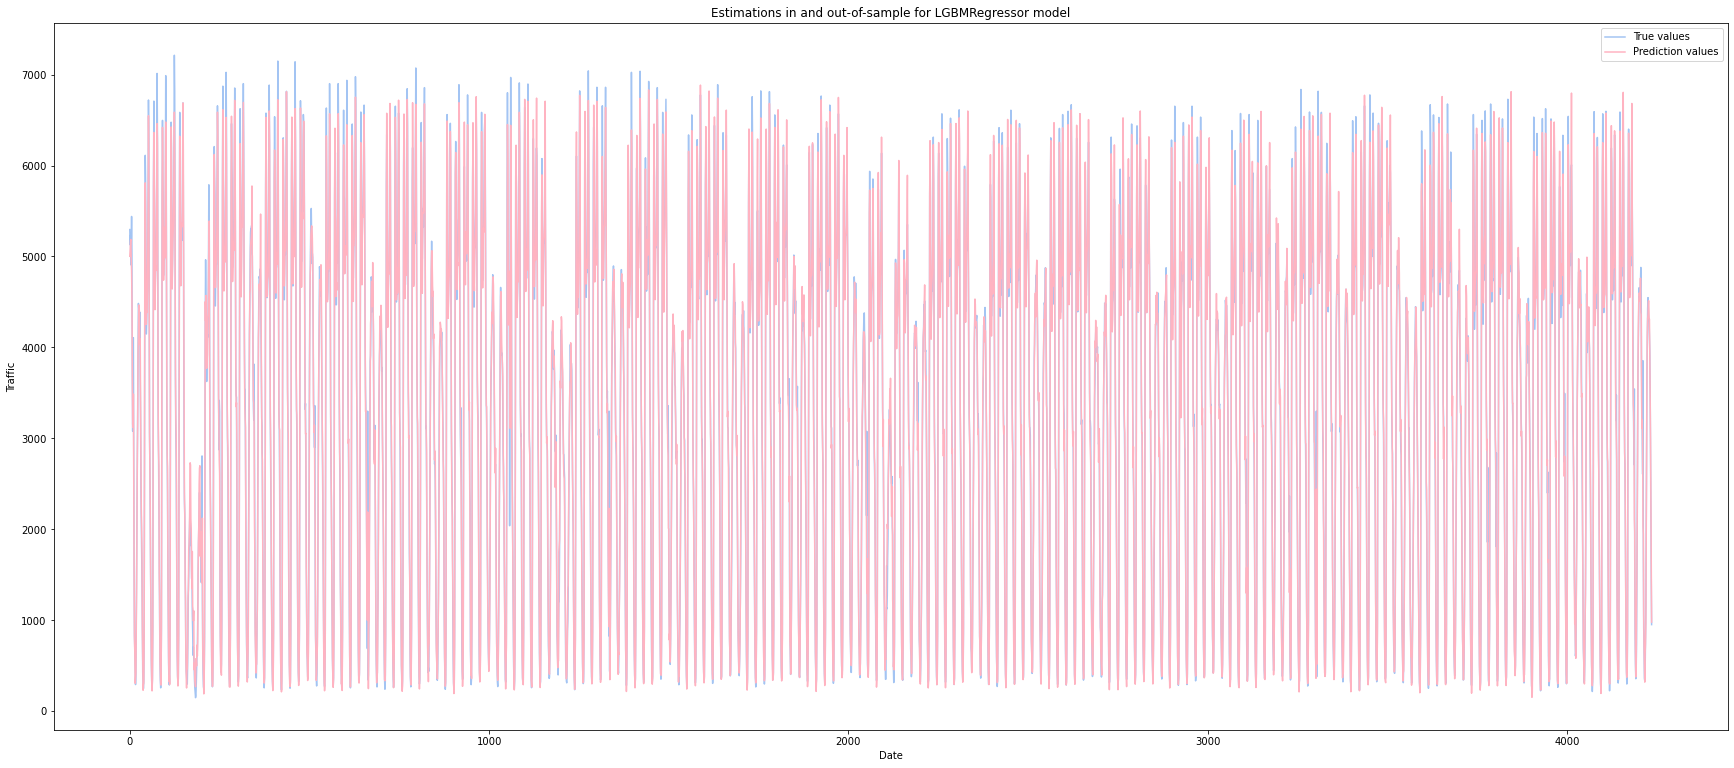

In [96]:
plot_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_lgbm,
    model="LGBMRegressor"
)

In [97]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_lgbm,
    model="LGBMRegressor"
)

{'Model': 'LGBMRegressor',
 'MAE': 159.6142,
 'MSE': 55147.3769,
 'RMSE': 234.8348,
 'MAPE': 7.2545}

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Deep Learning
        </font>
    </h2>
</div>

<p style="text-align: justify">
    We will now apply more complex models.
</p>

<h3 style="font-family: Arial">
    <font color="#088A68">
        1) Train test split and reshape data
    </font>
</h3>

In [98]:
# train test split
train = data.iloc[:round(data.shape[0]*0.8)]
test = data.iloc[round(data.shape[0]*0.8):]

train.shape, test.shape

((16945, 36), (4236, 36))

In [99]:
# features selected from features selection
list_features = [
    "traffic_lag_1",
    "hour_sin",
    "weekday_cos",
    "rain_lag_3",
    "traffic_lag_6",
    "traffic_lag_2",
    "hour_cos",
    "cloud"
]

In [100]:
# split train data to X and y
X_train, y_train = train[list_features], train[["traffic"]]

# split test data to X and y
X_test, y_test = test[list_features], test[["traffic"]]

In [101]:
# different scaler for input and output
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

# fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_X_norm = input_scaler.transform(X_train)

# apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_X_norm = input_scaler.transform(X_test)

In [102]:
# create a 3D input dataset
def create_dataset (X, y, time_steps: int=1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [103]:
# [samples, timesteps, features]
X_train, y_train = create_dataset(X=train_X_norm, y=train_y_norm, time_steps=1)
X_test, y_test = create_dataset(X=test_X_norm, y=test_y_norm, time_steps=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16944, 1, 8), (16944, 1), (4235, 1, 8), (4235, 1))

<h3 style="font-family: Arial">
    <font color="#088A68">
        2) Callbacks
    </font>
</h3>

In [104]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0.01,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    min_delta= 0.01,
    factor=0.01,
    cooldown=2,
    verbose=1
)

<h3 style="font-family: Arial">
    <font color="#088A68">
        3) Multivariate GRU
    </font>
</h3>

In [105]:
gru_nn = Sequential(
    [
        # Input layer
        GRU(
            units=128,
            return_sequences=True,
            input_shape=[X_train.shape[1], X_train.shape[2]] 
        ),
        
        # Dropout layer
        Dropout(
            0.2
        ),
        
        # Hidden layer
        GRU(
            units=64
        ),
        
        # Dropout layer
        Dropout(
            0.2
        ),
        
        # Hidden layer
        Dense(
            units=1
        )
    ], 
    name="GRU"
)

In [106]:
#gru_nn.compile(optimizer="RMSprop", loss="mse")
gru_nn.compile(optimizer="adam", loss="mse")

In [107]:
gru_nn.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            52992     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 90,305
Trainable params: 90,305
Non-trainable params: 0
_________________________________________________________________


In [108]:
gru_history = gru_nn.fit(
    X_train, y_train,
    batch_size=30,
    epochs=30,
    validation_split=0.1,
    callbacks = [
        early_stopping,
        reduce_lr
    ],
    shuffle=False,
    verbose=1
)

Epoch 1/30
509/509 [==============================] - 6s 5ms/step - loss: 0.0268 - val_loss: 0.0162 - lr: 0.0010
Epoch 2/30
509/509 [==============================] - 2s 3ms/step - loss: 0.0160 - val_loss: 0.0157 - lr: 0.0010
Epoch 3/30
509/509 [==============================] - 2s 4ms/step - loss: 0.0145 - val_loss: 0.0138 - lr: 0.0010
Epoch 4/30
501/509 [============================>.] - ETA: 0s - loss: 0.0137
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
509/509 [==============================] - 2s 3ms/step - loss: 0.0137 - val_loss: 0.0136 - lr: 0.0010
Epoch 00004: early stopping


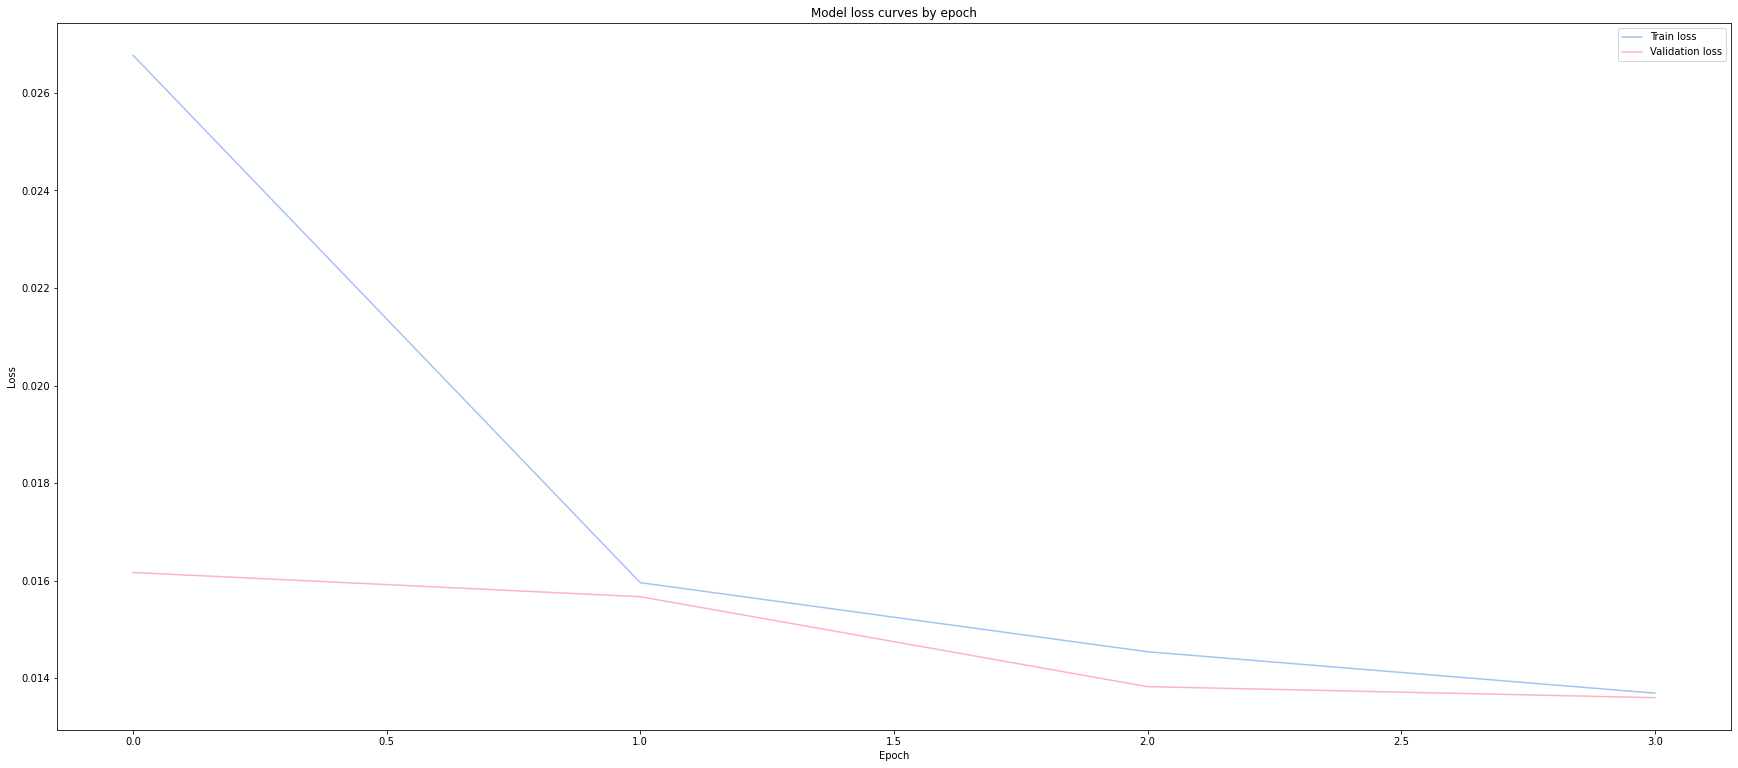

In [109]:
plot_loss(history=gru_history, title="Model loss curves by epoch")

In [110]:
y_pred_gru = make_prediction(model=gru_nn, X_test=X_test, normalized=True, scaler=scaler_y)

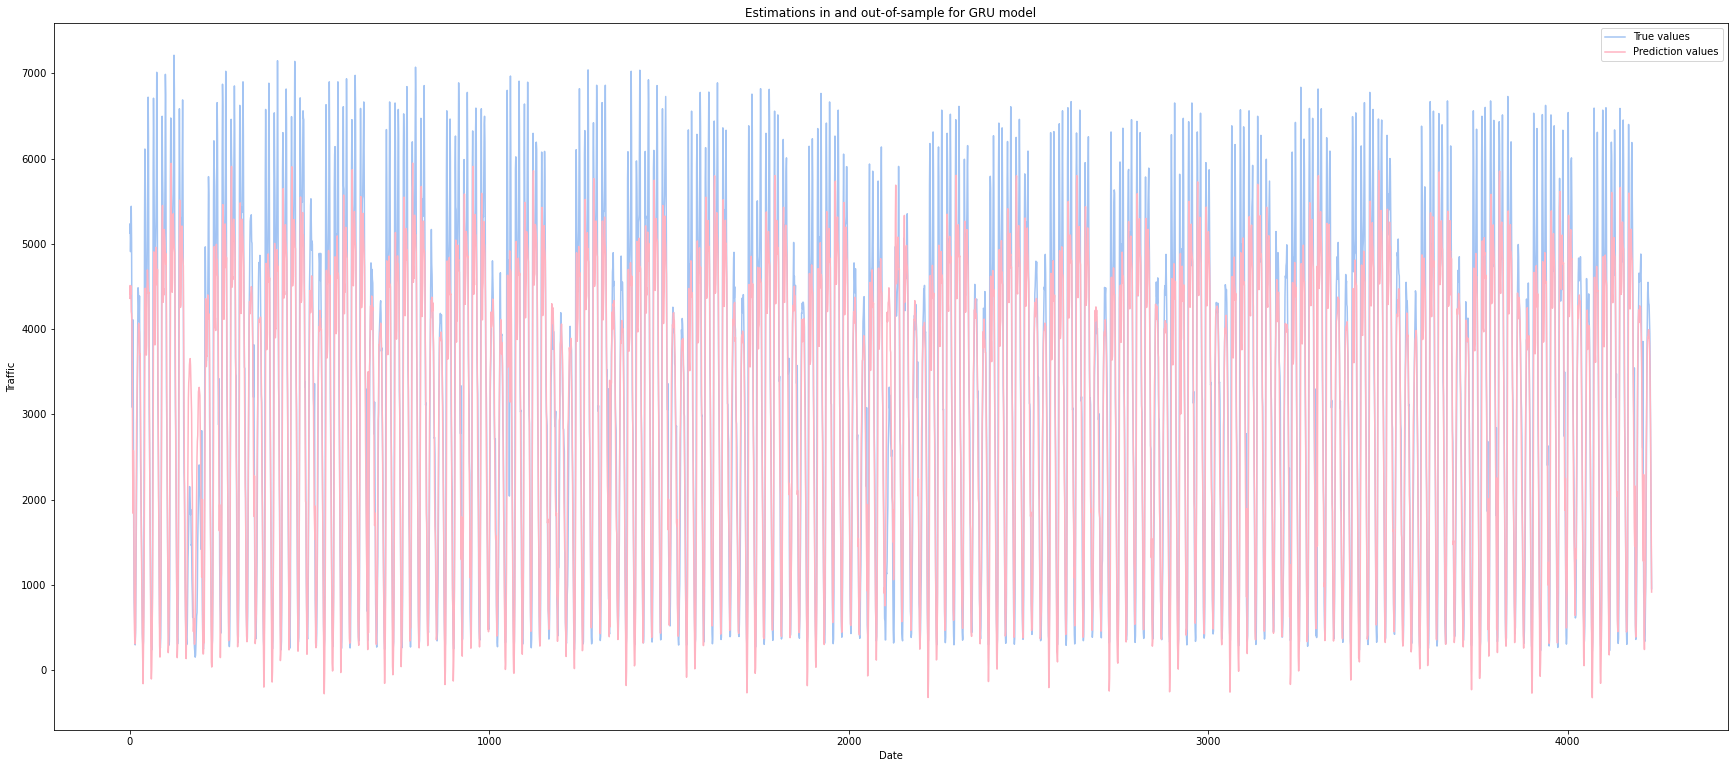

In [111]:
plot_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_gru,
    model="GRU"
)

In [112]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_gru,
    model="GRU"
)

{'Model': 'GRU',
 'MAE': 568.6935,
 'MSE': 681205.6028,
 'RMSE': 825.3518,
 'MAPE': 26.3204}

<h3 style="font-family: Arial">
    <font color="#088A68">
        4) Multivariate LSTM
    </font>
</h3>

In [113]:
lstm_nn = Sequential(
    [
        # Input layer
        LSTM(
            units=128,
            activation="relu",
            return_sequences=True,
            input_shape=[X_train.shape[1], X_train.shape[2]] 
        ),
        
        # Dropout layer
        Dropout(
            0.2
        ),
        
        # Hidden layer
        LSTM(
            units=64,
            activation="relu"
        ),
        
        # Dropout layer
        Dropout(
            0.2
        ),
        
        # Hidden layer
        Dense(
            units=1
        )
    ], 
    name="LSTM"
)

In [114]:
lstm_nn.compile(optimizer="RMSprop", loss="mse")
#lstm_nn.compile(optimizer="adam", loss="mse")

In [115]:
lstm_nn.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70144     
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 119,617
Trainable params: 119,617
Non-trainable params: 0
_________________________________________________________________


In [116]:
lstm_history = lstm_nn.fit(
    X_train, y_train,
    batch_size=30,
    epochs=30,
    validation_split=0.1,
    callbacks = [
        early_stopping,
        reduce_lr
    ],
    shuffle=False,
    verbose=1
)

Epoch 1/30
509/509 [==============================] - 4s 4ms/step - loss: 0.0330 - val_loss: 0.0115 - lr: 0.0010
Epoch 2/30
509/509 [==============================] - 2s 3ms/step - loss: 0.0132 - val_loss: 0.0097 - lr: 0.0010
Epoch 3/30
509/509 [==============================] - 1s 3ms/step - loss: 0.0113 - val_loss: 0.0085 - lr: 0.0010
Epoch 4/30
501/509 [============================>.] - ETA: 0s - loss: 0.0098
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
509/509 [==============================] - 2s 3ms/step - loss: 0.0098 - val_loss: 0.0079 - lr: 0.0010
Epoch 00004: early stopping


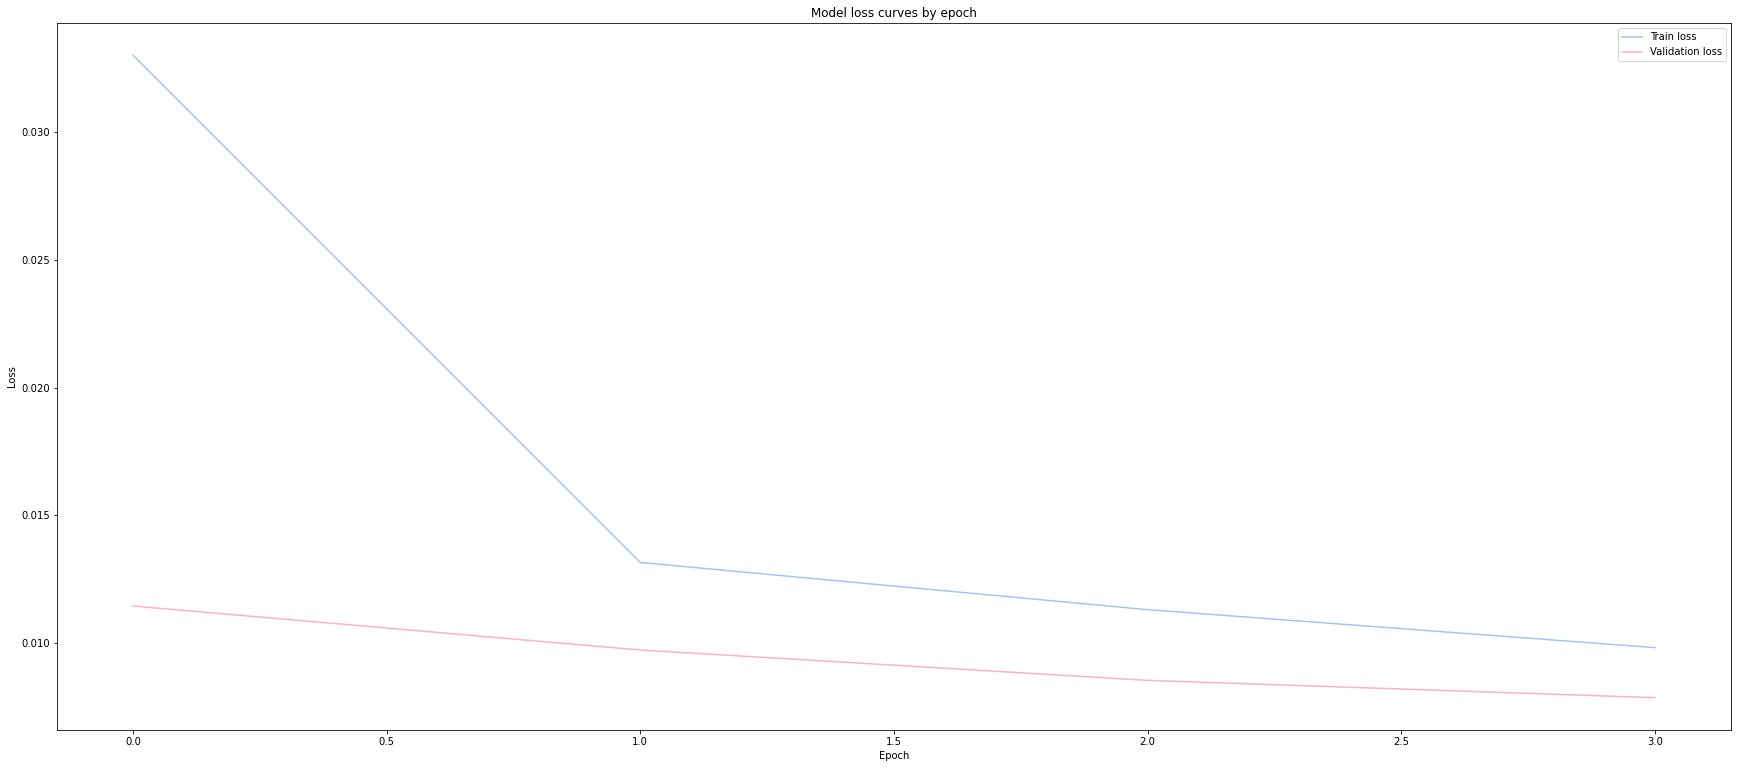

In [117]:
plot_loss(history=lstm_history, title="Model loss curves by epoch")

In [118]:
y_pred_lstm = make_prediction(model=lstm_nn, X_test=X_test, normalized=True, scaler=scaler_y)

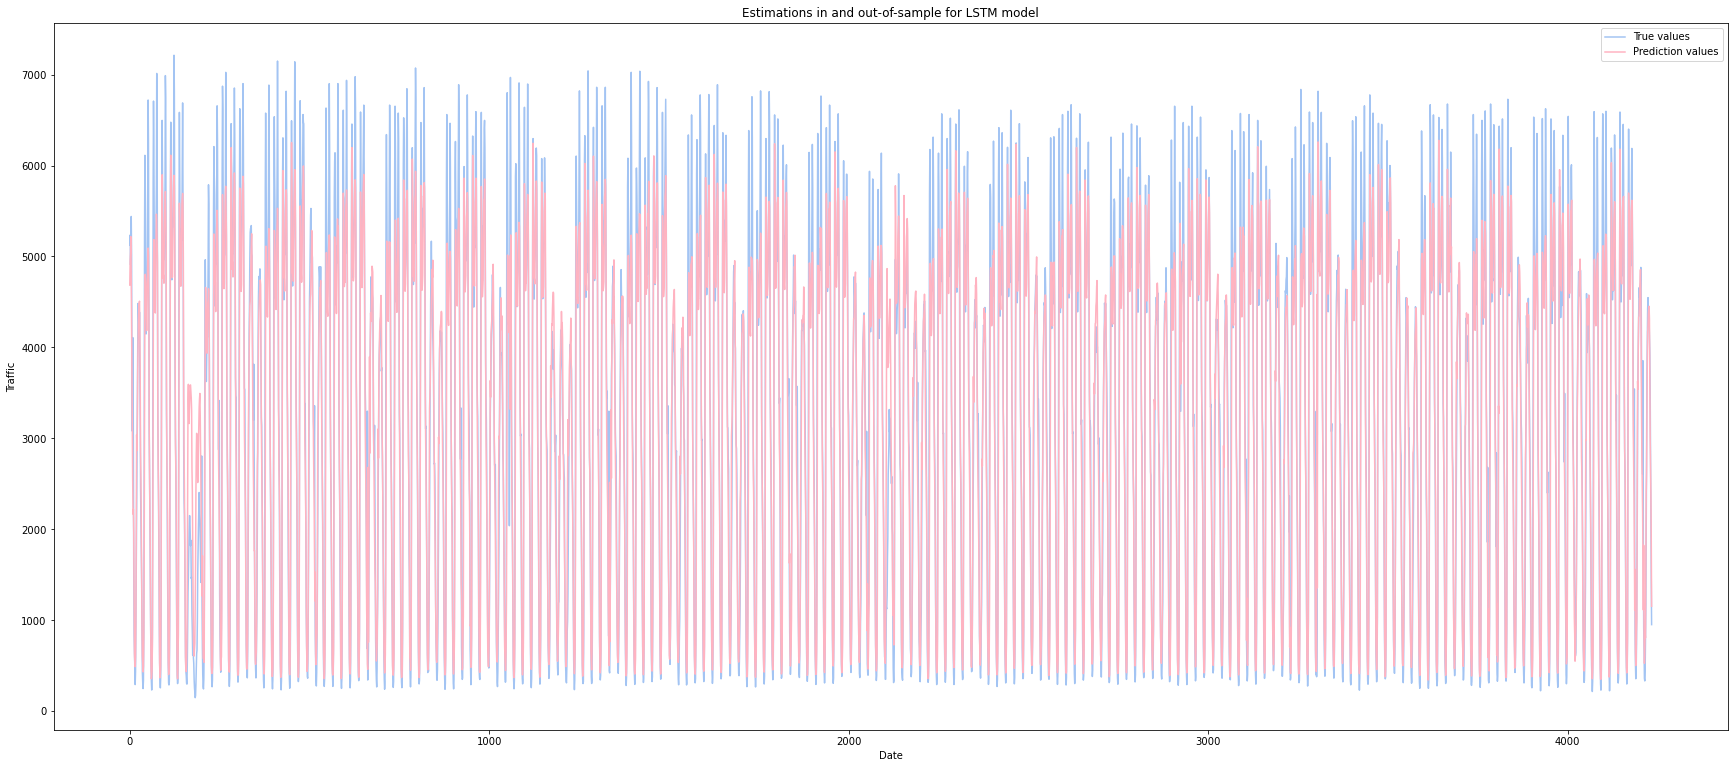

In [119]:
plot_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_lstm,
    model="LSTM")

In [120]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_lstm,
    model="LSTM")

{'Model': 'LSTM',
 'MAE': 390.7719,
 'MSE': 367013.72,
 'RMSE': 605.8166,
 'MAPE': 17.9602}

<h3 style="font-family: Arial">
    <font color="#088A68">
        5) Bidirectional multivariate LSTM
    </font>
</h3>

In [121]:
bilstm_nn = Sequential(
    [
        # Input layer
        Bidirectional(
            LSTM(
                units=128,
                activation="relu",
                return_sequences=True
            ),
            input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        
        # Hidden layer
        Bidirectional(
            LSTM(
                units=64,
                activation="relu",
            )
        ),
        
        # Hidden layer
        Dense(
            units=1
        )
    ], 
    name="BiLSTM"
)

In [122]:
#bilstm_nn.compile(optimizer="RMSprop", loss="mse")
bilstm_nn.compile(optimizer="adam", loss="mse")

In [123]:
bilstm_nn.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 256)           140288    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 304,769
Trainable params: 304,769
Non-trainable params: 0
_________________________________________________________________


In [124]:
bilstm_history = bilstm_nn.fit(
    X_train, y_train,
    batch_size=60,
    epochs=30,
    validation_split=0.1,
    callbacks = [
        early_stopping,
        reduce_lr
    ],
    shuffle=False,
    verbose=1
)

Epoch 1/30
255/255 [==============================] - 6s 7ms/step - loss: 0.0403 - val_loss: 0.0126 - lr: 0.0010
Epoch 2/30
255/255 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0103 - lr: 0.0010
Epoch 3/30
255/255 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0090 - lr: 0.0010
Epoch 4/30
255/255 [==============================] - ETA: 0s - loss: 0.0078
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
255/255 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0079 - lr: 0.0010
Epoch 00004: early stopping


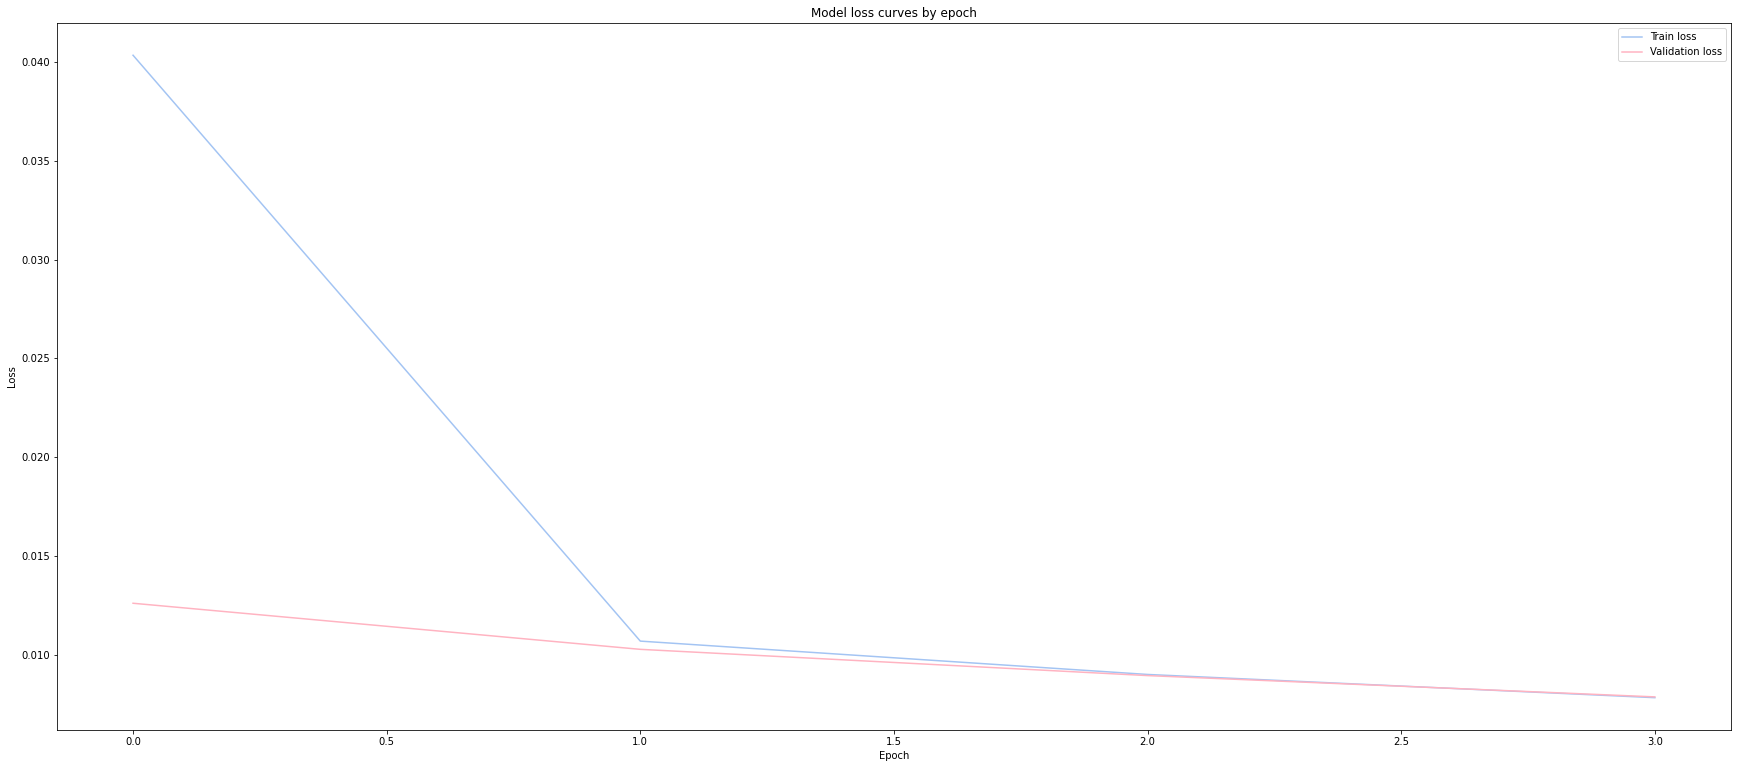

In [125]:
plot_loss(history=bilstm_history, title="Model loss curves by epoch")

In [126]:
y_pred_bilstm = make_prediction(model=bilstm_nn, X_test=X_test, normalized=True, scaler=scaler_y)

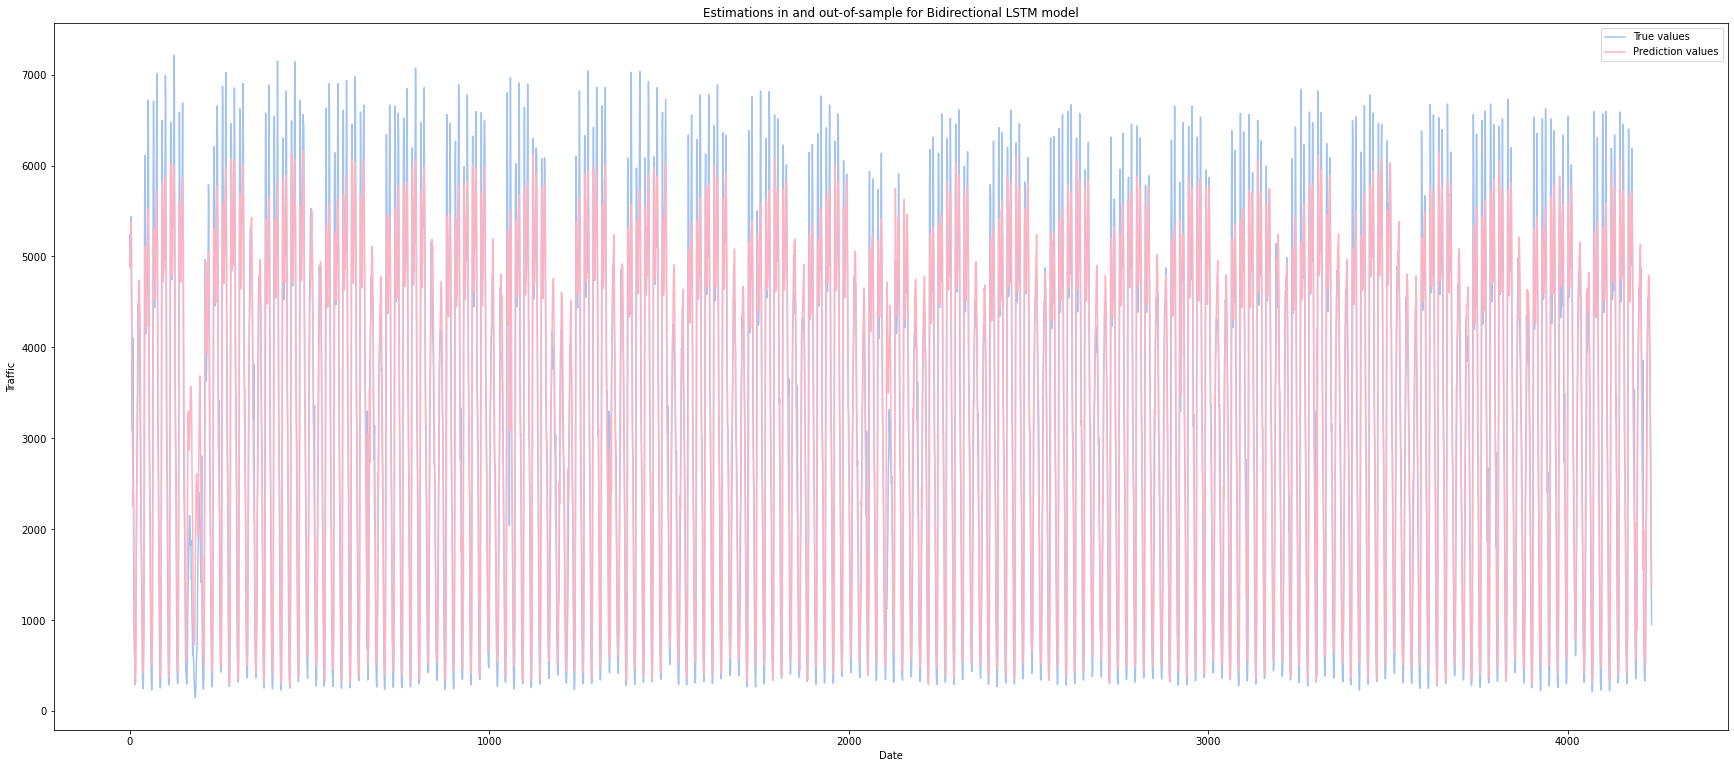

In [127]:
plot_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_bilstm,
    model="Bidirectional LSTM"
)

In [128]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_bilstm,
    model="Bidirectional LSTM"
)

{'Model': 'Bidirectional LSTM',
 'MAE': 416.7452,
 'MSE': 354011.8215,
 'RMSE': 594.9889,
 'MAPE': 22.8881}

<h3 style="font-family: Arial">
    <font color="#088A68">
        6) Multivariate CNN - LSTM
    </font>
</h3>

In [129]:
# [samples, subsequences, timesteps, features]
X_train_2 = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
X_test_2 = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))

X_train_2.shape, X_test_2.shape

((16944, 1, 1, 8), (4235, 1, 1, 8))

In [130]:
cnn_lstm_nn = Sequential(
    [
        # Input layer
        TimeDistributed(
            Conv1D(
                filters=64,
                kernel_size=1,
                activation="relu"
            ),
            input_shape=(None, X_train.shape[1], X_train.shape[2])
        ),
        
        # Maxpooling layer
        TimeDistributed(
            MaxPooling1D(
                pool_size=2,
                padding="same"
            )
        ),
        
        # Flatten layer
        TimeDistributed(
            Flatten()
        ),
        
        # Hidden layer
        LSTM(
            units=128,
            activation="relu",
            return_sequences=True
        ),
        
        # Dropout layer
        Dropout(
            0.2
        ),
        
        # Hidden layer
        LSTM(
            units=64,
            activation="relu",
        ),
        
        # Hidden layer
        Dense(
            units=1
        )
    ], 
    name="CNNLSTM"
)

In [131]:
#cnn_lstm_nn.compile(optimizer="RMSprop", loss="mse")
cnn_lstm_nn.compile(optimizer="adam", loss="mse")

In [132]:
cnn_lstm_nn.summary()

Model: "CNNLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 1, 64)      576       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         98816     
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                           

In [133]:
cnn_lstm_history = cnn_lstm_nn.fit(
    X_train_2, y_train,
    batch_size=30,
    epochs=10,
    validation_split=0.1,
    callbacks = [
        early_stopping,
        reduce_lr
    ],
    shuffle=False,
    verbose=1
)

Epoch 1/10
509/509 [==============================] - 4s 3ms/step - loss: 0.0309 - val_loss: 0.0116 - lr: 0.0010
Epoch 2/10
509/509 [==============================] - 2s 3ms/step - loss: 0.0096 - val_loss: 0.0095 - lr: 0.0010
Epoch 3/10
509/509 [==============================] - 1s 3ms/step - loss: 0.0081 - val_loss: 0.0092 - lr: 0.0010
Epoch 4/10
503/509 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
509/509 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0084 - lr: 0.0010
Epoch 00004: early stopping


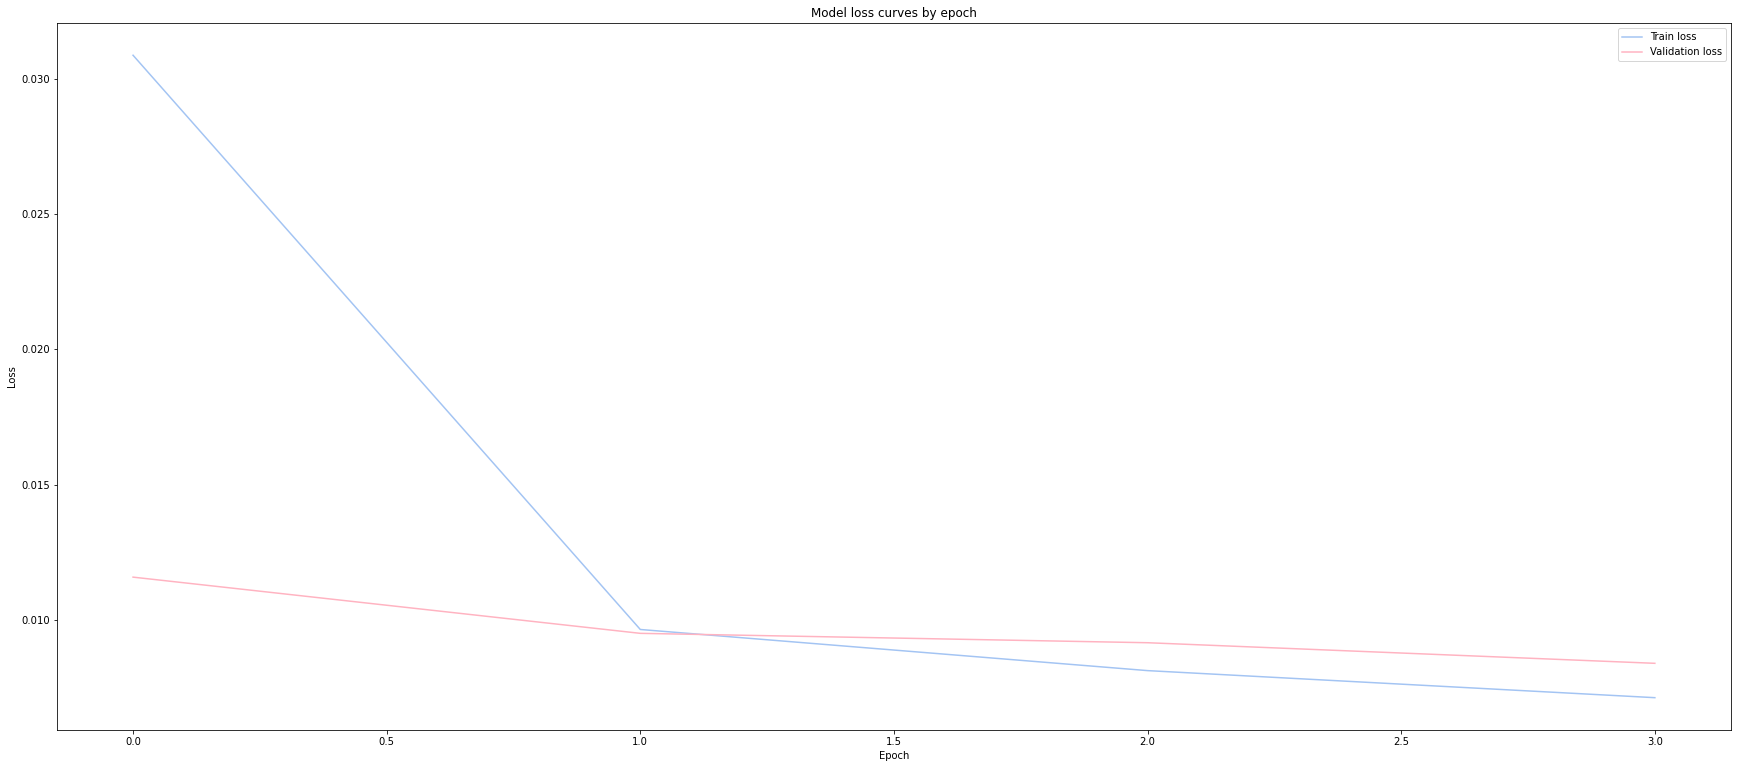

In [134]:
plot_loss(history=cnn_lstm_history, title="Model loss curves by epoch")

In [135]:
y_pred_cnnlstm = make_prediction(model=cnn_lstm_nn, X_test=X_test_2, normalized=True, scaler=scaler_y)

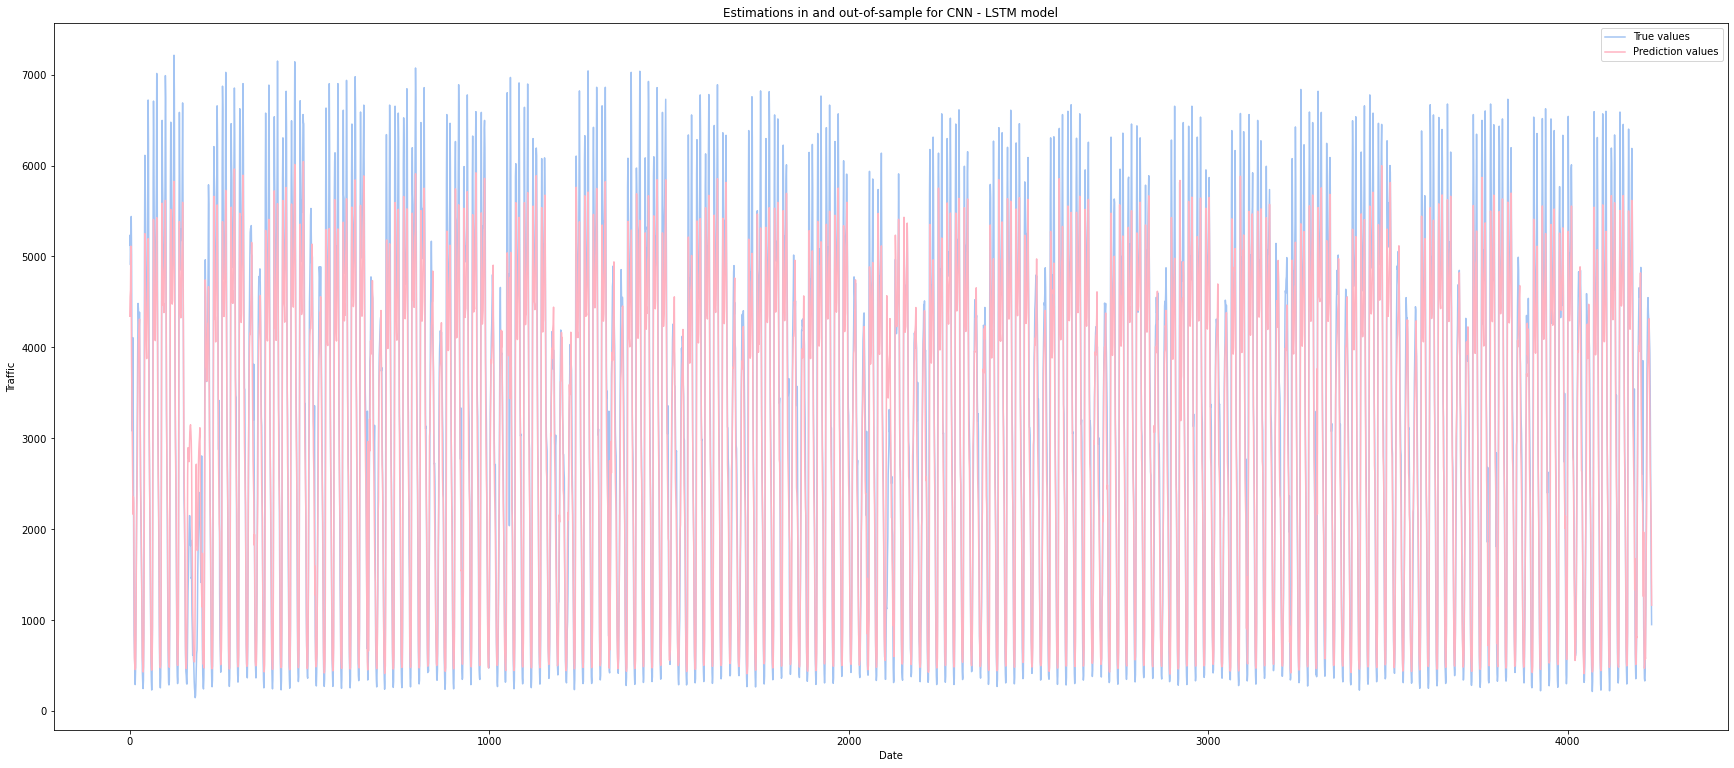

In [136]:
plot_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_cnnlstm,
    model="CNN - LSTM"
)

In [137]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=y_pred_cnnlstm,
    model="CNN - LSTM"
)

{'Model': 'CNN - LSTM',
 'MAE': 460.1683,
 'MSE': 399678.5643,
 'RMSE': 632.2014,
 'MAPE': 19.6357}

-------------------------------------------------------------------------------------------------------------------------------

<div style="margin: 10px;">
    <h2 style="font-family: Arial">
        <font color="#084B8A">
            Opening: hybrid model
        </font>
    </h2>
</div>

<p style="text-align: justify">
    To discuss areas for improvement, recently many papers mention the fact that hybrid methods are more efficient than purely statistical and deep learning methods for forecasting tasks. Inspired by the ES-RNN, or MES-LSTM, observed during the Makridakis-4 forecasting competition, we wanted to try to implement a hybrid model merging linear regression and the high-performance LightGBM. We operated very simply, the objective is to assign a weight $\alpha$ to the regression forecast and $1-\alpha$ to the LightGBM forecast. That is, the new forecast will be: $\hat{y_i} = \alpha \cdot \hat{y_{i,linear reg}} + (1 - \alpha) \cdot \hat{y_{i,lightGBM}}$. This $\alpha$ coefficient is determined by modeling an exponential curve, with a certain slope, in order to give more strength to the short-term forecasts of the regression and then reverse the trend so as to provide greater weight to the long-term forecasts of the LightGBM model. <br>
The performance of these two merged models is not phenomenal but we wanted to explore this track in order to go further.
</p>

<h3 style="font-family: Arial">
    <font color="#088A68">
        1) Test with LGBM and Linear regression
    </font>
</h3>

In [138]:
class JoiningRegressor:
    def __init__(self, y_pred_short_term, y_pred_long_term, exponential_coeff: float=0.8, axis: int=0, plot: bool=True):
        
        if isinstance(axis, int):
            self.axis = axis
        else:
            raise TypeError(
                f"'axis' parameter must be an int: got {type(axis)}"
                )
        
        if y_pred_short_term.shape[axis] == y_pred_long_term.shape[axis]:
            
            if isinstance(y_pred_short_term, pd.core.series.Series) or isinstance(y_pred_short_term, np.ndarray):
                self.y_pred_short_term = y_pred_short_term
            else:
                raise TypeError(
                    f"'y_pred_short_term' parameter must be a ndarray or series: got {type(y_pred_short_term)}"
                    )
            
            if isinstance(y_pred_long_term, pd.core.series.Series) or isinstance(y_pred_long_term, np.ndarray):
                self.y_pred_long_term = y_pred_long_term
            else:
                raise TypeError(
                    f"'y_pred_long_term' parameter must be a ndarray, or series: got {type(y_pred_long_term)}"
                    )
        
        else:
            raise ValueError(
                "'y_pred_short_term' and 'y_pred_long_term' parameters must have the same shape"
                )
        
        if isinstance(exponential_coeff, float):
            self.exponential_coeff = exponential_coeff
        else:
            raise TypeError(
                f"'exponential_coeff' parameter must be a float: got {type(exponential_coeff)}"
                )
        
        if isinstance(plot, bool):
            self.plot = plot
        else:
            raise TypeError(
                f"'plot' parameter must be a bool: got {type(plot)}"
                )
    
    
    def fit(self):
        self.y_pred_short_term.reset_index(drop=True, inplace=True)
        self.y_pred_long_term.reset_index(drop=True, inplace=True)
        
        x_axis = np.arange(0, self.y_pred_short_term.shape[self.axis])
        y_axis = (np.power(self.exponential_coeff, x_axis))
        
        if self.plot:
            fig = plt.figure(figsize=(30, 10))
            plt.subplot(1, 1, 1)
            plt.plot(x_axis, y_axis, color="#F7BE81", label="Exponential smoothing")
            plt.title(f"Exponential smoothing curve for {self.exponential_coeff} coefficient")
            plt.xlabel("Frequency")
            plt.ylabel("Value")
            plt.legend(loc="best")
            plt.subplots_adjust(hspace=0.3)
            plt.show()
        else:
            pass
        
        y_pred = np.zeros(shape=self.y_pred_short_term.shape[self.axis])
        
        for idx in range(0, self.y_pred_short_term.shape[self.axis]):
            alpha = y_axis[idx]
            y_pred[idx] = ((alpha*self.y_pred_short_term[idx])+((1-alpha)*self.y_pred_long_term[idx]))
        
        fig = plt.figure(figsize=(30, 10))
        plt.subplot(1, 1, 1)
        plt.plot(self.y_pred_short_term, color="#9F81F7", label="Short term predictions")
        plt.plot(self.y_pred_long_term, color="#F7BE81", label="Long term predictions")
        plt.plot(y_pred, color="red", label="New predictions")
        plt.title("New predictions compared to initial predictions")
        plt.xlabel("Frequency")
        plt.ylabel("Value")
        plt.legend(loc="best")
        plt.subplots_adjust(hspace=0.3)
        plt.show()
        
        return y_pred

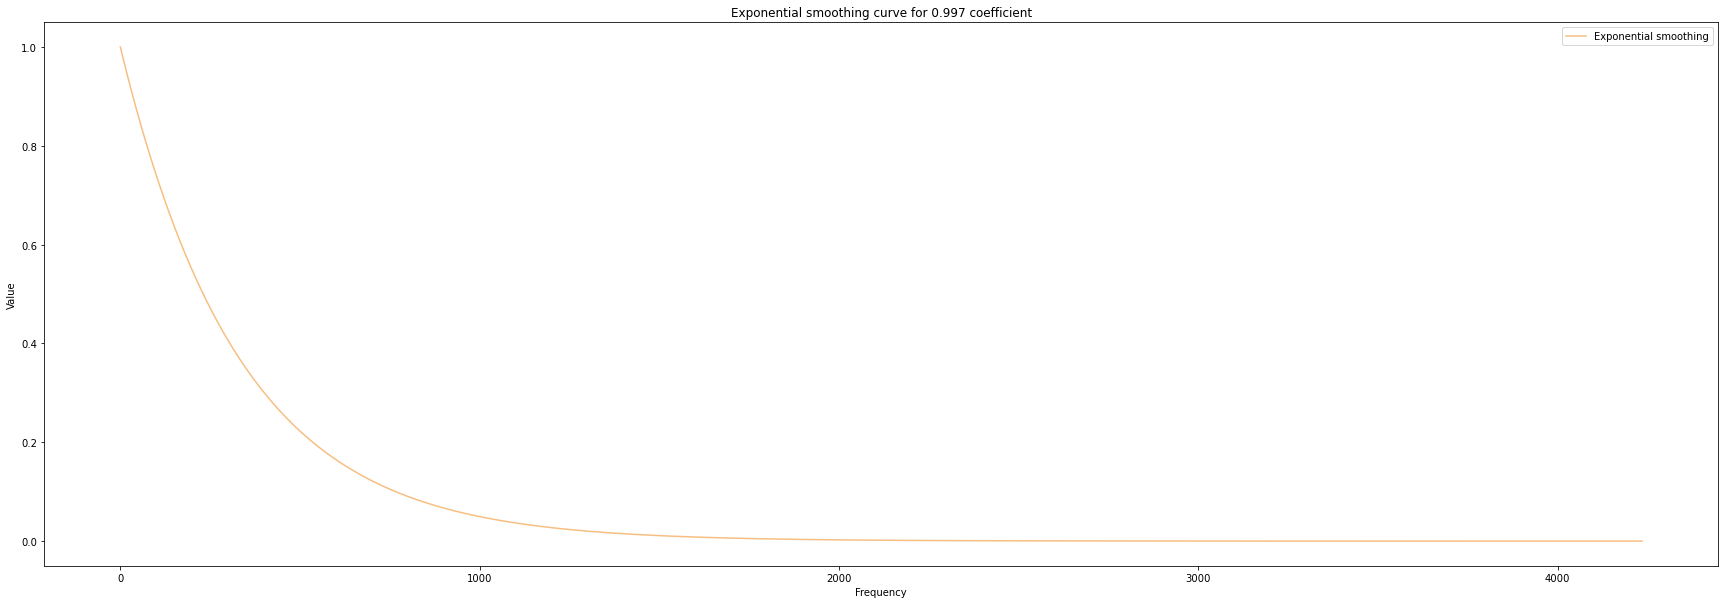

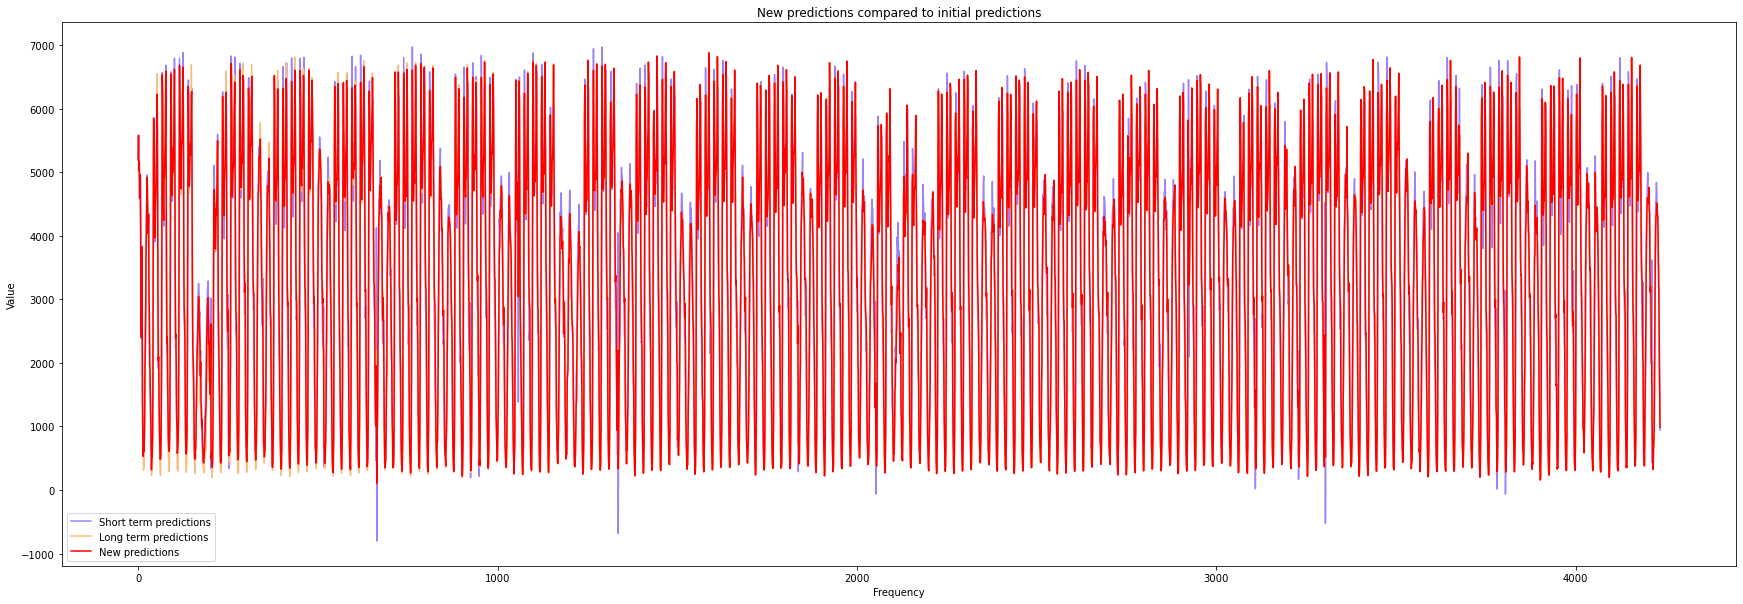

In [139]:
y_pred_hybrid = JoiningRegressor(
    y_pred_short_term=y_pred_linear_reg["traffic"],
    y_pred_long_term=y_pred_lgbm["traffic"],
    exponential_coeff=0.997,
    axis=0,
    plot=True
).fit()

In [140]:
evaluate_prediction(
    y_true=pd.DataFrame(scaler_y.inverse_transform(y_test), columns=["traffic"]),
    y_pred=pd.DataFrame(y_pred_hybrid.reshape(-1, 1), columns=["traffic"]).loc[:4234],
    model="LGBM - Linear regression"
)

{'Model': 'LGBM - Linear regression',
 'MAE': 627.4643,
 'MSE': 760865.4136,
 'RMSE': 872.276,
 'MAPE': 29.3139}